In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold

tf.random.set_seed(1)


In [3]:
os.chdir('E:/Dropbox/Yi/')

fontdir='E:/Dropbox/Yi/8fonts/'
dfs=[]
for file in os.listdir(fontdir):
    filepath=os.path.join(fontdir,file)
    df=pd.read_csv(filepath)
    pixel_ind = df.columns.str.startswith('r')
    pixel_ind[0] = True
    df = df.loc[:,pixel_ind]
    dfs.append(df)
dfs=pd.concat(dfs)

In [4]:
dfs['font']
dfs.to_csv('dfs.csv')

In [5]:
dfs

,font,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,CANDARA,1,1,1,1,12,51,147,147,147,...,255,196,1,1,1,1,1,176,255,255
1,CANDARA,1,1,1,1,12,51,147,147,147,...,255,196,1,1,1,1,1,91,255,156
2,CANDARA,1,1,1,1,1,1,5,93,147,...,1,1,1,1,1,82,246,255,255,255
3,CANDARA,1,1,1,1,1,1,5,93,147,...,1,1,1,1,1,1,192,255,255,96
4,CANDARA,1,1,1,1,1,1,38,93,147,...,1,1,128,255,255,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,SYLFAEN,1,1,1,6,80,214,255,255,239,...,91,239,255,255,214,80,6,1,1,1
3180,SYLFAEN,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3181,SYLFAEN,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3182,SYLFAEN,1,1,1,171,255,255,255,255,255,...,255,255,255,86,1,1,1,1,1,1


In [6]:
class_size=dfs.value_counts('font') #check size of each classes
class_size

font
ITALIC        3712
GABRIOLA      3512
SYLFAEN       3184
CANDARA       3024
CORBEL        3024
CONSTANTIA    3018
ROCKWELL      2946
IMPACT        2716
dtype: int64

In [7]:
x=dfs.iloc[:,dfs.columns.str.startswith('r')].values #df.values converts df into numpy,remove axis
x.shape

(25136, 400)

In [8]:
# reshape 400 into 20 by 20
x=x.reshape(-1,20,20)
x.shape

(25136, 20, 20)

In [9]:
dfy=pd.get_dummies(dfs.font) #one hot encoding for every case label|
col_idx=dfy.columns # 8 class names 
col_idx
y=dfy.values
col_idx,y.shape

(Index(['CANDARA', 'CONSTANTIA', 'CORBEL', 'GABRIOLA', 'IMPACT', 'ITALIC',
        'ROCKWELL', 'SYLFAEN'],
       dtype='object'),
 (25136, 8))

 display 2 image sample from each class

In [10]:
class_size

font
ITALIC        3712
GABRIOLA      3512
SYLFAEN       3184
CANDARA       3024
CORBEL        3024
CONSTANTIA    3018
ROCKWELL      2946
IMPACT        2716
dtype: int64

In [11]:
class_size=[3024,3018,3024,3512,2716,3712,2946,3184]

In [12]:
sum1=[]
s=0
for k in class_size:
    s=s+k-1
    sum1.append(s)
sum1 # accumulative size list

[3023, 6040, 9063, 12574, 15289, 19000, 21945, 25128]

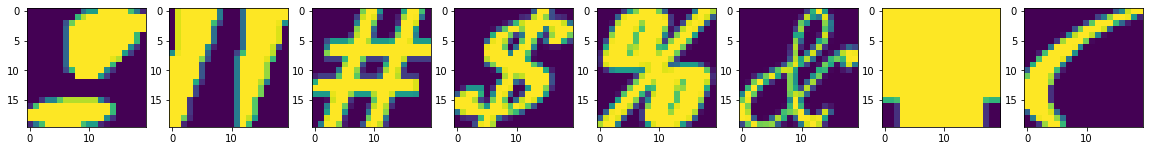

In [13]:
fig,ax=plt.subplots(1,8,figsize=(20,20))
ax=ax.flatten()
for k in range(8):
    ax[k].imshow(x[sum1[k]])
    plt.savefig('ax{0}.jpg'.format(k))

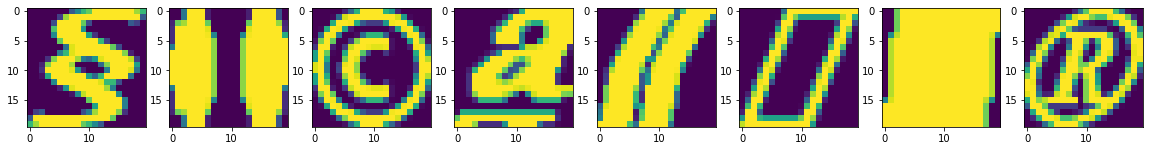

In [14]:
fig,ax=plt.subplots(1,8,figsize=(20,20))
ax=ax.flatten()
for k in range(8):
    ax[k].imshow(x[sum1[k]-100])
    plt.savefig('ax{0}2.jpg'.format(k))

In [15]:
x.min(),x.max()
x.shape

(25136, 20, 20)

In [16]:
x = x[..., np.newaxis]/255
x.shape, y.shape

((25136, 20, 20, 1), (25136, 8))

In [17]:
x.min(),x.max()

(0.0, 1.0)

train,test split

In [18]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=1)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((22622, 20, 20, 1), (2514, 20, 20, 1), (22622, 8), (2514, 8))

In [19]:
K=np.sqrt(22622) # batch size k=sqrt training size
K

150.40611689688689

CNN model

In [20]:
def module(c1,k1,c2,k2,hidden,lrate,epochs):
    inputs=keras.layers.Input(shape=(20,20,1))
    conv1=layers.Conv2D(c1,k1,activation='relu')(inputs)
    pool1=layers.MaxPooling2D((2,2))(conv1)
    conv2=layers.Conv2D(c2,k2,activation='relu')(pool1)
    pool2=layers.MaxPooling2D((2,2))(conv2)
    flat=layers.Flatten()(pool2)
    drop=layers.Dropout(0.25)(flat)
    dense1=layers.Dense(hidden,activation='relu')(drop)
    outputs=layers.Dense(8,activation='softmax')(dense1)
    model=keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    
    start = time.time()
    history=model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=120,epochs=epochs) 
    end=time.time()
    cpu=end-start
    cpu=round(cpu,4)
    return(model,history,cpu)

In [21]:
def hidden(c1,k1,c2,k2):
    c1_out= 20-k1+1
    p1_out=np.floor(c1_out/2)
    c2_out= p1_out-k2+1
    p2_out= np.floor(c2_out/2)
    f_out= p2_out * p2_out * c2
    h=np.floor(f_out/2)
    return h

In [319]:
#mutiple layers of for loop for different combination of window size and channels(part1) (36 models intotal)
cpu_list=[]
total_params=[]
parsimony_ratio=[]
hidden_list=[]
c1_list=[]
k1_list=[]
c2_list=[]
k2_list=[]

max_train_acc_list=[]
max_train_acc_index_list=[]
max_test_acc_list=[]
max_test_acc_index_list=[]

min_train_loss_list=[]
min_train_loss_index_list=[]
min_test_loss_list=[]
min_test_loss_list_index=[]

c1lst=[8,16]
k1lst=[3,5,7]
c2lst=[16,32,48]
k2lst=[2,3]

epochs=400


for c1 in c1lst:
    for k1 in k1lst:
        for c2 in c2lst:
            for k2 in k2lst: 
                
                myresult=module(c1,k1,c2,k2,hidden(c1,k1,c2,k2),0.0001,epochs)
                
                frame=myresult[0].summary()
                cpu=myresult[2]
                print('cpu',cpu)
                cpu_list.append(cpu)
                
                pickle.dump(myresult, open("E:/Dropbox/Yi/results_53pm_1/Training and test accuracy of c1={0},k1={1},c2={2},k2={3}.pickle".format(c1,k1,c2,k2), "wb" ))
                #  #dump each model result into a pickle fine. 
                c1_list.append(c1)
                k1_list.append(k1)
                c2_list.append(c2)
                k2_list.append(k2)
                
                hidden_size=hidden(c1,k1,c2,k2)
                hidden_list.append(hidden_size)
                
                total_p=myresult[0].count_params()  # model total parameters
                total_params.append(total_p)
                 
                pr=(x_train.shape[0]*8)/total_p  #parsimoni ratio
                parsimony_ratio.append(pr)
                
                
                max_train_acc=max(myresult[1].history['accuracy']) # best train acc and best acc index
                max_train_acc_list.append(max_train_acc)
                
                max_train_acc_index=np.argmax(myresult[1].history['accuracy'])
                max_train_acc_index_list.append(max_train_acc_index)
                
                max_test_acc=max(myresult[1].history['val_accuracy']) # best test acc and best acc index
                max_test_acc_list.append(max_test_acc)
                
                max_test_acc_index=np.argmax(myresult[1].history['val_accuracy'])
                max_test_acc_index_list.append(max_test_acc_index)
                

                min_train_loss=min(myresult[1].history['loss'])        #min loss train and index
                min_train_loss_list.append(min_train_loss)
                
                min_train_loss_index=np.argmin(myresult[1].history['loss'])
                min_train_loss_index_list.append(min_train_loss_index)
                
                min_test_loss=min(myresult[1].history['val_loss'])   # min loss test and index 
                min_test_loss_list.append(min_test_loss)
                
                min_test_loss_index=np.argmin(myresult[1].history['val_loss'])
                min_test_loss_list_index.append(min_test_loss_index)                

Epoch 1/400
189/189 [==============================] - 4s 15ms/step - loss: 2.0588 - accuracy: 0.1661 - val_loss: 2.0064 - val_accuracy: 0.2570
Epoch 2/400
189/189 [==============================] - 3s 14ms/step - loss: 1.9161 - accuracy: 0.2860 - val_loss: 1.7974 - val_accuracy: 0.3397
Epoch 3/400
189/189 [==============================] - 3s 15ms/step - loss: 1.7727 - accuracy: 0.3279 - val_loss: 1.7210 - val_accuracy: 0.3532
Epoch 4/400
189/189 [==============================] - 3s 14ms/step - loss: 1.7304 - accuracy: 0.3450 - val_loss: 1.6909 - val_accuracy: 0.3656
Epoch 5/400
189/189 [==============================] - 3s 13ms/step - loss: 1.7038 - accuracy: 0.3544 - val_loss: 1.6731 - val_accuracy: 0.3811
Epoch 6/400
189/189 [==============================] - 3s 13ms/step - loss: 1.6868 - accuracy: 0.3642 - val_loss: 1.6582 - val_accuracy: 0.3807
Epoch 7/400
189/189 [==============================] - 3s 14ms/step - loss: 1.6699 - accuracy: 0.3685 - val_loss: 1.6460 - val_accuracy:

189/189 [==============================] - 3s 13ms/step - loss: 1.1419 - accuracy: 0.5822 - val_loss: 1.0993 - val_accuracy: 0.6078
Epoch 114/400
189/189 [==============================] - 3s 14ms/step - loss: 1.1308 - accuracy: 0.5857 - val_loss: 1.0949 - val_accuracy: 0.6126
Epoch 115/400
189/189 [==============================] - 3s 14ms/step - loss: 1.1326 - accuracy: 0.5885 - val_loss: 1.0964 - val_accuracy: 0.6106
Epoch 116/400
189/189 [==============================] - 3s 14ms/step - loss: 1.1262 - accuracy: 0.5901 - val_loss: 1.0932 - val_accuracy: 0.6082
Epoch 117/400
189/189 [==============================] - 3s 13ms/step - loss: 1.1250 - accuracy: 0.5876 - val_loss: 1.0897 - val_accuracy: 0.6078
Epoch 118/400
189/189 [==============================] - 3s 13ms/step - loss: 1.1280 - accuracy: 0.5860 - val_loss: 1.0858 - val_accuracy: 0.6122
Epoch 119/400
189/189 [==============================] - 3s 14ms/step - loss: 1.1228 - accuracy: 0.5886 - val_loss: 1.0822 - val_accuracy:

189/189 [==============================] - 3s 13ms/step - loss: 0.9109 - accuracy: 0.6700 - val_loss: 0.8884 - val_accuracy: 0.6913
Epoch 226/400
189/189 [==============================] - 3s 14ms/step - loss: 0.9090 - accuracy: 0.6704 - val_loss: 0.8920 - val_accuracy: 0.6874
Epoch 227/400
189/189 [==============================] - 3s 13ms/step - loss: 0.9076 - accuracy: 0.6694 - val_loss: 0.8844 - val_accuracy: 0.6941
Epoch 228/400
189/189 [==============================] - 2s 13ms/step - loss: 0.9048 - accuracy: 0.6708 - val_loss: 0.8810 - val_accuracy: 0.6945
Epoch 229/400
189/189 [==============================] - 2s 11ms/step - loss: 0.9090 - accuracy: 0.6668 - val_loss: 0.8838 - val_accuracy: 0.6897
Epoch 230/400
189/189 [==============================] - 3s 14ms/step - loss: 0.9043 - accuracy: 0.6712 - val_loss: 0.8815 - val_accuracy: 0.6913
Epoch 231/400
189/189 [==============================] - 3s 14ms/step - loss: 0.8992 - accuracy: 0.6744 - val_loss: 0.8825 - val_accuracy:

189/189 [==============================] - 3s 14ms/step - loss: 0.7920 - accuracy: 0.7125 - val_loss: 0.7906 - val_accuracy: 0.7259
Epoch 338/400
189/189 [==============================] - 3s 14ms/step - loss: 0.7846 - accuracy: 0.7136 - val_loss: 0.7896 - val_accuracy: 0.7283
Epoch 339/400
189/189 [==============================] - 3s 14ms/step - loss: 0.7835 - accuracy: 0.7132 - val_loss: 0.7884 - val_accuracy: 0.7287
Epoch 340/400
189/189 [==============================] - 3s 14ms/step - loss: 0.7824 - accuracy: 0.7153 - val_loss: 0.7912 - val_accuracy: 0.7255
Epoch 341/400
189/189 [==============================] - 3s 14ms/step - loss: 0.7848 - accuracy: 0.7114 - val_loss: 0.7875 - val_accuracy: 0.7247
Epoch 342/400
189/189 [==============================] - 3s 14ms/step - loss: 0.7849 - accuracy: 0.7147 - val_loss: 0.7886 - val_accuracy: 0.7279
Epoch 343/400
189/189 [==============================] - 3s 14ms/step - loss: 0.7801 - accuracy: 0.7168 - val_loss: 0.7864 - val_accuracy:

189/189 [==============================] - 2s 11ms/step - loss: 1.5426 - accuracy: 0.4183 - val_loss: 1.5276 - val_accuracy: 0.4372
Epoch 38/400
189/189 [==============================] - 2s 12ms/step - loss: 1.5358 - accuracy: 0.4189 - val_loss: 1.5253 - val_accuracy: 0.4375
Epoch 39/400
189/189 [==============================] - 2s 12ms/step - loss: 1.5328 - accuracy: 0.4186 - val_loss: 1.5192 - val_accuracy: 0.4356
Epoch 40/400
189/189 [==============================] - 2s 12ms/step - loss: 1.5316 - accuracy: 0.4241 - val_loss: 1.5168 - val_accuracy: 0.4403
Epoch 41/400
189/189 [==============================] - 2s 11ms/step - loss: 1.5297 - accuracy: 0.4221 - val_loss: 1.5136 - val_accuracy: 0.4391
Epoch 42/400
189/189 [==============================] - 2s 11ms/step - loss: 1.5237 - accuracy: 0.4245 - val_loss: 1.5090 - val_accuracy: 0.4423
Epoch 43/400
189/189 [==============================] - 2s 11ms/step - loss: 1.5207 - accuracy: 0.4250 - val_loss: 1.5050 - val_accuracy: 0.445

189/189 [==============================] - 2s 12ms/step - loss: 1.3048 - accuracy: 0.5160 - val_loss: 1.2689 - val_accuracy: 0.5394
Epoch 150/400
189/189 [==============================] - 2s 12ms/step - loss: 1.3041 - accuracy: 0.5213 - val_loss: 1.2696 - val_accuracy: 0.5422
Epoch 151/400
189/189 [==============================] - 2s 12ms/step - loss: 1.3024 - accuracy: 0.5130 - val_loss: 1.2668 - val_accuracy: 0.5406
Epoch 152/400
189/189 [==============================] - 2s 13ms/step - loss: 1.3014 - accuracy: 0.5148 - val_loss: 1.2630 - val_accuracy: 0.5449
Epoch 153/400
189/189 [==============================] - 2s 12ms/step - loss: 1.2969 - accuracy: 0.5181 - val_loss: 1.2637 - val_accuracy: 0.5386
Epoch 154/400
189/189 [==============================] - 2s 12ms/step - loss: 1.2949 - accuracy: 0.5193 - val_loss: 1.2626 - val_accuracy: 0.5426
Epoch 155/400
189/189 [==============================] - 2s 12ms/step - loss: 1.2954 - accuracy: 0.5199 - val_loss: 1.2603 - val_accuracy:

189/189 [==============================] - 2s 12ms/step - loss: 1.1687 - accuracy: 0.5696 - val_loss: 1.1391 - val_accuracy: 0.5891
Epoch 262/400
189/189 [==============================] - 2s 12ms/step - loss: 1.1710 - accuracy: 0.5691 - val_loss: 1.1380 - val_accuracy: 0.5903
Epoch 263/400
189/189 [==============================] - 2s 12ms/step - loss: 1.1698 - accuracy: 0.5694 - val_loss: 1.1399 - val_accuracy: 0.5947
Epoch 264/400
189/189 [==============================] - 2s 12ms/step - loss: 1.1652 - accuracy: 0.5682 - val_loss: 1.1380 - val_accuracy: 0.5895
Epoch 265/400
189/189 [==============================] - 2s 12ms/step - loss: 1.1692 - accuracy: 0.5678 - val_loss: 1.1350 - val_accuracy: 0.5887
Epoch 266/400
189/189 [==============================] - 2s 13ms/step - loss: 1.1675 - accuracy: 0.5656 - val_loss: 1.1363 - val_accuracy: 0.5939
Epoch 267/400
189/189 [==============================] - 2s 13ms/step - loss: 1.1690 - accuracy: 0.5692 - val_loss: 1.1357 - val_accuracy:

189/189 [==============================] - 2s 12ms/step - loss: 1.0844 - accuracy: 0.6012 - val_loss: 1.0678 - val_accuracy: 0.6158
Epoch 374/400
189/189 [==============================] - 2s 12ms/step - loss: 1.0854 - accuracy: 0.5977 - val_loss: 1.0694 - val_accuracy: 0.6126
Epoch 375/400
189/189 [==============================] - 2s 12ms/step - loss: 1.0890 - accuracy: 0.5967 - val_loss: 1.0674 - val_accuracy: 0.6150
Epoch 376/400
189/189 [==============================] - 2s 12ms/step - loss: 1.0874 - accuracy: 0.5972 - val_loss: 1.0632 - val_accuracy: 0.6169
Epoch 377/400
189/189 [==============================] - 2s 12ms/step - loss: 1.0833 - accuracy: 0.6009 - val_loss: 1.0651 - val_accuracy: 0.6161
Epoch 378/400
189/189 [==============================] - 2s 12ms/step - loss: 1.0796 - accuracy: 0.5995 - val_loss: 1.0644 - val_accuracy: 0.6205
Epoch 379/400
189/189 [==============================] - 2s 12ms/step - loss: 1.0761 - accuracy: 0.6072 - val_loss: 1.0663 - val_accuracy:

189/189 [==============================] - 3s 14ms/step - loss: 0.9692 - accuracy: 0.6532 - val_loss: 0.9441 - val_accuracy: 0.6635
Epoch 74/400
189/189 [==============================] - 3s 14ms/step - loss: 0.9680 - accuracy: 0.6539 - val_loss: 0.9391 - val_accuracy: 0.6631
Epoch 75/400
189/189 [==============================] - 2s 13ms/step - loss: 0.9627 - accuracy: 0.6532 - val_loss: 0.9359 - val_accuracy: 0.6651
Epoch 76/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9478 - accuracy: 0.6584 - val_loss: 0.9250 - val_accuracy: 0.6750
Epoch 77/400
189/189 [==============================] - 2s 12ms/step - loss: 0.9456 - accuracy: 0.6603 - val_loss: 0.9226 - val_accuracy: 0.6742
Epoch 78/400
189/189 [==============================] - 2s 13ms/step - loss: 0.9422 - accuracy: 0.6626 - val_loss: 0.9256 - val_accuracy: 0.6675
Epoch 79/400
189/189 [==============================] - 2s 13ms/step - loss: 0.9410 - accuracy: 0.6588 - val_loss: 0.9131 - val_accuracy: 0.671

189/189 [==============================] - 2s 13ms/step - loss: 0.5299 - accuracy: 0.8125 - val_loss: 0.6175 - val_accuracy: 0.7820
Epoch 186/400
189/189 [==============================] - 2s 13ms/step - loss: 0.5207 - accuracy: 0.8131 - val_loss: 0.6227 - val_accuracy: 0.7808
Epoch 187/400
189/189 [==============================] - 2s 13ms/step - loss: 0.5159 - accuracy: 0.8174 - val_loss: 0.6204 - val_accuracy: 0.7800
Epoch 188/400
189/189 [==============================] - 2s 13ms/step - loss: 0.5227 - accuracy: 0.8108 - val_loss: 0.6145 - val_accuracy: 0.7820
Epoch 189/400
189/189 [==============================] - 2s 13ms/step - loss: 0.5149 - accuracy: 0.8156 - val_loss: 0.6142 - val_accuracy: 0.7828
Epoch 190/400
189/189 [==============================] - 2s 13ms/step - loss: 0.5205 - accuracy: 0.8123 - val_loss: 0.6169 - val_accuracy: 0.7792
Epoch 191/400
189/189 [==============================] - 2s 13ms/step - loss: 0.5116 - accuracy: 0.8173 - val_loss: 0.6099 - val_accuracy:

189/189 [==============================] - 2s 13ms/step - loss: 0.3546 - accuracy: 0.8746 - val_loss: 0.5176 - val_accuracy: 0.8154
Epoch 298/400
189/189 [==============================] - 2s 13ms/step - loss: 0.3542 - accuracy: 0.8738 - val_loss: 0.5254 - val_accuracy: 0.8186
Epoch 299/400
189/189 [==============================] - 2s 13ms/step - loss: 0.3532 - accuracy: 0.8739 - val_loss: 0.5212 - val_accuracy: 0.8158
Epoch 300/400
189/189 [==============================] - 2s 13ms/step - loss: 0.3589 - accuracy: 0.8718 - val_loss: 0.5209 - val_accuracy: 0.8150
Epoch 301/400
189/189 [==============================] - 2s 13ms/step - loss: 0.3514 - accuracy: 0.8748 - val_loss: 0.5214 - val_accuracy: 0.8158
Epoch 302/400
189/189 [==============================] - 2s 13ms/step - loss: 0.3536 - accuracy: 0.8733 - val_loss: 0.5207 - val_accuracy: 0.8146
Epoch 303/400
189/189 [==============================] - 2s 13ms/step - loss: 0.3625 - accuracy: 0.8702 - val_loss: 0.5188 - val_accuracy:

                                                                 
 dense_228 (Dense)           (None, 256)               131328    
                                                                 
 dense_229 (Dense)           (None, 8)                 2056      
                                                                 
Total params: 134,520
Trainable params: 134,520
Non-trainable params: 0
_________________________________________________________________
cpu 979.7327
Epoch 1/400
189/189 [==============================] - 3s 12ms/step - loss: 2.0414 - accuracy: 0.2014 - val_loss: 1.9509 - val_accuracy: 0.3019
Epoch 2/400
189/189 [==============================] - 2s 10ms/step - loss: 1.8373 - accuracy: 0.3113 - val_loss: 1.7493 - val_accuracy: 0.3401
Epoch 3/400
189/189 [==============================] - 2s 10ms/step - loss: 1.7356 - accuracy: 0.3415 - val_loss: 1.7059 - val_accuracy: 0.3624
Epoch 4/400
189/189 [==============================] - 2s 10ms/step - loss: 1.7038 - ac

Epoch 54/400
189/189 [==============================] - 2s 10ms/step - loss: 1.3270 - accuracy: 0.5096 - val_loss: 1.3198 - val_accuracy: 0.5091
Epoch 55/400
189/189 [==============================] - 2s 10ms/step - loss: 1.3263 - accuracy: 0.5123 - val_loss: 1.3146 - val_accuracy: 0.5179
Epoch 56/400
189/189 [==============================] - 2s 10ms/step - loss: 1.3242 - accuracy: 0.5134 - val_loss: 1.3103 - val_accuracy: 0.5155
Epoch 57/400
189/189 [==============================] - 2s 10ms/step - loss: 1.3155 - accuracy: 0.5164 - val_loss: 1.3000 - val_accuracy: 0.5267
Epoch 58/400
189/189 [==============================] - 2s 10ms/step - loss: 1.3100 - accuracy: 0.5183 - val_loss: 1.2952 - val_accuracy: 0.5247
Epoch 59/400
189/189 [==============================] - 2s 10ms/step - loss: 1.3075 - accuracy: 0.5201 - val_loss: 1.2944 - val_accuracy: 0.5251
Epoch 60/400
189/189 [==============================] - 2s 10ms/step - loss: 1.3049 - accuracy: 0.5177 - val_loss: 1.2880 - val_ac

189/189 [==============================] - 2s 10ms/step - loss: 0.9696 - accuracy: 0.6471 - val_loss: 0.9664 - val_accuracy: 0.6500
Epoch 167/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9673 - accuracy: 0.6492 - val_loss: 0.9668 - val_accuracy: 0.6512
Epoch 168/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9637 - accuracy: 0.6500 - val_loss: 0.9645 - val_accuracy: 0.6539
Epoch 169/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9620 - accuracy: 0.6491 - val_loss: 0.9646 - val_accuracy: 0.6531
Epoch 170/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9539 - accuracy: 0.6547 - val_loss: 0.9623 - val_accuracy: 0.6539
Epoch 171/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9576 - accuracy: 0.6551 - val_loss: 0.9586 - val_accuracy: 0.6595
Epoch 172/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9500 - accuracy: 0.6572 - val_loss: 0.9578 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 0.7817 - accuracy: 0.7168 - val_loss: 0.8209 - val_accuracy: 0.7104
Epoch 279/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7772 - accuracy: 0.7165 - val_loss: 0.8238 - val_accuracy: 0.7041
Epoch 280/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7727 - accuracy: 0.7183 - val_loss: 0.8202 - val_accuracy: 0.7076
Epoch 281/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7653 - accuracy: 0.7201 - val_loss: 0.8233 - val_accuracy: 0.7045
Epoch 282/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7784 - accuracy: 0.7197 - val_loss: 0.8231 - val_accuracy: 0.7100
Epoch 283/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7759 - accuracy: 0.7171 - val_loss: 0.8191 - val_accuracy: 0.7049
Epoch 284/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7745 - accuracy: 0.7180 - val_loss: 0.8180 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 0.6622 - accuracy: 0.7562 - val_loss: 0.7418 - val_accuracy: 0.7303
Epoch 391/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6695 - accuracy: 0.7547 - val_loss: 0.7427 - val_accuracy: 0.7279
Epoch 392/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6650 - accuracy: 0.7562 - val_loss: 0.7430 - val_accuracy: 0.7283
Epoch 393/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6630 - accuracy: 0.7596 - val_loss: 0.7385 - val_accuracy: 0.7315
Epoch 394/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6671 - accuracy: 0.7572 - val_loss: 0.7416 - val_accuracy: 0.7255
Epoch 395/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6654 - accuracy: 0.7552 - val_loss: 0.7350 - val_accuracy: 0.7307
Epoch 396/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6608 - accuracy: 0.7599 - val_loss: 0.7393 - val_accuracy:

189/189 [==============================] - 3s 13ms/step - loss: 0.6863 - accuracy: 0.7590 - val_loss: 0.7257 - val_accuracy: 0.7466
Epoch 91/400
189/189 [==============================] - 2s 13ms/step - loss: 0.6802 - accuracy: 0.7605 - val_loss: 0.7257 - val_accuracy: 0.7450
Epoch 92/400
189/189 [==============================] - 2s 13ms/step - loss: 0.6714 - accuracy: 0.7651 - val_loss: 0.7237 - val_accuracy: 0.7442
Epoch 93/400
189/189 [==============================] - 3s 13ms/step - loss: 0.6667 - accuracy: 0.7656 - val_loss: 0.7213 - val_accuracy: 0.7518
Epoch 94/400
189/189 [==============================] - 3s 13ms/step - loss: 0.6575 - accuracy: 0.7687 - val_loss: 0.7166 - val_accuracy: 0.7482
Epoch 95/400
189/189 [==============================] - 3s 13ms/step - loss: 0.6524 - accuracy: 0.7711 - val_loss: 0.7078 - val_accuracy: 0.7518
Epoch 96/400
189/189 [==============================] - 2s 13ms/step - loss: 0.6443 - accuracy: 0.7742 - val_loss: 0.7017 - val_accuracy: 0.745

189/189 [==============================] - 3s 13ms/step - loss: 0.2928 - accuracy: 0.8989 - val_loss: 0.4795 - val_accuracy: 0.8274
Epoch 203/400
189/189 [==============================] - 3s 13ms/step - loss: 0.2921 - accuracy: 0.8989 - val_loss: 0.4792 - val_accuracy: 0.8290
Epoch 204/400
189/189 [==============================] - 3s 13ms/step - loss: 0.2898 - accuracy: 0.8994 - val_loss: 0.4823 - val_accuracy: 0.8305
Epoch 205/400
189/189 [==============================] - 2s 13ms/step - loss: 0.2844 - accuracy: 0.9025 - val_loss: 0.4816 - val_accuracy: 0.8321
Epoch 206/400
189/189 [==============================] - 3s 13ms/step - loss: 0.2856 - accuracy: 0.9007 - val_loss: 0.4713 - val_accuracy: 0.8349
Epoch 207/400
189/189 [==============================] - 3s 13ms/step - loss: 0.2862 - accuracy: 0.8998 - val_loss: 0.4809 - val_accuracy: 0.8373
Epoch 208/400
189/189 [==============================] - 3s 13ms/step - loss: 0.2865 - accuracy: 0.9005 - val_loss: 0.4792 - val_accuracy:

189/189 [==============================] - 3s 14ms/step - loss: 0.1727 - accuracy: 0.9391 - val_loss: 0.4540 - val_accuracy: 0.8492
Epoch 315/400
189/189 [==============================] - 3s 14ms/step - loss: 0.1768 - accuracy: 0.9386 - val_loss: 0.4531 - val_accuracy: 0.8461
Epoch 316/400
189/189 [==============================] - 3s 14ms/step - loss: 0.1712 - accuracy: 0.9390 - val_loss: 0.4559 - val_accuracy: 0.8500
Epoch 317/400
189/189 [==============================] - 3s 14ms/step - loss: 0.1705 - accuracy: 0.9389 - val_loss: 0.4455 - val_accuracy: 0.8524
Epoch 318/400
189/189 [==============================] - 3s 14ms/step - loss: 0.1734 - accuracy: 0.9387 - val_loss: 0.4543 - val_accuracy: 0.8441
Epoch 319/400
189/189 [==============================] - 3s 14ms/step - loss: 0.1717 - accuracy: 0.9406 - val_loss: 0.4537 - val_accuracy: 0.8484
Epoch 320/400
189/189 [==============================] - 3s 14ms/step - loss: 0.1727 - accuracy: 0.9398 - val_loss: 0.4454 - val_accuracy:

189/189 [==============================] - 2s 11ms/step - loss: 1.5080 - accuracy: 0.4387 - val_loss: 1.5074 - val_accuracy: 0.4399
Epoch 15/400
189/189 [==============================] - 2s 11ms/step - loss: 1.4966 - accuracy: 0.4465 - val_loss: 1.4953 - val_accuracy: 0.4379
Epoch 16/400
189/189 [==============================] - 2s 11ms/step - loss: 1.4868 - accuracy: 0.4517 - val_loss: 1.4858 - val_accuracy: 0.4483
Epoch 17/400
189/189 [==============================] - 2s 11ms/step - loss: 1.4782 - accuracy: 0.4522 - val_loss: 1.4704 - val_accuracy: 0.4574
Epoch 18/400
189/189 [==============================] - 2s 11ms/step - loss: 1.4655 - accuracy: 0.4562 - val_loss: 1.4620 - val_accuracy: 0.4570
Epoch 19/400
189/189 [==============================] - 2s 11ms/step - loss: 1.4605 - accuracy: 0.4600 - val_loss: 1.4495 - val_accuracy: 0.4718
Epoch 20/400
189/189 [==============================] - 2s 11ms/step - loss: 1.4472 - accuracy: 0.4664 - val_loss: 1.4446 - val_accuracy: 0.471

189/189 [==============================] - 2s 11ms/step - loss: 0.9151 - accuracy: 0.6696 - val_loss: 0.9345 - val_accuracy: 0.6627
Epoch 127/400
189/189 [==============================] - 2s 11ms/step - loss: 0.9097 - accuracy: 0.6716 - val_loss: 0.9241 - val_accuracy: 0.6714
Epoch 128/400
189/189 [==============================] - 2s 11ms/step - loss: 0.9062 - accuracy: 0.6720 - val_loss: 0.9254 - val_accuracy: 0.6659
Epoch 129/400
189/189 [==============================] - 2s 11ms/step - loss: 0.9030 - accuracy: 0.6777 - val_loss: 0.9173 - val_accuracy: 0.6710
Epoch 130/400
189/189 [==============================] - 2s 11ms/step - loss: 0.8989 - accuracy: 0.6789 - val_loss: 0.9228 - val_accuracy: 0.6679
Epoch 131/400
189/189 [==============================] - 2s 11ms/step - loss: 0.9010 - accuracy: 0.6720 - val_loss: 0.9121 - val_accuracy: 0.6671
Epoch 132/400
189/189 [==============================] - 2s 11ms/step - loss: 0.8934 - accuracy: 0.6783 - val_loss: 0.9060 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 0.6194 - accuracy: 0.7802 - val_loss: 0.7135 - val_accuracy: 0.7526
Epoch 239/400
189/189 [==============================] - 2s 11ms/step - loss: 0.6121 - accuracy: 0.7789 - val_loss: 0.7164 - val_accuracy: 0.7526
Epoch 240/400
189/189 [==============================] - 2s 11ms/step - loss: 0.6123 - accuracy: 0.7797 - val_loss: 0.7069 - val_accuracy: 0.7490
Epoch 241/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6099 - accuracy: 0.7811 - val_loss: 0.7068 - val_accuracy: 0.7510
Epoch 242/400
189/189 [==============================] - 2s 11ms/step - loss: 0.6118 - accuracy: 0.7800 - val_loss: 0.7097 - val_accuracy: 0.7510
Epoch 243/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6029 - accuracy: 0.7860 - val_loss: 0.7011 - val_accuracy: 0.7530
Epoch 244/400
189/189 [==============================] - 2s 11ms/step - loss: 0.6070 - accuracy: 0.7815 - val_loss: 0.6994 - val_accuracy:

189/189 [==============================] - 2s 11ms/step - loss: 0.4682 - accuracy: 0.8319 - val_loss: 0.6278 - val_accuracy: 0.7840
Epoch 351/400
189/189 [==============================] - 2s 10ms/step - loss: 0.4671 - accuracy: 0.8343 - val_loss: 0.6282 - val_accuracy: 0.7828
Epoch 352/400
189/189 [==============================] - 2s 11ms/step - loss: 0.4649 - accuracy: 0.8346 - val_loss: 0.6247 - val_accuracy: 0.7780
Epoch 353/400
189/189 [==============================] - 2s 11ms/step - loss: 0.4578 - accuracy: 0.8354 - val_loss: 0.6250 - val_accuracy: 0.7772
Epoch 354/400
189/189 [==============================] - 2s 11ms/step - loss: 0.4619 - accuracy: 0.8347 - val_loss: 0.6266 - val_accuracy: 0.7804
Epoch 355/400
189/189 [==============================] - 2s 10ms/step - loss: 0.4601 - accuracy: 0.8350 - val_loss: 0.6214 - val_accuracy: 0.7792
Epoch 356/400
189/189 [==============================] - 2s 10ms/step - loss: 0.4561 - accuracy: 0.8343 - val_loss: 0.6242 - val_accuracy:

 max_pooling2d_235 (MaxPooli  (None, 3, 3, 48)         0         
 ng2D)                                                           
                                                                 
 flatten_117 (Flatten)       (None, 432)               0         
                                                                 
 dropout_117 (Dropout)       (None, 432)               0         
                                                                 
 dense_234 (Dense)           (None, 216)               93528     
                                                                 
 dense_235 (Dense)           (None, 8)                 1736      
                                                                 
Total params: 98,848
Trainable params: 98,848
Non-trainable params: 0
_________________________________________________________________
cpu 794.1736
Epoch 1/400
189/189 [==============================] - 3s 8ms/step - loss: 2.0761 - accuracy: 0.1482 - val_loss: 2.0545 - val

Epoch 108/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3960 - accuracy: 0.4838 - val_loss: 1.3775 - val_accuracy: 0.4829
Epoch 109/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3975 - accuracy: 0.4838 - val_loss: 1.3769 - val_accuracy: 0.4837
Epoch 110/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3953 - accuracy: 0.4794 - val_loss: 1.3717 - val_accuracy: 0.4865
Epoch 111/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3903 - accuracy: 0.4802 - val_loss: 1.3689 - val_accuracy: 0.4861
Epoch 112/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3895 - accuracy: 0.4796 - val_loss: 1.3739 - val_accuracy: 0.4821
Epoch 113/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3907 - accuracy: 0.4846 - val_loss: 1.3734 - val_accuracy: 0.4833
Epoch 114/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3831 - accuracy: 0.4857 - val_loss: 1.3655 - val_ac

189/189 [==============================] - 1s 7ms/step - loss: 1.2448 - accuracy: 0.5387 - val_loss: 1.2192 - val_accuracy: 0.5453
Epoch 221/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2491 - accuracy: 0.5437 - val_loss: 1.2246 - val_accuracy: 0.5426
Epoch 222/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2445 - accuracy: 0.5382 - val_loss: 1.2156 - val_accuracy: 0.5481
Epoch 223/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2451 - accuracy: 0.5392 - val_loss: 1.2201 - val_accuracy: 0.5465
Epoch 224/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2406 - accuracy: 0.5404 - val_loss: 1.2224 - val_accuracy: 0.5442
Epoch 225/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2424 - accuracy: 0.5395 - val_loss: 1.2137 - val_accuracy: 0.5537
Epoch 226/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2393 - accuracy: 0.5384 - val_loss: 1.2160 - val_accuracy: 0.5473

189/189 [==============================] - 1s 7ms/step - loss: 1.1667 - accuracy: 0.5678 - val_loss: 1.1309 - val_accuracy: 0.5780
Epoch 333/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1614 - accuracy: 0.5723 - val_loss: 1.1280 - val_accuracy: 0.5839
Epoch 334/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1651 - accuracy: 0.5665 - val_loss: 1.1294 - val_accuracy: 0.5772
Epoch 335/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1590 - accuracy: 0.5706 - val_loss: 1.1273 - val_accuracy: 0.5811
Epoch 336/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1561 - accuracy: 0.5717 - val_loss: 1.1265 - val_accuracy: 0.5780
Epoch 337/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1584 - accuracy: 0.5687 - val_loss: 1.1270 - val_accuracy: 0.5831
Epoch 338/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1529 - accuracy: 0.5736 - val_loss: 1.1239 - val_accuracy: 0.5827

Epoch 33/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5331 - accuracy: 0.4237 - val_loss: 1.5206 - val_accuracy: 0.4280
Epoch 34/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5279 - accuracy: 0.4225 - val_loss: 1.5158 - val_accuracy: 0.4308
Epoch 35/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5251 - accuracy: 0.4234 - val_loss: 1.5103 - val_accuracy: 0.4300
Epoch 36/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5188 - accuracy: 0.4311 - val_loss: 1.5070 - val_accuracy: 0.4284
Epoch 37/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5160 - accuracy: 0.4255 - val_loss: 1.5015 - val_accuracy: 0.4364
Epoch 38/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5152 - accuracy: 0.4266 - val_loss: 1.4996 - val_accuracy: 0.4423
Epoch 39/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5133 - accuracy: 0.4290 - val_loss: 1.4936 - val_accuracy:

Epoch 90/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3677 - accuracy: 0.4869 - val_loss: 1.3405 - val_accuracy: 0.4988
Epoch 91/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3663 - accuracy: 0.4890 - val_loss: 1.3386 - val_accuracy: 0.4988
Epoch 92/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3621 - accuracy: 0.4900 - val_loss: 1.3374 - val_accuracy: 0.5056
Epoch 93/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3609 - accuracy: 0.4937 - val_loss: 1.3343 - val_accuracy: 0.5020
Epoch 94/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3582 - accuracy: 0.4925 - val_loss: 1.3338 - val_accuracy: 0.4992
Epoch 95/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3596 - accuracy: 0.4927 - val_loss: 1.3329 - val_accuracy: 0.5008
Epoch 96/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3544 - accuracy: 0.4894 - val_loss: 1.3321 - val_accuracy:

189/189 [==============================] - 1s 7ms/step - loss: 1.1815 - accuracy: 0.5620 - val_loss: 1.1460 - val_accuracy: 0.5640
Epoch 203/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1844 - accuracy: 0.5607 - val_loss: 1.1444 - val_accuracy: 0.5672
Epoch 204/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1781 - accuracy: 0.5603 - val_loss: 1.1464 - val_accuracy: 0.5644
Epoch 205/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1802 - accuracy: 0.5617 - val_loss: 1.1418 - val_accuracy: 0.5708
Epoch 206/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1790 - accuracy: 0.5640 - val_loss: 1.1403 - val_accuracy: 0.5672
Epoch 207/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1759 - accuracy: 0.5655 - val_loss: 1.1405 - val_accuracy: 0.5712
Epoch 208/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1777 - accuracy: 0.5624 - val_loss: 1.1364 - val_accuracy: 0.5740

189/189 [==============================] - 1s 7ms/step - loss: 1.0814 - accuracy: 0.5962 - val_loss: 1.0440 - val_accuracy: 0.6082
Epoch 315/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0733 - accuracy: 0.6052 - val_loss: 1.0379 - val_accuracy: 0.6106
Epoch 316/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0738 - accuracy: 0.6017 - val_loss: 1.0386 - val_accuracy: 0.6142
Epoch 317/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0724 - accuracy: 0.6049 - val_loss: 1.0387 - val_accuracy: 0.6150
Epoch 318/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0730 - accuracy: 0.5991 - val_loss: 1.0340 - val_accuracy: 0.6146
Epoch 319/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0755 - accuracy: 0.5992 - val_loss: 1.0366 - val_accuracy: 0.6086
Epoch 320/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0748 - accuracy: 0.6019 - val_loss: 1.0355 - val_accuracy: 0.6122

189/189 [==============================] - 3s 13ms/step - loss: 1.5916 - accuracy: 0.4030 - val_loss: 1.5961 - val_accuracy: 0.3910
Epoch 15/400
189/189 [==============================] - 2s 13ms/step - loss: 1.5856 - accuracy: 0.4042 - val_loss: 1.5866 - val_accuracy: 0.4057
Epoch 16/400
189/189 [==============================] - 3s 13ms/step - loss: 1.5719 - accuracy: 0.4109 - val_loss: 1.5773 - val_accuracy: 0.3970
Epoch 17/400
189/189 [==============================] - 3s 13ms/step - loss: 1.5670 - accuracy: 0.4123 - val_loss: 1.5666 - val_accuracy: 0.4089
Epoch 18/400
189/189 [==============================] - 3s 13ms/step - loss: 1.5581 - accuracy: 0.4163 - val_loss: 1.5589 - val_accuracy: 0.4113
Epoch 19/400
189/189 [==============================] - 3s 13ms/step - loss: 1.5498 - accuracy: 0.4211 - val_loss: 1.5515 - val_accuracy: 0.4189
Epoch 20/400
189/189 [==============================] - 3s 13ms/step - loss: 1.5422 - accuracy: 0.4224 - val_loss: 1.5465 - val_accuracy: 0.417

189/189 [==============================] - 3s 13ms/step - loss: 1.1462 - accuracy: 0.5787 - val_loss: 1.1450 - val_accuracy: 0.5839
Epoch 127/400
189/189 [==============================] - 3s 13ms/step - loss: 1.1492 - accuracy: 0.5749 - val_loss: 1.1388 - val_accuracy: 0.5875
Epoch 128/400
189/189 [==============================] - 3s 13ms/step - loss: 1.1465 - accuracy: 0.5763 - val_loss: 1.1346 - val_accuracy: 0.5839
Epoch 129/400
189/189 [==============================] - 2s 13ms/step - loss: 1.1446 - accuracy: 0.5760 - val_loss: 1.1329 - val_accuracy: 0.5915
Epoch 130/400
189/189 [==============================] - 3s 13ms/step - loss: 1.1353 - accuracy: 0.5823 - val_loss: 1.1351 - val_accuracy: 0.5875
Epoch 131/400
189/189 [==============================] - 3s 13ms/step - loss: 1.1382 - accuracy: 0.5813 - val_loss: 1.1294 - val_accuracy: 0.5883
Epoch 132/400
189/189 [==============================] - 3s 13ms/step - loss: 1.1333 - accuracy: 0.5820 - val_loss: 1.1234 - val_accuracy:

189/189 [==============================] - 3s 13ms/step - loss: 0.9140 - accuracy: 0.6655 - val_loss: 0.9280 - val_accuracy: 0.6691
Epoch 239/400
189/189 [==============================] - 2s 13ms/step - loss: 0.9054 - accuracy: 0.6708 - val_loss: 0.9259 - val_accuracy: 0.6698
Epoch 240/400
189/189 [==============================] - 3s 13ms/step - loss: 0.9059 - accuracy: 0.6674 - val_loss: 0.9250 - val_accuracy: 0.6603
Epoch 241/400
189/189 [==============================] - 2s 13ms/step - loss: 0.9057 - accuracy: 0.6682 - val_loss: 0.9225 - val_accuracy: 0.6691
Epoch 242/400
189/189 [==============================] - 2s 13ms/step - loss: 0.9026 - accuracy: 0.6723 - val_loss: 0.9180 - val_accuracy: 0.6762
Epoch 243/400
189/189 [==============================] - 3s 13ms/step - loss: 0.9005 - accuracy: 0.6678 - val_loss: 0.9196 - val_accuracy: 0.6603
Epoch 244/400
189/189 [==============================] - 2s 13ms/step - loss: 0.8984 - accuracy: 0.6686 - val_loss: 0.9162 - val_accuracy:

189/189 [==============================] - 3s 13ms/step - loss: 0.7643 - accuracy: 0.7209 - val_loss: 0.8209 - val_accuracy: 0.7068
Epoch 351/400
189/189 [==============================] - 3s 13ms/step - loss: 0.7643 - accuracy: 0.7182 - val_loss: 0.8174 - val_accuracy: 0.7096
Epoch 352/400
189/189 [==============================] - 3s 13ms/step - loss: 0.7655 - accuracy: 0.7215 - val_loss: 0.8193 - val_accuracy: 0.7092
Epoch 353/400
189/189 [==============================] - 3s 13ms/step - loss: 0.7723 - accuracy: 0.7170 - val_loss: 0.8195 - val_accuracy: 0.7033
Epoch 354/400
189/189 [==============================] - 2s 13ms/step - loss: 0.7612 - accuracy: 0.7236 - val_loss: 0.8152 - val_accuracy: 0.7100
Epoch 355/400
189/189 [==============================] - 2s 13ms/step - loss: 0.7641 - accuracy: 0.7211 - val_loss: 0.8151 - val_accuracy: 0.7124
Epoch 356/400
189/189 [==============================] - 2s 13ms/step - loss: 0.7607 - accuracy: 0.7237 - val_loss: 0.8149 - val_accuracy:

 max_pooling2d_241 (MaxPooli  (None, 3, 3, 32)         0         
 ng2D)                                                           
                                                                 
 flatten_120 (Flatten)       (None, 288)               0         
                                                                 
 dropout_120 (Dropout)       (None, 288)               0         
                                                                 
 dense_240 (Dense)           (None, 144)               41616     
                                                                 
 dense_241 (Dense)           (None, 8)                 1160      
                                                                 
Total params: 44,040
Trainable params: 44,040
Non-trainable params: 0
_________________________________________________________________
cpu 1003.5296
Epoch 1/400
189/189 [==============================] - 4s 14ms/step - loss: 2.0355 - accuracy: 0.2074 - val_loss: 1.9280 - v

189/189 [==============================] - 3s 14ms/step - loss: 1.2819 - accuracy: 0.5281 - val_loss: 1.2661 - val_accuracy: 0.5263
Epoch 52/400
189/189 [==============================] - 3s 13ms/step - loss: 1.2785 - accuracy: 0.5290 - val_loss: 1.2607 - val_accuracy: 0.5322
Epoch 53/400
189/189 [==============================] - 3s 13ms/step - loss: 1.2748 - accuracy: 0.5325 - val_loss: 1.2570 - val_accuracy: 0.5270
Epoch 54/400
189/189 [==============================] - 3s 13ms/step - loss: 1.2683 - accuracy: 0.5283 - val_loss: 1.2531 - val_accuracy: 0.5306
Epoch 55/400
189/189 [==============================] - 3s 13ms/step - loss: 1.2682 - accuracy: 0.5340 - val_loss: 1.2483 - val_accuracy: 0.5334
Epoch 56/400
189/189 [==============================] - 3s 13ms/step - loss: 1.2600 - accuracy: 0.5340 - val_loss: 1.2412 - val_accuracy: 0.5346
Epoch 57/400
189/189 [==============================] - 3s 13ms/step - loss: 1.2582 - accuracy: 0.5400 - val_loss: 1.2357 - val_accuracy: 0.532

189/189 [==============================] - 3s 14ms/step - loss: 0.8979 - accuracy: 0.6748 - val_loss: 0.8971 - val_accuracy: 0.6806
Epoch 164/400
189/189 [==============================] - 3s 13ms/step - loss: 0.8902 - accuracy: 0.6808 - val_loss: 0.8958 - val_accuracy: 0.6794
Epoch 165/400
189/189 [==============================] - 3s 13ms/step - loss: 0.8918 - accuracy: 0.6813 - val_loss: 0.8941 - val_accuracy: 0.6826
Epoch 166/400
189/189 [==============================] - 3s 14ms/step - loss: 0.8837 - accuracy: 0.6822 - val_loss: 0.8921 - val_accuracy: 0.6786
Epoch 167/400
189/189 [==============================] - 3s 13ms/step - loss: 0.8842 - accuracy: 0.6794 - val_loss: 0.8890 - val_accuracy: 0.6794
Epoch 168/400
189/189 [==============================] - 3s 13ms/step - loss: 0.8779 - accuracy: 0.6809 - val_loss: 0.8844 - val_accuracy: 0.6810
Epoch 169/400
189/189 [==============================] - 3s 13ms/step - loss: 0.8797 - accuracy: 0.6837 - val_loss: 0.8857 - val_accuracy:

189/189 [==============================] - 2s 9ms/step - loss: 0.6944 - accuracy: 0.7497 - val_loss: 0.7494 - val_accuracy: 0.7343
Epoch 276/400
189/189 [==============================] - 2s 9ms/step - loss: 0.7009 - accuracy: 0.7464 - val_loss: 0.7481 - val_accuracy: 0.7375
Epoch 277/400
189/189 [==============================] - 2s 9ms/step - loss: 0.7006 - accuracy: 0.7448 - val_loss: 0.7521 - val_accuracy: 0.7311
Epoch 278/400
189/189 [==============================] - 2s 9ms/step - loss: 0.6937 - accuracy: 0.7476 - val_loss: 0.7439 - val_accuracy: 0.7343
Epoch 279/400
189/189 [==============================] - 2s 9ms/step - loss: 0.6958 - accuracy: 0.7473 - val_loss: 0.7412 - val_accuracy: 0.7355
Epoch 280/400
189/189 [==============================] - 2s 9ms/step - loss: 0.6934 - accuracy: 0.7481 - val_loss: 0.7409 - val_accuracy: 0.7331
Epoch 281/400
189/189 [==============================] - 2s 9ms/step - loss: 0.6808 - accuracy: 0.7532 - val_loss: 0.7457 - val_accuracy: 0.7383

189/189 [==============================] - 2s 9ms/step - loss: 0.5947 - accuracy: 0.7835 - val_loss: 0.6876 - val_accuracy: 0.7601
Epoch 388/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5965 - accuracy: 0.7827 - val_loss: 0.6807 - val_accuracy: 0.7597
Epoch 389/400
189/189 [==============================] - 2s 9ms/step - loss: 0.6022 - accuracy: 0.7807 - val_loss: 0.6792 - val_accuracy: 0.7578
Epoch 390/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5918 - accuracy: 0.7841 - val_loss: 0.6801 - val_accuracy: 0.7625
Epoch 391/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5946 - accuracy: 0.7833 - val_loss: 0.6761 - val_accuracy: 0.7621
Epoch 392/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5937 - accuracy: 0.7816 - val_loss: 0.6810 - val_accuracy: 0.7562
Epoch 393/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5954 - accuracy: 0.7830 - val_loss: 0.6730 - val_accuracy: 0.7578

Epoch 32/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4056 - accuracy: 0.4788 - val_loss: 1.3903 - val_accuracy: 0.4916
Epoch 33/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3951 - accuracy: 0.4878 - val_loss: 1.3815 - val_accuracy: 0.4960
Epoch 34/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3887 - accuracy: 0.4905 - val_loss: 1.3747 - val_accuracy: 0.4988
Epoch 35/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3822 - accuracy: 0.4938 - val_loss: 1.3672 - val_accuracy: 0.5000
Epoch 36/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3764 - accuracy: 0.4948 - val_loss: 1.3604 - val_accuracy: 0.5016
Epoch 37/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3696 - accuracy: 0.4977 - val_loss: 1.3526 - val_accuracy: 0.5091
Epoch 38/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3672 - accuracy: 0.4990 - val_loss: 1.3506 - val_accuracy:

Epoch 89/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1156 - accuracy: 0.5950 - val_loss: 1.0921 - val_accuracy: 0.6038
Epoch 90/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1119 - accuracy: 0.5946 - val_loss: 1.0887 - val_accuracy: 0.6066
Epoch 91/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1052 - accuracy: 0.5972 - val_loss: 1.0838 - val_accuracy: 0.6010
Epoch 92/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0952 - accuracy: 0.6047 - val_loss: 1.0807 - val_accuracy: 0.6062
Epoch 93/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0955 - accuracy: 0.6045 - val_loss: 1.0758 - val_accuracy: 0.6094
Epoch 94/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0920 - accuracy: 0.6026 - val_loss: 1.0737 - val_accuracy: 0.6098
Epoch 95/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0829 - accuracy: 0.6065 - val_loss: 1.0676 - val_accuracy:

189/189 [==============================] - 2s 9ms/step - loss: 0.7426 - accuracy: 0.7327 - val_loss: 0.8108 - val_accuracy: 0.7072
Epoch 202/400
189/189 [==============================] - 2s 9ms/step - loss: 0.7487 - accuracy: 0.7346 - val_loss: 0.8030 - val_accuracy: 0.7076
Epoch 203/400
189/189 [==============================] - 2s 9ms/step - loss: 0.7378 - accuracy: 0.7322 - val_loss: 0.8008 - val_accuracy: 0.7053
Epoch 204/400
189/189 [==============================] - 2s 9ms/step - loss: 0.7355 - accuracy: 0.7373 - val_loss: 0.8054 - val_accuracy: 0.7084
Epoch 205/400
189/189 [==============================] - 2s 9ms/step - loss: 0.7343 - accuracy: 0.7368 - val_loss: 0.7935 - val_accuracy: 0.7076
Epoch 206/400
189/189 [==============================] - 2s 9ms/step - loss: 0.7374 - accuracy: 0.7333 - val_loss: 0.7958 - val_accuracy: 0.7140
Epoch 207/400
189/189 [==============================] - 2s 9ms/step - loss: 0.7363 - accuracy: 0.7376 - val_loss: 0.7937 - val_accuracy: 0.7148

189/189 [==============================] - 2s 9ms/step - loss: 0.5655 - accuracy: 0.7955 - val_loss: 0.6933 - val_accuracy: 0.7522
Epoch 314/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5528 - accuracy: 0.8008 - val_loss: 0.6783 - val_accuracy: 0.7582
Epoch 315/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5684 - accuracy: 0.7945 - val_loss: 0.6851 - val_accuracy: 0.7518
Epoch 316/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5591 - accuracy: 0.7979 - val_loss: 0.6843 - val_accuracy: 0.7542
Epoch 317/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5585 - accuracy: 0.7996 - val_loss: 0.6799 - val_accuracy: 0.7534
Epoch 318/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5577 - accuracy: 0.8001 - val_loss: 0.6783 - val_accuracy: 0.7574
Epoch 319/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5523 - accuracy: 0.8046 - val_loss: 0.6752 - val_accuracy: 0.7566

189/189 [==============================] - 2s 9ms/step - loss: 1.4958 - accuracy: 0.4382 - val_loss: 1.4939 - val_accuracy: 0.4459
Epoch 14/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4875 - accuracy: 0.4448 - val_loss: 1.4810 - val_accuracy: 0.4451
Epoch 15/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4761 - accuracy: 0.4554 - val_loss: 1.4664 - val_accuracy: 0.4507
Epoch 16/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4662 - accuracy: 0.4544 - val_loss: 1.4582 - val_accuracy: 0.4626
Epoch 17/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4544 - accuracy: 0.4571 - val_loss: 1.4409 - val_accuracy: 0.4622
Epoch 18/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4415 - accuracy: 0.4644 - val_loss: 1.4346 - val_accuracy: 0.4714
Epoch 19/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4342 - accuracy: 0.4683 - val_loss: 1.4214 - val_accuracy: 0.4773
Epoch

Epoch 70/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1009 - accuracy: 0.5979 - val_loss: 1.0641 - val_accuracy: 0.6106
Epoch 71/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0901 - accuracy: 0.6045 - val_loss: 1.0536 - val_accuracy: 0.6173
Epoch 72/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0816 - accuracy: 0.6057 - val_loss: 1.0525 - val_accuracy: 0.6193
Epoch 73/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0785 - accuracy: 0.6093 - val_loss: 1.0445 - val_accuracy: 0.6217
Epoch 74/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0771 - accuracy: 0.6082 - val_loss: 1.0420 - val_accuracy: 0.6185
Epoch 75/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0710 - accuracy: 0.6093 - val_loss: 1.0375 - val_accuracy: 0.6309
Epoch 76/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0637 - accuracy: 0.6143 - val_loss: 1.0280 - val_accuracy:

Epoch 127/400
189/189 [==============================] - 2s 9ms/step - loss: 0.8458 - accuracy: 0.6948 - val_loss: 0.8500 - val_accuracy: 0.7029
Epoch 128/400
189/189 [==============================] - 2s 9ms/step - loss: 0.8364 - accuracy: 0.6987 - val_loss: 0.8448 - val_accuracy: 0.7041
Epoch 129/400
189/189 [==============================] - 2s 9ms/step - loss: 0.8373 - accuracy: 0.6963 - val_loss: 0.8419 - val_accuracy: 0.7045
Epoch 130/400
189/189 [==============================] - 2s 9ms/step - loss: 0.8348 - accuracy: 0.6985 - val_loss: 0.8429 - val_accuracy: 0.7013
Epoch 131/400
189/189 [==============================] - 2s 9ms/step - loss: 0.8273 - accuracy: 0.6993 - val_loss: 0.8376 - val_accuracy: 0.6985
Epoch 132/400
189/189 [==============================] - 2s 9ms/step - loss: 0.8264 - accuracy: 0.7002 - val_loss: 0.8293 - val_accuracy: 0.7080
Epoch 133/400
189/189 [==============================] - 2s 9ms/step - loss: 0.8235 - accuracy: 0.7040 - val_loss: 0.8329 - val_ac

189/189 [==============================] - 2s 9ms/step - loss: 0.5648 - accuracy: 0.7973 - val_loss: 0.6436 - val_accuracy: 0.7661
Epoch 240/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5594 - accuracy: 0.7985 - val_loss: 0.6435 - val_accuracy: 0.7697
Epoch 241/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5577 - accuracy: 0.7968 - val_loss: 0.6433 - val_accuracy: 0.7689
Epoch 242/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5531 - accuracy: 0.8015 - val_loss: 0.6353 - val_accuracy: 0.7677
Epoch 243/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5571 - accuracy: 0.8020 - val_loss: 0.6381 - val_accuracy: 0.7701
Epoch 244/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5525 - accuracy: 0.8045 - val_loss: 0.6343 - val_accuracy: 0.7737
Epoch 245/400
189/189 [==============================] - 2s 9ms/step - loss: 0.5534 - accuracy: 0.8011 - val_loss: 0.6352 - val_accuracy: 0.7697

189/189 [==============================] - 2s 9ms/step - loss: 0.4274 - accuracy: 0.8472 - val_loss: 0.5660 - val_accuracy: 0.7916
Epoch 352/400
189/189 [==============================] - 2s 9ms/step - loss: 0.4247 - accuracy: 0.8469 - val_loss: 0.5564 - val_accuracy: 0.7987
Epoch 353/400
189/189 [==============================] - 2s 9ms/step - loss: 0.4203 - accuracy: 0.8491 - val_loss: 0.5604 - val_accuracy: 0.7967
Epoch 354/400
189/189 [==============================] - 2s 9ms/step - loss: 0.4291 - accuracy: 0.8462 - val_loss: 0.5586 - val_accuracy: 0.7995
Epoch 355/400
189/189 [==============================] - 2s 9ms/step - loss: 0.4237 - accuracy: 0.8496 - val_loss: 0.5563 - val_accuracy: 0.7999
Epoch 356/400
189/189 [==============================] - 2s 9ms/step - loss: 0.4267 - accuracy: 0.8467 - val_loss: 0.5607 - val_accuracy: 0.7995
Epoch 357/400
189/189 [==============================] - 2s 9ms/step - loss: 0.4240 - accuracy: 0.8476 - val_loss: 0.5533 - val_accuracy: 0.8015

 flatten_123 (Flatten)       (None, 432)               0         
                                                                 
 dropout_123 (Dropout)       (None, 432)               0         
                                                                 
 dense_246 (Dense)           (None, 216)               93528     
                                                                 
 dense_247 (Dense)           (None, 8)                 1736      
                                                                 
Total params: 98,976
Trainable params: 98,976
Non-trainable params: 0
_________________________________________________________________
cpu 654.1078
Epoch 1/400
189/189 [==============================] - 2s 8ms/step - loss: 2.0747 - accuracy: 0.1489 - val_loss: 2.0379 - val_accuracy: 0.2259
Epoch 2/400
189/189 [==============================] - 1s 7ms/step - loss: 1.9686 - accuracy: 0.2612 - val_loss: 1.8589 - val_accuracy: 0.2916
Epoch 3/400
189/189 [================

Epoch 53/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4849 - accuracy: 0.4385 - val_loss: 1.4824 - val_accuracy: 0.4467
Epoch 54/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4820 - accuracy: 0.4398 - val_loss: 1.4768 - val_accuracy: 0.4439
Epoch 55/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4815 - accuracy: 0.4394 - val_loss: 1.4749 - val_accuracy: 0.4447
Epoch 56/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4786 - accuracy: 0.4407 - val_loss: 1.4754 - val_accuracy: 0.4427
Epoch 57/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4774 - accuracy: 0.4429 - val_loss: 1.4691 - val_accuracy: 0.4475
Epoch 58/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4693 - accuracy: 0.4460 - val_loss: 1.4664 - val_accuracy: 0.4519
Epoch 59/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4683 - accuracy: 0.4464 - val_loss: 1.4634 - val_accuracy:

Epoch 110/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3665 - accuracy: 0.4872 - val_loss: 1.3471 - val_accuracy: 0.4940
Epoch 111/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3625 - accuracy: 0.4863 - val_loss: 1.3469 - val_accuracy: 0.4976
Epoch 112/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3591 - accuracy: 0.4907 - val_loss: 1.3456 - val_accuracy: 0.4956
Epoch 113/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3572 - accuracy: 0.4921 - val_loss: 1.3424 - val_accuracy: 0.4928
Epoch 114/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3542 - accuracy: 0.4953 - val_loss: 1.3410 - val_accuracy: 0.4976
Epoch 115/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3538 - accuracy: 0.4924 - val_loss: 1.3403 - val_accuracy: 0.5020
Epoch 116/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3482 - accuracy: 0.4977 - val_loss: 1.3385 - val_ac

189/189 [==============================] - 1s 7ms/step - loss: 1.2073 - accuracy: 0.5569 - val_loss: 1.1827 - val_accuracy: 0.5728
Epoch 223/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2023 - accuracy: 0.5529 - val_loss: 1.1825 - val_accuracy: 0.5708
Epoch 224/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1977 - accuracy: 0.5574 - val_loss: 1.1861 - val_accuracy: 0.5617
Epoch 225/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1996 - accuracy: 0.5568 - val_loss: 1.1768 - val_accuracy: 0.5684
Epoch 226/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1941 - accuracy: 0.5576 - val_loss: 1.1799 - val_accuracy: 0.5700
Epoch 227/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1969 - accuracy: 0.5576 - val_loss: 1.1753 - val_accuracy: 0.5656
Epoch 228/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1934 - accuracy: 0.5568 - val_loss: 1.1758 - val_accuracy: 0.5700

189/189 [==============================] - 1s 7ms/step - loss: 1.1081 - accuracy: 0.5892 - val_loss: 1.0919 - val_accuracy: 0.5979
Epoch 335/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1084 - accuracy: 0.5917 - val_loss: 1.0907 - val_accuracy: 0.6010
Epoch 336/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1043 - accuracy: 0.5896 - val_loss: 1.0942 - val_accuracy: 0.5963
Epoch 337/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1090 - accuracy: 0.5892 - val_loss: 1.0885 - val_accuracy: 0.5998
Epoch 338/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1042 - accuracy: 0.5934 - val_loss: 1.0888 - val_accuracy: 0.6010
Epoch 339/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1028 - accuracy: 0.5915 - val_loss: 1.0892 - val_accuracy: 0.5947
Epoch 340/400
189/189 [==============================] - 1s 7ms/step - loss: 1.1075 - accuracy: 0.5913 - val_loss: 1.0903 - val_accuracy: 0.6014

Epoch 35/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6284 - accuracy: 0.3818 - val_loss: 1.6155 - val_accuracy: 0.3719
Epoch 36/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6245 - accuracy: 0.3796 - val_loss: 1.6127 - val_accuracy: 0.3763
Epoch 37/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6220 - accuracy: 0.3805 - val_loss: 1.6102 - val_accuracy: 0.3791
Epoch 38/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6192 - accuracy: 0.3838 - val_loss: 1.6072 - val_accuracy: 0.3795
Epoch 39/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6159 - accuracy: 0.3849 - val_loss: 1.6035 - val_accuracy: 0.3839
Epoch 40/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6155 - accuracy: 0.3827 - val_loss: 1.6020 - val_accuracy: 0.3835
Epoch 41/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6121 - accuracy: 0.3858 - val_loss: 1.5977 - val_accuracy:

Epoch 92/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5113 - accuracy: 0.4270 - val_loss: 1.4974 - val_accuracy: 0.4340
Epoch 93/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5061 - accuracy: 0.4304 - val_loss: 1.4982 - val_accuracy: 0.4419
Epoch 94/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5055 - accuracy: 0.4332 - val_loss: 1.4958 - val_accuracy: 0.4348
Epoch 95/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5049 - accuracy: 0.4305 - val_loss: 1.4982 - val_accuracy: 0.4360
Epoch 96/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5057 - accuracy: 0.4287 - val_loss: 1.4964 - val_accuracy: 0.4375
Epoch 97/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5007 - accuracy: 0.4338 - val_loss: 1.4889 - val_accuracy: 0.4383
Epoch 98/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5013 - accuracy: 0.4321 - val_loss: 1.4924 - val_accuracy:

189/189 [==============================] - 1s 7ms/step - loss: 1.4067 - accuracy: 0.4719 - val_loss: 1.3986 - val_accuracy: 0.4845
Epoch 205/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4086 - accuracy: 0.4702 - val_loss: 1.3952 - val_accuracy: 0.4781
Epoch 206/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4070 - accuracy: 0.4703 - val_loss: 1.3979 - val_accuracy: 0.4817
Epoch 207/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4061 - accuracy: 0.4709 - val_loss: 1.3962 - val_accuracy: 0.4833
Epoch 208/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4011 - accuracy: 0.4727 - val_loss: 1.3946 - val_accuracy: 0.4809
Epoch 209/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4067 - accuracy: 0.4706 - val_loss: 1.3959 - val_accuracy: 0.4825
Epoch 210/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4097 - accuracy: 0.4692 - val_loss: 1.3917 - val_accuracy: 0.4793

189/189 [==============================] - 1s 7ms/step - loss: 1.3503 - accuracy: 0.4899 - val_loss: 1.3397 - val_accuracy: 0.4988
Epoch 317/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3538 - accuracy: 0.4910 - val_loss: 1.3383 - val_accuracy: 0.5016
Epoch 318/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3499 - accuracy: 0.4941 - val_loss: 1.3388 - val_accuracy: 0.4976
Epoch 319/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3475 - accuracy: 0.4963 - val_loss: 1.3393 - val_accuracy: 0.4976
Epoch 320/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3522 - accuracy: 0.4910 - val_loss: 1.3385 - val_accuracy: 0.5016
Epoch 321/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3467 - accuracy: 0.4934 - val_loss: 1.3370 - val_accuracy: 0.4996
Epoch 322/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3414 - accuracy: 0.4967 - val_loss: 1.3406 - val_accuracy: 0.5024

Epoch 17/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5553 - accuracy: 0.4148 - val_loss: 1.5449 - val_accuracy: 0.4157
Epoch 18/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5469 - accuracy: 0.4199 - val_loss: 1.5374 - val_accuracy: 0.4224
Epoch 19/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5351 - accuracy: 0.4224 - val_loss: 1.5286 - val_accuracy: 0.4240
Epoch 20/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5309 - accuracy: 0.4279 - val_loss: 1.5220 - val_accuracy: 0.4272
Epoch 21/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5212 - accuracy: 0.4293 - val_loss: 1.5165 - val_accuracy: 0.4240
Epoch 22/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5154 - accuracy: 0.4346 - val_loss: 1.5053 - val_accuracy: 0.4324
Epoch 23/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5039 - accuracy: 0.4374 - val_loss: 1.4964 - val_accuracy:

Epoch 74/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2475 - accuracy: 0.5427 - val_loss: 1.2170 - val_accuracy: 0.5581
Epoch 75/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2406 - accuracy: 0.5470 - val_loss: 1.2132 - val_accuracy: 0.5625
Epoch 76/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2317 - accuracy: 0.5474 - val_loss: 1.2075 - val_accuracy: 0.5636
Epoch 77/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2298 - accuracy: 0.5497 - val_loss: 1.2054 - val_accuracy: 0.5621
Epoch 78/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2269 - accuracy: 0.5473 - val_loss: 1.2049 - val_accuracy: 0.5577
Epoch 79/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2180 - accuracy: 0.5526 - val_loss: 1.1973 - val_accuracy: 0.5621
Epoch 80/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2204 - accuracy: 0.5556 - val_loss: 1.1921 - val_accuracy:

Epoch 131/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0501 - accuracy: 0.6176 - val_loss: 1.0423 - val_accuracy: 0.6245
Epoch 132/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0497 - accuracy: 0.6182 - val_loss: 1.0359 - val_accuracy: 0.6293
Epoch 133/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0416 - accuracy: 0.6194 - val_loss: 1.0382 - val_accuracy: 0.6301
Epoch 134/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0486 - accuracy: 0.6169 - val_loss: 1.0308 - val_accuracy: 0.6321
Epoch 135/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0372 - accuracy: 0.6266 - val_loss: 1.0354 - val_accuracy: 0.6333
Epoch 136/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0334 - accuracy: 0.6224 - val_loss: 1.0310 - val_accuracy: 0.6325
Epoch 137/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0347 - accuracy: 0.6240 - val_loss: 1.0232 - val_ac

189/189 [==============================] - 1s 7ms/step - loss: 0.8347 - accuracy: 0.6929 - val_loss: 0.8517 - val_accuracy: 0.6909
Epoch 244/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8314 - accuracy: 0.6941 - val_loss: 0.8460 - val_accuracy: 0.6953
Epoch 245/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8275 - accuracy: 0.6998 - val_loss: 0.8492 - val_accuracy: 0.6917
Epoch 246/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8269 - accuracy: 0.6993 - val_loss: 0.8511 - val_accuracy: 0.6997
Epoch 247/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8244 - accuracy: 0.6992 - val_loss: 0.8505 - val_accuracy: 0.6937
Epoch 248/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8248 - accuracy: 0.7011 - val_loss: 0.8444 - val_accuracy: 0.6953
Epoch 249/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8181 - accuracy: 0.7035 - val_loss: 0.8465 - val_accuracy: 0.6933

189/189 [==============================] - 1s 7ms/step - loss: 0.7137 - accuracy: 0.7383 - val_loss: 0.7532 - val_accuracy: 0.7271
Epoch 356/400
189/189 [==============================] - 1s 7ms/step - loss: 0.7109 - accuracy: 0.7410 - val_loss: 0.7578 - val_accuracy: 0.7251
Epoch 357/400
189/189 [==============================] - 1s 7ms/step - loss: 0.7137 - accuracy: 0.7400 - val_loss: 0.7538 - val_accuracy: 0.7295
Epoch 358/400
189/189 [==============================] - 1s 7ms/step - loss: 0.7115 - accuracy: 0.7391 - val_loss: 0.7508 - val_accuracy: 0.7271
Epoch 359/400
189/189 [==============================] - 1s 7ms/step - loss: 0.7077 - accuracy: 0.7454 - val_loss: 0.7534 - val_accuracy: 0.7291
Epoch 360/400
189/189 [==============================] - 1s 7ms/step - loss: 0.7066 - accuracy: 0.7431 - val_loss: 0.7584 - val_accuracy: 0.7243
Epoch 361/400
189/189 [==============================] - 1s 7ms/step - loss: 0.7018 - accuracy: 0.7449 - val_loss: 0.7515 - val_accuracy: 0.7275

Total params: 44,232
Trainable params: 44,232
Non-trainable params: 0
_________________________________________________________________
cpu 551.1539
Epoch 1/400
189/189 [==============================] - 2s 7ms/step - loss: 2.0676 - accuracy: 0.1543 - val_loss: 2.0347 - val_accuracy: 0.2196
Epoch 2/400
189/189 [==============================] - 1s 6ms/step - loss: 1.9721 - accuracy: 0.2601 - val_loss: 1.8826 - val_accuracy: 0.2936
Epoch 3/400
189/189 [==============================] - 1s 6ms/step - loss: 1.8402 - accuracy: 0.3053 - val_loss: 1.7860 - val_accuracy: 0.3198
Epoch 4/400
189/189 [==============================] - 1s 6ms/step - loss: 1.7879 - accuracy: 0.3213 - val_loss: 1.7564 - val_accuracy: 0.3313
Epoch 5/400
189/189 [==============================] - 1s 6ms/step - loss: 1.7587 - accuracy: 0.3354 - val_loss: 1.7369 - val_accuracy: 0.3433
Epoch 6/400
189/189 [==============================] - 1s 6ms/step - loss: 1.7406 - accuracy: 0.3435 - val_loss: 1.7179 - val_accuracy: 

Epoch 113/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3649 - accuracy: 0.4908 - val_loss: 1.3587 - val_accuracy: 0.4905
Epoch 114/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3578 - accuracy: 0.4919 - val_loss: 1.3532 - val_accuracy: 0.5024
Epoch 115/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3608 - accuracy: 0.4918 - val_loss: 1.3547 - val_accuracy: 0.5024
Epoch 116/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3607 - accuracy: 0.4908 - val_loss: 1.3520 - val_accuracy: 0.5060
Epoch 117/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3578 - accuracy: 0.4905 - val_loss: 1.3481 - val_accuracy: 0.4948
Epoch 118/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3606 - accuracy: 0.4876 - val_loss: 1.3474 - val_accuracy: 0.4956
Epoch 119/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3605 - accuracy: 0.4920 - val_loss: 1.3461 - val_ac

189/189 [==============================] - 1s 6ms/step - loss: 1.2352 - accuracy: 0.5409 - val_loss: 1.2242 - val_accuracy: 0.5446
Epoch 226/400
189/189 [==============================] - 1s 6ms/step - loss: 1.2350 - accuracy: 0.5423 - val_loss: 1.2277 - val_accuracy: 0.5410
Epoch 227/400
189/189 [==============================] - 1s 6ms/step - loss: 1.2312 - accuracy: 0.5422 - val_loss: 1.2236 - val_accuracy: 0.5402
Epoch 228/400
189/189 [==============================] - 1s 6ms/step - loss: 1.2316 - accuracy: 0.5431 - val_loss: 1.2241 - val_accuracy: 0.5394
Epoch 229/400
189/189 [==============================] - 1s 6ms/step - loss: 1.2295 - accuracy: 0.5414 - val_loss: 1.2210 - val_accuracy: 0.5402
Epoch 230/400
189/189 [==============================] - 1s 6ms/step - loss: 1.2247 - accuracy: 0.5488 - val_loss: 1.2201 - val_accuracy: 0.5418
Epoch 231/400
189/189 [==============================] - 1s 6ms/step - loss: 1.2319 - accuracy: 0.5429 - val_loss: 1.2244 - val_accuracy: 0.5426

189/189 [==============================] - 1s 6ms/step - loss: 1.1458 - accuracy: 0.5722 - val_loss: 1.1466 - val_accuracy: 0.5732
Epoch 338/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1500 - accuracy: 0.5730 - val_loss: 1.1467 - val_accuracy: 0.5760
Epoch 339/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1428 - accuracy: 0.5783 - val_loss: 1.1439 - val_accuracy: 0.5752
Epoch 340/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1468 - accuracy: 0.5749 - val_loss: 1.1475 - val_accuracy: 0.5744
Epoch 341/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1465 - accuracy: 0.5737 - val_loss: 1.1442 - val_accuracy: 0.5768
Epoch 342/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1491 - accuracy: 0.5750 - val_loss: 1.1462 - val_accuracy: 0.5712
Epoch 343/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1420 - accuracy: 0.5746 - val_loss: 1.1481 - val_accuracy: 0.5760

Epoch 38/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3159 - accuracy: 0.5164 - val_loss: 1.3016 - val_accuracy: 0.5298
Epoch 39/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3099 - accuracy: 0.5208 - val_loss: 1.2924 - val_accuracy: 0.5290
Epoch 40/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3076 - accuracy: 0.5191 - val_loss: 1.2913 - val_accuracy: 0.5370
Epoch 41/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2976 - accuracy: 0.5276 - val_loss: 1.2777 - val_accuracy: 0.5438
Epoch 42/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2936 - accuracy: 0.5274 - val_loss: 1.2727 - val_accuracy: 0.5489
Epoch 43/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2826 - accuracy: 0.5312 - val_loss: 1.2632 - val_accuracy: 0.5521
Epoch 44/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2796 - accuracy: 0.5282 - val_loss: 1.2617 - val_accuracy:

Epoch 95/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0056 - accuracy: 0.6387 - val_loss: 1.0042 - val_accuracy: 0.6348
Epoch 96/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0050 - accuracy: 0.6356 - val_loss: 1.0008 - val_accuracy: 0.6412
Epoch 97/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0028 - accuracy: 0.6384 - val_loss: 0.9951 - val_accuracy: 0.6408
Epoch 98/400
189/189 [==============================] - 1s 7ms/step - loss: 0.9963 - accuracy: 0.6421 - val_loss: 0.9941 - val_accuracy: 0.6488
Epoch 99/400
189/189 [==============================] - 1s 7ms/step - loss: 0.9902 - accuracy: 0.6412 - val_loss: 0.9917 - val_accuracy: 0.6448
Epoch 100/400
189/189 [==============================] - 1s 7ms/step - loss: 0.9922 - accuracy: 0.6422 - val_loss: 0.9917 - val_accuracy: 0.6444
Epoch 101/400
189/189 [==============================] - 1s 7ms/step - loss: 0.9866 - accuracy: 0.6444 - val_loss: 0.9825 - val_accurac

189/189 [==============================] - 1s 7ms/step - loss: 0.6612 - accuracy: 0.7644 - val_loss: 0.7434 - val_accuracy: 0.7422
Epoch 208/400
189/189 [==============================] - 1s 7ms/step - loss: 0.6568 - accuracy: 0.7658 - val_loss: 0.7368 - val_accuracy: 0.7363
Epoch 209/400
189/189 [==============================] - 1s 7ms/step - loss: 0.6556 - accuracy: 0.7637 - val_loss: 0.7337 - val_accuracy: 0.7403
Epoch 210/400
189/189 [==============================] - 1s 7ms/step - loss: 0.6560 - accuracy: 0.7651 - val_loss: 0.7272 - val_accuracy: 0.7446
Epoch 211/400
189/189 [==============================] - 1s 7ms/step - loss: 0.6528 - accuracy: 0.7645 - val_loss: 0.7307 - val_accuracy: 0.7403
Epoch 212/400
189/189 [==============================] - 1s 7ms/step - loss: 0.6519 - accuracy: 0.7654 - val_loss: 0.7273 - val_accuracy: 0.7450
Epoch 213/400
189/189 [==============================] - 1s 7ms/step - loss: 0.6528 - accuracy: 0.7675 - val_loss: 0.7262 - val_accuracy: 0.7399

189/189 [==============================] - 1s 7ms/step - loss: 0.4925 - accuracy: 0.8214 - val_loss: 0.6329 - val_accuracy: 0.7753
Epoch 320/400
189/189 [==============================] - 1s 7ms/step - loss: 0.4967 - accuracy: 0.8197 - val_loss: 0.6312 - val_accuracy: 0.7772
Epoch 321/400
189/189 [==============================] - 1s 7ms/step - loss: 0.4913 - accuracy: 0.8236 - val_loss: 0.6268 - val_accuracy: 0.7772
Epoch 322/400
189/189 [==============================] - 1s 7ms/step - loss: 0.4926 - accuracy: 0.8215 - val_loss: 0.6272 - val_accuracy: 0.7828
Epoch 323/400
189/189 [==============================] - 1s 7ms/step - loss: 0.4838 - accuracy: 0.8246 - val_loss: 0.6269 - val_accuracy: 0.7792
Epoch 324/400
189/189 [==============================] - 1s 7ms/step - loss: 0.4845 - accuracy: 0.8254 - val_loss: 0.6279 - val_accuracy: 0.7804
Epoch 325/400
189/189 [==============================] - 1s 7ms/step - loss: 0.4854 - accuracy: 0.8265 - val_loss: 0.6303 - val_accuracy: 0.7761

Epoch 20/400
189/189 [==============================] - 1s 6ms/step - loss: 1.5596 - accuracy: 0.4181 - val_loss: 1.5575 - val_accuracy: 0.4185
Epoch 21/400
189/189 [==============================] - 1s 6ms/step - loss: 1.5560 - accuracy: 0.4207 - val_loss: 1.5553 - val_accuracy: 0.4185
Epoch 22/400
189/189 [==============================] - 1s 6ms/step - loss: 1.5477 - accuracy: 0.4276 - val_loss: 1.5434 - val_accuracy: 0.4224
Epoch 23/400
189/189 [==============================] - 1s 6ms/step - loss: 1.5424 - accuracy: 0.4221 - val_loss: 1.5344 - val_accuracy: 0.4324
Epoch 24/400
189/189 [==============================] - 1s 6ms/step - loss: 1.5337 - accuracy: 0.4302 - val_loss: 1.5268 - val_accuracy: 0.4324
Epoch 25/400
189/189 [==============================] - 1s 6ms/step - loss: 1.5296 - accuracy: 0.4325 - val_loss: 1.5282 - val_accuracy: 0.4304
Epoch 26/400
189/189 [==============================] - 1s 6ms/step - loss: 1.5218 - accuracy: 0.4349 - val_loss: 1.5172 - val_accuracy:

Epoch 77/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3275 - accuracy: 0.5128 - val_loss: 1.3176 - val_accuracy: 0.5163
Epoch 78/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3239 - accuracy: 0.5158 - val_loss: 1.3148 - val_accuracy: 0.5199
Epoch 79/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3232 - accuracy: 0.5166 - val_loss: 1.3124 - val_accuracy: 0.5239
Epoch 80/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3200 - accuracy: 0.5197 - val_loss: 1.3052 - val_accuracy: 0.5298
Epoch 81/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3164 - accuracy: 0.5214 - val_loss: 1.3024 - val_accuracy: 0.5302
Epoch 82/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3172 - accuracy: 0.5185 - val_loss: 1.2991 - val_accuracy: 0.5298
Epoch 83/400
189/189 [==============================] - 1s 6ms/step - loss: 1.3131 - accuracy: 0.5182 - val_loss: 1.2946 - val_accuracy:

189/189 [==============================] - 1s 6ms/step - loss: 1.1128 - accuracy: 0.5923 - val_loss: 1.1121 - val_accuracy: 0.5899
Epoch 190/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1066 - accuracy: 0.5958 - val_loss: 1.1081 - val_accuracy: 0.5963
Epoch 191/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1107 - accuracy: 0.5948 - val_loss: 1.1070 - val_accuracy: 0.5943
Epoch 192/400
189/189 [==============================] - 1s 6ms/step - loss: 1.0988 - accuracy: 0.6001 - val_loss: 1.1036 - val_accuracy: 0.5935
Epoch 193/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1049 - accuracy: 0.5926 - val_loss: 1.1029 - val_accuracy: 0.5994
Epoch 194/400
189/189 [==============================] - 1s 6ms/step - loss: 1.1058 - accuracy: 0.5933 - val_loss: 1.0976 - val_accuracy: 0.5990
Epoch 195/400
189/189 [==============================] - 1s 6ms/step - loss: 1.0977 - accuracy: 0.5977 - val_loss: 1.0984 - val_accuracy: 0.5990

189/189 [==============================] - 1s 6ms/step - loss: 0.9746 - accuracy: 0.6432 - val_loss: 1.0048 - val_accuracy: 0.6329
Epoch 302/400
189/189 [==============================] - 1s 6ms/step - loss: 0.9817 - accuracy: 0.6409 - val_loss: 1.0012 - val_accuracy: 0.6344
Epoch 303/400
189/189 [==============================] - 1s 6ms/step - loss: 0.9763 - accuracy: 0.6446 - val_loss: 1.0018 - val_accuracy: 0.6340
Epoch 304/400
189/189 [==============================] - 1s 6ms/step - loss: 0.9747 - accuracy: 0.6453 - val_loss: 0.9987 - val_accuracy: 0.6348
Epoch 305/400
189/189 [==============================] - 1s 6ms/step - loss: 0.9817 - accuracy: 0.6429 - val_loss: 1.0036 - val_accuracy: 0.6313
Epoch 306/400
189/189 [==============================] - 1s 6ms/step - loss: 0.9768 - accuracy: 0.6434 - val_loss: 0.9977 - val_accuracy: 0.6376
Epoch 307/400
189/189 [==============================] - 1s 6ms/step - loss: 0.9730 - accuracy: 0.6457 - val_loss: 0.9935 - val_accuracy: 0.6388

189/189 [==============================] - 2s 8ms/step - loss: 2.0459 - accuracy: 0.1849 - val_loss: 1.9686 - val_accuracy: 0.2804
Epoch 2/400
189/189 [==============================] - 1s 7ms/step - loss: 1.8527 - accuracy: 0.2997 - val_loss: 1.7439 - val_accuracy: 0.3425
Epoch 3/400
189/189 [==============================] - 1s 7ms/step - loss: 1.7282 - accuracy: 0.3434 - val_loss: 1.6905 - val_accuracy: 0.3604
Epoch 4/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6950 - accuracy: 0.3574 - val_loss: 1.6690 - val_accuracy: 0.3660
Epoch 5/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6720 - accuracy: 0.3729 - val_loss: 1.6540 - val_accuracy: 0.3771
Epoch 6/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6545 - accuracy: 0.3767 - val_loss: 1.6378 - val_accuracy: 0.3926
Epoch 7/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6433 - accuracy: 0.3778 - val_loss: 1.6255 - val_accuracy: 0.3930
Epoch 8/400

189/189 [==============================] - 1s 7ms/step - loss: 1.3062 - accuracy: 0.5228 - val_loss: 1.2774 - val_accuracy: 0.5386
Epoch 59/400
189/189 [==============================] - 1s 7ms/step - loss: 1.3014 - accuracy: 0.5223 - val_loss: 1.2727 - val_accuracy: 0.5477
Epoch 60/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2999 - accuracy: 0.5218 - val_loss: 1.2699 - val_accuracy: 0.5446
Epoch 61/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2938 - accuracy: 0.5265 - val_loss: 1.2620 - val_accuracy: 0.5505
Epoch 62/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2895 - accuracy: 0.5282 - val_loss: 1.2579 - val_accuracy: 0.5541
Epoch 63/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2898 - accuracy: 0.5311 - val_loss: 1.2546 - val_accuracy: 0.5485
Epoch 64/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2801 - accuracy: 0.5312 - val_loss: 1.2493 - val_accuracy: 0.5513
Epoch

Epoch 115/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0954 - accuracy: 0.6051 - val_loss: 1.0695 - val_accuracy: 0.6154
Epoch 116/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0888 - accuracy: 0.6053 - val_loss: 1.0670 - val_accuracy: 0.6189
Epoch 117/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0911 - accuracy: 0.6027 - val_loss: 1.0612 - val_accuracy: 0.6245
Epoch 118/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0886 - accuracy: 0.6063 - val_loss: 1.0593 - val_accuracy: 0.6261
Epoch 119/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0789 - accuracy: 0.6105 - val_loss: 1.0566 - val_accuracy: 0.6281
Epoch 120/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0817 - accuracy: 0.6075 - val_loss: 1.0544 - val_accuracy: 0.6249
Epoch 121/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0725 - accuracy: 0.6113 - val_loss: 1.0506 - val_ac

189/189 [==============================] - 1s 7ms/step - loss: 0.8515 - accuracy: 0.6892 - val_loss: 0.8558 - val_accuracy: 0.6957
Epoch 228/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8487 - accuracy: 0.6939 - val_loss: 0.8574 - val_accuracy: 0.6957
Epoch 229/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8476 - accuracy: 0.6901 - val_loss: 0.8556 - val_accuracy: 0.6969
Epoch 230/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8441 - accuracy: 0.6936 - val_loss: 0.8550 - val_accuracy: 0.6961
Epoch 231/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8423 - accuracy: 0.6937 - val_loss: 0.8553 - val_accuracy: 0.6949
Epoch 232/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8420 - accuracy: 0.6935 - val_loss: 0.8532 - val_accuracy: 0.6945
Epoch 233/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8435 - accuracy: 0.6924 - val_loss: 0.8551 - val_accuracy: 0.6877

189/189 [==============================] - 1s 7ms/step - loss: 0.7254 - accuracy: 0.7387 - val_loss: 0.7527 - val_accuracy: 0.7291
Epoch 340/400
189/189 [==============================] - 1s 8ms/step - loss: 0.7168 - accuracy: 0.7407 - val_loss: 0.7556 - val_accuracy: 0.7267
Epoch 341/400
189/189 [==============================] - 1s 8ms/step - loss: 0.7208 - accuracy: 0.7378 - val_loss: 0.7526 - val_accuracy: 0.7295
Epoch 342/400
189/189 [==============================] - 1s 8ms/step - loss: 0.7184 - accuracy: 0.7376 - val_loss: 0.7507 - val_accuracy: 0.7287
Epoch 343/400
189/189 [==============================] - 1s 7ms/step - loss: 0.7153 - accuracy: 0.7396 - val_loss: 0.7501 - val_accuracy: 0.7315
Epoch 344/400
189/189 [==============================] - 1s 7ms/step - loss: 0.7140 - accuracy: 0.7395 - val_loss: 0.7529 - val_accuracy: 0.7255
Epoch 345/400
189/189 [==============================] - 1s 7ms/step - loss: 0.7130 - accuracy: 0.7399 - val_loss: 0.7539 - val_accuracy: 0.7243

Epoch 40/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4993 - accuracy: 0.4335 - val_loss: 1.4739 - val_accuracy: 0.4531
Epoch 41/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4984 - accuracy: 0.4347 - val_loss: 1.4691 - val_accuracy: 0.4535
Epoch 42/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4960 - accuracy: 0.4358 - val_loss: 1.4640 - val_accuracy: 0.4586
Epoch 43/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4868 - accuracy: 0.4410 - val_loss: 1.4579 - val_accuracy: 0.4586
Epoch 44/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4872 - accuracy: 0.4413 - val_loss: 1.4592 - val_accuracy: 0.4551
Epoch 45/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4810 - accuracy: 0.4422 - val_loss: 1.4546 - val_accuracy: 0.4614
Epoch 46/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4790 - accuracy: 0.4450 - val_loss: 1.4491 - val_accuracy:

Epoch 97/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3454 - accuracy: 0.4977 - val_loss: 1.3082 - val_accuracy: 0.5195
Epoch 98/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3497 - accuracy: 0.4981 - val_loss: 1.3129 - val_accuracy: 0.5163
Epoch 99/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3430 - accuracy: 0.4974 - val_loss: 1.3056 - val_accuracy: 0.5199
Epoch 100/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3391 - accuracy: 0.5034 - val_loss: 1.3095 - val_accuracy: 0.5143
Epoch 101/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3370 - accuracy: 0.5039 - val_loss: 1.3013 - val_accuracy: 0.5259
Epoch 102/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3397 - accuracy: 0.4999 - val_loss: 1.3061 - val_accuracy: 0.5211
Epoch 103/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3363 - accuracy: 0.5011 - val_loss: 1.3002 - val_accur

189/189 [==============================] - 1s 8ms/step - loss: 1.1699 - accuracy: 0.5655 - val_loss: 1.1333 - val_accuracy: 0.5851
Epoch 210/400
189/189 [==============================] - 1s 8ms/step - loss: 1.1710 - accuracy: 0.5633 - val_loss: 1.1281 - val_accuracy: 0.5843
Epoch 211/400
189/189 [==============================] - 1s 8ms/step - loss: 1.1707 - accuracy: 0.5675 - val_loss: 1.1327 - val_accuracy: 0.5823
Epoch 212/400
189/189 [==============================] - 1s 8ms/step - loss: 1.1677 - accuracy: 0.5694 - val_loss: 1.1334 - val_accuracy: 0.5827
Epoch 213/400
189/189 [==============================] - 1s 8ms/step - loss: 1.1715 - accuracy: 0.5639 - val_loss: 1.1280 - val_accuracy: 0.5851
Epoch 214/400
189/189 [==============================] - 1s 8ms/step - loss: 1.1591 - accuracy: 0.5729 - val_loss: 1.1306 - val_accuracy: 0.5891
Epoch 215/400
189/189 [==============================] - 1s 8ms/step - loss: 1.1696 - accuracy: 0.5670 - val_loss: 1.1286 - val_accuracy: 0.5891

189/189 [==============================] - 1s 8ms/step - loss: 1.0734 - accuracy: 0.6015 - val_loss: 1.0488 - val_accuracy: 0.6002
Epoch 322/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0728 - accuracy: 0.5990 - val_loss: 1.0478 - val_accuracy: 0.6038
Epoch 323/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0720 - accuracy: 0.5998 - val_loss: 1.0525 - val_accuracy: 0.6022
Epoch 324/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0680 - accuracy: 0.6048 - val_loss: 1.0495 - val_accuracy: 0.6062
Epoch 325/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0708 - accuracy: 0.6043 - val_loss: 1.0427 - val_accuracy: 0.6050
Epoch 326/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0594 - accuracy: 0.6095 - val_loss: 1.0423 - val_accuracy: 0.6066
Epoch 327/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0664 - accuracy: 0.6022 - val_loss: 1.0435 - val_accuracy: 0.6074

Epoch 22/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3674 - accuracy: 0.5004 - val_loss: 1.3473 - val_accuracy: 0.5119
Epoch 23/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3581 - accuracy: 0.5015 - val_loss: 1.3310 - val_accuracy: 0.5163
Epoch 24/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3448 - accuracy: 0.5072 - val_loss: 1.3242 - val_accuracy: 0.5207
Epoch 25/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3346 - accuracy: 0.5093 - val_loss: 1.3168 - val_accuracy: 0.5191
Epoch 26/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3289 - accuracy: 0.5166 - val_loss: 1.3039 - val_accuracy: 0.5326
Epoch 27/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3150 - accuracy: 0.5209 - val_loss: 1.2892 - val_accuracy: 0.5326
Epoch 28/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3032 - accuracy: 0.5253 - val_loss: 1.2825 - val_accuracy:

Epoch 79/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9329 - accuracy: 0.6659 - val_loss: 0.9290 - val_accuracy: 0.6726
Epoch 80/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9248 - accuracy: 0.6655 - val_loss: 0.9266 - val_accuracy: 0.6742
Epoch 81/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9184 - accuracy: 0.6718 - val_loss: 0.9197 - val_accuracy: 0.6722
Epoch 82/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9091 - accuracy: 0.6739 - val_loss: 0.9165 - val_accuracy: 0.6770
Epoch 83/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9034 - accuracy: 0.6765 - val_loss: 0.9106 - val_accuracy: 0.6766
Epoch 84/400
189/189 [==============================] - 2s 8ms/step - loss: 0.8992 - accuracy: 0.6772 - val_loss: 0.9082 - val_accuracy: 0.6774
Epoch 85/400
189/189 [==============================] - 2s 8ms/step - loss: 0.8954 - accuracy: 0.6798 - val_loss: 0.8988 - val_accuracy:

189/189 [==============================] - 2s 8ms/step - loss: 0.5069 - accuracy: 0.8181 - val_loss: 0.5997 - val_accuracy: 0.7816
Epoch 192/400
189/189 [==============================] - 2s 8ms/step - loss: 0.5043 - accuracy: 0.8207 - val_loss: 0.5995 - val_accuracy: 0.7832
Epoch 193/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4967 - accuracy: 0.8206 - val_loss: 0.5986 - val_accuracy: 0.7848
Epoch 194/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4952 - accuracy: 0.8241 - val_loss: 0.5977 - val_accuracy: 0.7840
Epoch 195/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4997 - accuracy: 0.8187 - val_loss: 0.5907 - val_accuracy: 0.7896
Epoch 196/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4978 - accuracy: 0.8200 - val_loss: 0.5968 - val_accuracy: 0.7876
Epoch 197/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4919 - accuracy: 0.8244 - val_loss: 0.5912 - val_accuracy: 0.7852

189/189 [==============================] - 2s 8ms/step - loss: 0.3417 - accuracy: 0.8772 - val_loss: 0.4979 - val_accuracy: 0.8182
Epoch 304/400
189/189 [==============================] - 2s 8ms/step - loss: 0.3430 - accuracy: 0.8764 - val_loss: 0.4989 - val_accuracy: 0.8238
Epoch 305/400
189/189 [==============================] - 2s 8ms/step - loss: 0.3409 - accuracy: 0.8771 - val_loss: 0.5020 - val_accuracy: 0.8202
Epoch 306/400
189/189 [==============================] - 2s 8ms/step - loss: 0.3374 - accuracy: 0.8758 - val_loss: 0.4992 - val_accuracy: 0.8230
Epoch 307/400
189/189 [==============================] - 2s 8ms/step - loss: 0.3385 - accuracy: 0.8779 - val_loss: 0.4950 - val_accuracy: 0.8246
Epoch 308/400
189/189 [==============================] - 2s 8ms/step - loss: 0.3358 - accuracy: 0.8769 - val_loss: 0.4995 - val_accuracy: 0.8242
Epoch 309/400
189/189 [==============================] - 2s 8ms/step - loss: 0.3403 - accuracy: 0.8777 - val_loss: 0.4947 - val_accuracy: 0.8258

189/189 [==============================] - 1s 8ms/step - loss: 1.7143 - accuracy: 0.3491 - val_loss: 1.6907 - val_accuracy: 0.3560
Epoch 4/400
189/189 [==============================] - 1s 8ms/step - loss: 1.6842 - accuracy: 0.3606 - val_loss: 1.6724 - val_accuracy: 0.3636
Epoch 5/400
189/189 [==============================] - 1s 8ms/step - loss: 1.6649 - accuracy: 0.3702 - val_loss: 1.6592 - val_accuracy: 0.3695
Epoch 6/400
189/189 [==============================] - 1s 8ms/step - loss: 1.6498 - accuracy: 0.3757 - val_loss: 1.6416 - val_accuracy: 0.3711
Epoch 7/400
189/189 [==============================] - 1s 8ms/step - loss: 1.6336 - accuracy: 0.3813 - val_loss: 1.6283 - val_accuracy: 0.3842
Epoch 8/400
189/189 [==============================] - 1s 8ms/step - loss: 1.6195 - accuracy: 0.3886 - val_loss: 1.6145 - val_accuracy: 0.3910
Epoch 9/400
189/189 [==============================] - 1s 8ms/step - loss: 1.6055 - accuracy: 0.3944 - val_loss: 1.6001 - val_accuracy: 0.3930
Epoch 10/40

189/189 [==============================] - 1s 8ms/step - loss: 1.2763 - accuracy: 0.5286 - val_loss: 1.2508 - val_accuracy: 0.5418
Epoch 61/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2723 - accuracy: 0.5307 - val_loss: 1.2478 - val_accuracy: 0.5449
Epoch 62/400
189/189 [==============================] - 2s 8ms/step - loss: 1.2683 - accuracy: 0.5326 - val_loss: 1.2419 - val_accuracy: 0.5545
Epoch 63/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2648 - accuracy: 0.5318 - val_loss: 1.2378 - val_accuracy: 0.5517
Epoch 64/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2564 - accuracy: 0.5361 - val_loss: 1.2337 - val_accuracy: 0.5521
Epoch 65/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2526 - accuracy: 0.5385 - val_loss: 1.2279 - val_accuracy: 0.5501
Epoch 66/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2508 - accuracy: 0.5379 - val_loss: 1.2231 - val_accuracy: 0.5577
Epoch

Epoch 117/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0612 - accuracy: 0.6159 - val_loss: 1.0431 - val_accuracy: 0.6257
Epoch 118/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0532 - accuracy: 0.6151 - val_loss: 1.0368 - val_accuracy: 0.6249
Epoch 119/400
189/189 [==============================] - 2s 8ms/step - loss: 1.0555 - accuracy: 0.6168 - val_loss: 1.0382 - val_accuracy: 0.6337
Epoch 120/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0500 - accuracy: 0.6191 - val_loss: 1.0402 - val_accuracy: 0.6352
Epoch 121/400
189/189 [==============================] - 2s 8ms/step - loss: 1.0404 - accuracy: 0.6229 - val_loss: 1.0266 - val_accuracy: 0.6285
Epoch 122/400
189/189 [==============================] - 2s 8ms/step - loss: 1.0412 - accuracy: 0.6217 - val_loss: 1.0265 - val_accuracy: 0.6352
Epoch 123/400
189/189 [==============================] - 1s 8ms/step - loss: 1.0433 - accuracy: 0.6172 - val_loss: 1.0321 - val_ac

189/189 [==============================] - 1s 8ms/step - loss: 0.8031 - accuracy: 0.7076 - val_loss: 0.8260 - val_accuracy: 0.7009
Epoch 230/400
189/189 [==============================] - 1s 8ms/step - loss: 0.8022 - accuracy: 0.7076 - val_loss: 0.8291 - val_accuracy: 0.7017
Epoch 231/400
189/189 [==============================] - 1s 8ms/step - loss: 0.8018 - accuracy: 0.7068 - val_loss: 0.8278 - val_accuracy: 0.7084
Epoch 232/400
189/189 [==============================] - 1s 8ms/step - loss: 0.7975 - accuracy: 0.7088 - val_loss: 0.8285 - val_accuracy: 0.7025
Epoch 233/400
189/189 [==============================] - 1s 8ms/step - loss: 0.7996 - accuracy: 0.7095 - val_loss: 0.8274 - val_accuracy: 0.7060
Epoch 234/400
189/189 [==============================] - 1s 8ms/step - loss: 0.7988 - accuracy: 0.7087 - val_loss: 0.8250 - val_accuracy: 0.7088
Epoch 235/400
189/189 [==============================] - 1s 8ms/step - loss: 0.7929 - accuracy: 0.7108 - val_loss: 0.8246 - val_accuracy: 0.7056

189/189 [==============================] - 1s 8ms/step - loss: 0.6628 - accuracy: 0.7567 - val_loss: 0.7335 - val_accuracy: 0.7339
Epoch 342/400
189/189 [==============================] - 1s 8ms/step - loss: 0.6667 - accuracy: 0.7598 - val_loss: 0.7339 - val_accuracy: 0.7323
Epoch 343/400
189/189 [==============================] - 1s 8ms/step - loss: 0.6584 - accuracy: 0.7590 - val_loss: 0.7351 - val_accuracy: 0.7323
Epoch 344/400
189/189 [==============================] - 1s 8ms/step - loss: 0.6551 - accuracy: 0.7639 - val_loss: 0.7363 - val_accuracy: 0.7375
Epoch 345/400
189/189 [==============================] - 1s 8ms/step - loss: 0.6657 - accuracy: 0.7601 - val_loss: 0.7362 - val_accuracy: 0.7371
Epoch 346/400
189/189 [==============================] - 1s 8ms/step - loss: 0.6619 - accuracy: 0.7556 - val_loss: 0.7375 - val_accuracy: 0.7375
Epoch 347/400
189/189 [==============================] - 1s 8ms/step - loss: 0.6650 - accuracy: 0.7551 - val_loss: 0.7353 - val_accuracy: 0.7335

189/189 [==============================] - 3s 17ms/step - loss: 1.0387 - accuracy: 0.6304 - val_loss: 1.0254 - val_accuracy: 0.6412
Epoch 42/400
189/189 [==============================] - 3s 17ms/step - loss: 1.0341 - accuracy: 0.6293 - val_loss: 1.0242 - val_accuracy: 0.6376
Epoch 43/400
189/189 [==============================] - 3s 17ms/step - loss: 1.0236 - accuracy: 0.6347 - val_loss: 1.0059 - val_accuracy: 0.6508
Epoch 44/400
189/189 [==============================] - 3s 17ms/step - loss: 1.0097 - accuracy: 0.6395 - val_loss: 1.0043 - val_accuracy: 0.6500
Epoch 45/400
189/189 [==============================] - 3s 17ms/step - loss: 1.0028 - accuracy: 0.6424 - val_loss: 0.9901 - val_accuracy: 0.6547
Epoch 46/400
189/189 [==============================] - 3s 17ms/step - loss: 0.9924 - accuracy: 0.6462 - val_loss: 0.9799 - val_accuracy: 0.6563
Epoch 47/400
189/189 [==============================] - 3s 17ms/step - loss: 0.9787 - accuracy: 0.6538 - val_loss: 0.9730 - val_accuracy: 0.663

189/189 [==============================] - 3s 17ms/step - loss: 0.3809 - accuracy: 0.8663 - val_loss: 0.5259 - val_accuracy: 0.8162
Epoch 154/400
189/189 [==============================] - 3s 17ms/step - loss: 0.3756 - accuracy: 0.8692 - val_loss: 0.5315 - val_accuracy: 0.8150
Epoch 155/400
189/189 [==============================] - 3s 17ms/step - loss: 0.3831 - accuracy: 0.8657 - val_loss: 0.5286 - val_accuracy: 0.8150
Epoch 156/400
189/189 [==============================] - 3s 17ms/step - loss: 0.3746 - accuracy: 0.8709 - val_loss: 0.5134 - val_accuracy: 0.8238
Epoch 157/400
189/189 [==============================] - 3s 17ms/step - loss: 0.3753 - accuracy: 0.8680 - val_loss: 0.5235 - val_accuracy: 0.8138
Epoch 158/400
189/189 [==============================] - 3s 17ms/step - loss: 0.3735 - accuracy: 0.8693 - val_loss: 0.5325 - val_accuracy: 0.8126
Epoch 159/400
189/189 [==============================] - 3s 17ms/step - loss: 0.3671 - accuracy: 0.8702 - val_loss: 0.5275 - val_accuracy:

189/189 [==============================] - 3s 17ms/step - loss: 0.2078 - accuracy: 0.9274 - val_loss: 0.4576 - val_accuracy: 0.8449
Epoch 266/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2035 - accuracy: 0.9293 - val_loss: 0.4496 - val_accuracy: 0.8500
Epoch 267/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2051 - accuracy: 0.9268 - val_loss: 0.4506 - val_accuracy: 0.8481
Epoch 268/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2015 - accuracy: 0.9288 - val_loss: 0.4462 - val_accuracy: 0.8484
Epoch 269/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2039 - accuracy: 0.9279 - val_loss: 0.4454 - val_accuracy: 0.8469
Epoch 270/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2000 - accuracy: 0.9292 - val_loss: 0.4458 - val_accuracy: 0.8536
Epoch 271/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1978 - accuracy: 0.9298 - val_loss: 0.4455 - val_accuracy:

189/189 [==============================] - 3s 17ms/step - loss: 0.1451 - accuracy: 0.9492 - val_loss: 0.4500 - val_accuracy: 0.8572
Epoch 378/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1387 - accuracy: 0.9506 - val_loss: 0.4535 - val_accuracy: 0.8588
Epoch 379/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1389 - accuracy: 0.9518 - val_loss: 0.4660 - val_accuracy: 0.8512
Epoch 380/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1384 - accuracy: 0.9497 - val_loss: 0.4484 - val_accuracy: 0.8588
Epoch 381/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1409 - accuracy: 0.9510 - val_loss: 0.4501 - val_accuracy: 0.8580
Epoch 382/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1371 - accuracy: 0.9504 - val_loss: 0.4536 - val_accuracy: 0.8564
Epoch 383/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1368 - accuracy: 0.9500 - val_loss: 0.4469 - val_accuracy:

189/189 [==============================] - 3s 13ms/step - loss: 1.0202 - accuracy: 0.6279 - val_loss: 1.0135 - val_accuracy: 0.6325
Epoch 78/400
189/189 [==============================] - 3s 13ms/step - loss: 1.0135 - accuracy: 0.6330 - val_loss: 1.0144 - val_accuracy: 0.6344
Epoch 79/400
189/189 [==============================] - 3s 13ms/step - loss: 1.0120 - accuracy: 0.6335 - val_loss: 1.0090 - val_accuracy: 0.6384
Epoch 80/400
189/189 [==============================] - 2s 13ms/step - loss: 0.9995 - accuracy: 0.6379 - val_loss: 0.9949 - val_accuracy: 0.6448
Epoch 81/400
189/189 [==============================] - 3s 13ms/step - loss: 0.9991 - accuracy: 0.6362 - val_loss: 0.9927 - val_accuracy: 0.6388
Epoch 82/400
189/189 [==============================] - 3s 13ms/step - loss: 0.9985 - accuracy: 0.6374 - val_loss: 0.9915 - val_accuracy: 0.6444
Epoch 83/400
189/189 [==============================] - 3s 13ms/step - loss: 0.9907 - accuracy: 0.6401 - val_loss: 0.9847 - val_accuracy: 0.643

189/189 [==============================] - 2s 13ms/step - loss: 0.6255 - accuracy: 0.7746 - val_loss: 0.7078 - val_accuracy: 0.7434
Epoch 190/400
189/189 [==============================] - 3s 13ms/step - loss: 0.6226 - accuracy: 0.7768 - val_loss: 0.7031 - val_accuracy: 0.7546
Epoch 191/400
189/189 [==============================] - 2s 13ms/step - loss: 0.6189 - accuracy: 0.7740 - val_loss: 0.7065 - val_accuracy: 0.7494
Epoch 192/400
189/189 [==============================] - 2s 13ms/step - loss: 0.6227 - accuracy: 0.7761 - val_loss: 0.6978 - val_accuracy: 0.7558
Epoch 193/400
189/189 [==============================] - 3s 13ms/step - loss: 0.6154 - accuracy: 0.7788 - val_loss: 0.7004 - val_accuracy: 0.7518
Epoch 194/400
189/189 [==============================] - 3s 13ms/step - loss: 0.6185 - accuracy: 0.7750 - val_loss: 0.6949 - val_accuracy: 0.7526
Epoch 195/400
189/189 [==============================] - 3s 13ms/step - loss: 0.6092 - accuracy: 0.7796 - val_loss: 0.6939 - val_accuracy:

189/189 [==============================] - 3s 13ms/step - loss: 0.4521 - accuracy: 0.8377 - val_loss: 0.5845 - val_accuracy: 0.7944
Epoch 302/400
189/189 [==============================] - 3s 13ms/step - loss: 0.4424 - accuracy: 0.8410 - val_loss: 0.5882 - val_accuracy: 0.7896
Epoch 303/400
189/189 [==============================] - 3s 13ms/step - loss: 0.4492 - accuracy: 0.8371 - val_loss: 0.5921 - val_accuracy: 0.7916
Epoch 304/400
189/189 [==============================] - 3s 13ms/step - loss: 0.4467 - accuracy: 0.8409 - val_loss: 0.5860 - val_accuracy: 0.7900
Epoch 305/400
189/189 [==============================] - 3s 13ms/step - loss: 0.4466 - accuracy: 0.8383 - val_loss: 0.5971 - val_accuracy: 0.7908
Epoch 306/400
189/189 [==============================] - 3s 13ms/step - loss: 0.4440 - accuracy: 0.8358 - val_loss: 0.5904 - val_accuracy: 0.7896
Epoch 307/400
189/189 [==============================] - 3s 13ms/step - loss: 0.4434 - accuracy: 0.8393 - val_loss: 0.5831 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 2.0646 - accuracy: 0.1628 - val_loss: 1.9976 - val_accuracy: 0.2892
Epoch 2/400
189/189 [==============================] - 2s 9ms/step - loss: 1.9395 - accuracy: 0.2742 - val_loss: 1.8430 - val_accuracy: 0.3119
Epoch 3/400
189/189 [==============================] - 2s 9ms/step - loss: 1.8195 - accuracy: 0.3069 - val_loss: 1.7574 - val_accuracy: 0.3349
Epoch 4/400
189/189 [==============================] - 2s 9ms/step - loss: 1.7691 - accuracy: 0.3221 - val_loss: 1.7307 - val_accuracy: 0.3445
Epoch 5/400
189/189 [==============================] - 2s 9ms/step - loss: 1.7450 - accuracy: 0.3317 - val_loss: 1.7162 - val_accuracy: 0.3528
Epoch 6/400
189/189 [==============================] - 2s 9ms/step - loss: 1.7304 - accuracy: 0.3374 - val_loss: 1.7033 - val_accuracy: 0.3560
Epoch 7/400
189/189 [==============================] - 2s 9ms/step - loss: 1.7147 - accuracy: 0.3466 - val_loss: 1.6944 - val_accuracy: 0.3592
Epoch 8/40

189/189 [==============================] - 2s 9ms/step - loss: 1.4580 - accuracy: 0.4502 - val_loss: 1.4347 - val_accuracy: 0.4578
Epoch 59/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4535 - accuracy: 0.4492 - val_loss: 1.4299 - val_accuracy: 0.4602
Epoch 60/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4531 - accuracy: 0.4485 - val_loss: 1.4304 - val_accuracy: 0.4658
Epoch 61/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4502 - accuracy: 0.4516 - val_loss: 1.4245 - val_accuracy: 0.4646
Epoch 62/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4472 - accuracy: 0.4528 - val_loss: 1.4224 - val_accuracy: 0.4650
Epoch 63/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4445 - accuracy: 0.4534 - val_loss: 1.4183 - val_accuracy: 0.4658
Epoch 64/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4383 - accuracy: 0.4567 - val_loss: 1.4151 - val_accuracy: 0.4682
Epoch

Epoch 115/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3238 - accuracy: 0.5021 - val_loss: 1.2945 - val_accuracy: 0.5191
Epoch 116/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3169 - accuracy: 0.5080 - val_loss: 1.2919 - val_accuracy: 0.5135
Epoch 117/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3201 - accuracy: 0.5078 - val_loss: 1.2920 - val_accuracy: 0.5127
Epoch 118/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3172 - accuracy: 0.5088 - val_loss: 1.2876 - val_accuracy: 0.5195
Epoch 119/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3104 - accuracy: 0.5099 - val_loss: 1.2887 - val_accuracy: 0.5187
Epoch 120/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3163 - accuracy: 0.5092 - val_loss: 1.2839 - val_accuracy: 0.5191
Epoch 121/400
189/189 [==============================] - 2s 9ms/step - loss: 1.3157 - accuracy: 0.5126 - val_loss: 1.2804 - val_ac

189/189 [==============================] - 2s 9ms/step - loss: 1.1694 - accuracy: 0.5638 - val_loss: 1.1436 - val_accuracy: 0.5811
Epoch 228/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1701 - accuracy: 0.5636 - val_loss: 1.1454 - val_accuracy: 0.5772
Epoch 229/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1653 - accuracy: 0.5675 - val_loss: 1.1438 - val_accuracy: 0.5819
Epoch 230/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1698 - accuracy: 0.5672 - val_loss: 1.1431 - val_accuracy: 0.5811
Epoch 231/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1678 - accuracy: 0.5662 - val_loss: 1.1447 - val_accuracy: 0.5784
Epoch 232/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1718 - accuracy: 0.5652 - val_loss: 1.1419 - val_accuracy: 0.5776
Epoch 233/400
189/189 [==============================] - 2s 9ms/step - loss: 1.1701 - accuracy: 0.5702 - val_loss: 1.1419 - val_accuracy: 0.5760

189/189 [==============================] - 2s 9ms/step - loss: 1.0856 - accuracy: 0.5971 - val_loss: 1.0627 - val_accuracy: 0.6094
Epoch 340/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0849 - accuracy: 0.5994 - val_loss: 1.0600 - val_accuracy: 0.6046
Epoch 341/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0803 - accuracy: 0.5969 - val_loss: 1.0616 - val_accuracy: 0.6066
Epoch 342/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0916 - accuracy: 0.5962 - val_loss: 1.0626 - val_accuracy: 0.6098
Epoch 343/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0867 - accuracy: 0.5971 - val_loss: 1.0600 - val_accuracy: 0.6106
Epoch 344/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0842 - accuracy: 0.5995 - val_loss: 1.0615 - val_accuracy: 0.6070
Epoch 345/400
189/189 [==============================] - 2s 9ms/step - loss: 1.0821 - accuracy: 0.5990 - val_loss: 1.0578 - val_accuracy: 0.6134

189/189 [==============================] - 2s 10ms/step - loss: 1.4429 - accuracy: 0.4583 - val_loss: 1.4141 - val_accuracy: 0.4698
Epoch 40/400
189/189 [==============================] - 2s 10ms/step - loss: 1.4435 - accuracy: 0.4574 - val_loss: 1.4093 - val_accuracy: 0.4722
Epoch 41/400
189/189 [==============================] - 2s 10ms/step - loss: 1.4370 - accuracy: 0.4607 - val_loss: 1.4038 - val_accuracy: 0.4730
Epoch 42/400
189/189 [==============================] - 2s 10ms/step - loss: 1.4324 - accuracy: 0.4632 - val_loss: 1.3977 - val_accuracy: 0.4730
Epoch 43/400
189/189 [==============================] - 2s 10ms/step - loss: 1.4264 - accuracy: 0.4645 - val_loss: 1.3949 - val_accuracy: 0.4761
Epoch 44/400
189/189 [==============================] - 2s 10ms/step - loss: 1.4225 - accuracy: 0.4663 - val_loss: 1.3945 - val_accuracy: 0.4817
Epoch 45/400
189/189 [==============================] - 2s 10ms/step - loss: 1.4223 - accuracy: 0.4649 - val_loss: 1.3893 - val_accuracy: 0.483

189/189 [==============================] - 2s 10ms/step - loss: 1.1782 - accuracy: 0.5652 - val_loss: 1.1402 - val_accuracy: 0.5843
Epoch 152/400
189/189 [==============================] - 2s 10ms/step - loss: 1.1721 - accuracy: 0.5678 - val_loss: 1.1383 - val_accuracy: 0.5903
Epoch 153/400
189/189 [==============================] - 2s 10ms/step - loss: 1.1750 - accuracy: 0.5658 - val_loss: 1.1393 - val_accuracy: 0.5891
Epoch 154/400
189/189 [==============================] - 2s 10ms/step - loss: 1.1696 - accuracy: 0.5675 - val_loss: 1.1358 - val_accuracy: 0.5907
Epoch 155/400
189/189 [==============================] - 2s 10ms/step - loss: 1.1692 - accuracy: 0.5685 - val_loss: 1.1394 - val_accuracy: 0.5887
Epoch 156/400
189/189 [==============================] - 2s 10ms/step - loss: 1.1723 - accuracy: 0.5652 - val_loss: 1.1322 - val_accuracy: 0.5911
Epoch 157/400
189/189 [==============================] - 2s 10ms/step - loss: 1.1639 - accuracy: 0.5706 - val_loss: 1.1349 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 1.0438 - accuracy: 0.6153 - val_loss: 1.0237 - val_accuracy: 0.6285
Epoch 264/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0338 - accuracy: 0.6172 - val_loss: 1.0213 - val_accuracy: 0.6301
Epoch 265/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0381 - accuracy: 0.6159 - val_loss: 1.0243 - val_accuracy: 0.6309
Epoch 266/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0364 - accuracy: 0.6167 - val_loss: 1.0240 - val_accuracy: 0.6305
Epoch 267/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0381 - accuracy: 0.6182 - val_loss: 1.0244 - val_accuracy: 0.6265
Epoch 268/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0397 - accuracy: 0.6165 - val_loss: 1.0237 - val_accuracy: 0.6273
Epoch 269/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0405 - accuracy: 0.6174 - val_loss: 1.0238 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 0.9597 - accuracy: 0.6481 - val_loss: 0.9500 - val_accuracy: 0.6583
Epoch 376/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9567 - accuracy: 0.6472 - val_loss: 0.9491 - val_accuracy: 0.6555
Epoch 377/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9568 - accuracy: 0.6446 - val_loss: 0.9472 - val_accuracy: 0.6567
Epoch 378/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9570 - accuracy: 0.6494 - val_loss: 0.9465 - val_accuracy: 0.6611
Epoch 379/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9535 - accuracy: 0.6481 - val_loss: 0.9498 - val_accuracy: 0.6603
Epoch 380/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9552 - accuracy: 0.6492 - val_loss: 0.9442 - val_accuracy: 0.6559
Epoch 381/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9579 - accuracy: 0.6476 - val_loss: 0.9463 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 1.2377 - accuracy: 0.5477 - val_loss: 1.2273 - val_accuracy: 0.5529
Epoch 76/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2306 - accuracy: 0.5497 - val_loss: 1.2190 - val_accuracy: 0.5553
Epoch 77/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2302 - accuracy: 0.5519 - val_loss: 1.2203 - val_accuracy: 0.5533
Epoch 78/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2212 - accuracy: 0.5520 - val_loss: 1.2204 - val_accuracy: 0.5473
Epoch 79/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2252 - accuracy: 0.5534 - val_loss: 1.2106 - val_accuracy: 0.5569
Epoch 80/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2168 - accuracy: 0.5562 - val_loss: 1.2070 - val_accuracy: 0.5601
Epoch 81/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2145 - accuracy: 0.5578 - val_loss: 1.2009 - val_accuracy: 0.565

189/189 [==============================] - 2s 10ms/step - loss: 0.9219 - accuracy: 0.6643 - val_loss: 0.9564 - val_accuracy: 0.6543
Epoch 188/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9185 - accuracy: 0.6653 - val_loss: 0.9509 - val_accuracy: 0.6547
Epoch 189/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9220 - accuracy: 0.6648 - val_loss: 0.9544 - val_accuracy: 0.6523
Epoch 190/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9193 - accuracy: 0.6629 - val_loss: 0.9521 - val_accuracy: 0.6484
Epoch 191/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9172 - accuracy: 0.6669 - val_loss: 0.9497 - val_accuracy: 0.6547
Epoch 192/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9115 - accuracy: 0.6684 - val_loss: 0.9527 - val_accuracy: 0.6476
Epoch 193/400
189/189 [==============================] - 2s 10ms/step - loss: 0.9110 - accuracy: 0.6677 - val_loss: 0.9465 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 0.7600 - accuracy: 0.7217 - val_loss: 0.8340 - val_accuracy: 0.6965
Epoch 300/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7597 - accuracy: 0.7237 - val_loss: 0.8235 - val_accuracy: 0.6981
Epoch 301/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7573 - accuracy: 0.7230 - val_loss: 0.8206 - val_accuracy: 0.6993
Epoch 302/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7535 - accuracy: 0.7260 - val_loss: 0.8275 - val_accuracy: 0.7021
Epoch 303/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7565 - accuracy: 0.7213 - val_loss: 0.8221 - val_accuracy: 0.6993
Epoch 304/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7584 - accuracy: 0.7236 - val_loss: 0.8217 - val_accuracy: 0.7013
Epoch 305/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7553 - accuracy: 0.7212 - val_loss: 0.8268 - val_accuracy:

Total params: 45,272
Trainable params: 45,272
Non-trainable params: 0
_________________________________________________________________
cpu 761.8877
Epoch 1/400
189/189 [==============================] - 2s 11ms/step - loss: 2.0099 - accuracy: 0.2254 - val_loss: 1.8517 - val_accuracy: 0.3369
Epoch 2/400
189/189 [==============================] - 2s 10ms/step - loss: 1.7725 - accuracy: 0.3375 - val_loss: 1.7061 - val_accuracy: 0.3540
Epoch 3/400
189/189 [==============================] - 2s 10ms/step - loss: 1.7013 - accuracy: 0.3552 - val_loss: 1.6716 - val_accuracy: 0.3727
Epoch 4/400
189/189 [==============================] - 2s 10ms/step - loss: 1.6653 - accuracy: 0.3730 - val_loss: 1.6490 - val_accuracy: 0.3850
Epoch 5/400
189/189 [==============================] - 2s 10ms/step - loss: 1.6453 - accuracy: 0.3793 - val_loss: 1.6321 - val_accuracy: 0.3910
Epoch 6/400
189/189 [==============================] - 2s 10ms/step - loss: 1.6276 - accuracy: 0.3867 - val_loss: 1.6128 - val_accu

189/189 [==============================] - 2s 10ms/step - loss: 1.2253 - accuracy: 0.5527 - val_loss: 1.1866 - val_accuracy: 0.5628
Epoch 57/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2159 - accuracy: 0.5530 - val_loss: 1.1767 - val_accuracy: 0.5621
Epoch 58/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2142 - accuracy: 0.5553 - val_loss: 1.1757 - val_accuracy: 0.5660
Epoch 59/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2071 - accuracy: 0.5595 - val_loss: 1.1712 - val_accuracy: 0.5648
Epoch 60/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2004 - accuracy: 0.5633 - val_loss: 1.1651 - val_accuracy: 0.5692
Epoch 61/400
189/189 [==============================] - 2s 10ms/step - loss: 1.2000 - accuracy: 0.5629 - val_loss: 1.1653 - val_accuracy: 0.5680
Epoch 62/400
189/189 [==============================] - 2s 10ms/step - loss: 1.1941 - accuracy: 0.5621 - val_loss: 1.1585 - val_accuracy: 0.574

189/189 [==============================] - 2s 10ms/step - loss: 0.8471 - accuracy: 0.6906 - val_loss: 0.8465 - val_accuracy: 0.6953
Epoch 169/400
189/189 [==============================] - 2s 10ms/step - loss: 0.8499 - accuracy: 0.6903 - val_loss: 0.8439 - val_accuracy: 0.6893
Epoch 170/400
189/189 [==============================] - 2s 10ms/step - loss: 0.8435 - accuracy: 0.6936 - val_loss: 0.8429 - val_accuracy: 0.6893
Epoch 171/400
189/189 [==============================] - 2s 10ms/step - loss: 0.8383 - accuracy: 0.6953 - val_loss: 0.8377 - val_accuracy: 0.6917
Epoch 172/400
189/189 [==============================] - 2s 10ms/step - loss: 0.8392 - accuracy: 0.6939 - val_loss: 0.8436 - val_accuracy: 0.6965
Epoch 173/400
189/189 [==============================] - 2s 10ms/step - loss: 0.8341 - accuracy: 0.6946 - val_loss: 0.8396 - val_accuracy: 0.6917
Epoch 174/400
189/189 [==============================] - 2s 10ms/step - loss: 0.8281 - accuracy: 0.6992 - val_loss: 0.8328 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 0.6669 - accuracy: 0.7578 - val_loss: 0.7000 - val_accuracy: 0.7482
Epoch 281/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6594 - accuracy: 0.7594 - val_loss: 0.7091 - val_accuracy: 0.7446
Epoch 282/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6611 - accuracy: 0.7616 - val_loss: 0.7005 - val_accuracy: 0.7490
Epoch 283/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6651 - accuracy: 0.7596 - val_loss: 0.7014 - val_accuracy: 0.7466
Epoch 284/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6662 - accuracy: 0.7582 - val_loss: 0.7046 - val_accuracy: 0.7494
Epoch 285/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6610 - accuracy: 0.7602 - val_loss: 0.7057 - val_accuracy: 0.7482
Epoch 286/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6542 - accuracy: 0.7654 - val_loss: 0.7027 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 0.5645 - accuracy: 0.7960 - val_loss: 0.6293 - val_accuracy: 0.7737
Epoch 393/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5642 - accuracy: 0.7941 - val_loss: 0.6255 - val_accuracy: 0.7741
Epoch 394/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5618 - accuracy: 0.7968 - val_loss: 0.6389 - val_accuracy: 0.7737
Epoch 395/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5577 - accuracy: 0.7949 - val_loss: 0.6284 - val_accuracy: 0.7772
Epoch 396/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5651 - accuracy: 0.7945 - val_loss: 0.6342 - val_accuracy: 0.7713
Epoch 397/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5613 - accuracy: 0.7968 - val_loss: 0.6265 - val_accuracy: 0.7753
Epoch 398/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5589 - accuracy: 0.7948 - val_loss: 0.6250 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 1.0335 - accuracy: 0.6266 - val_loss: 1.0322 - val_accuracy: 0.6313
Epoch 93/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0278 - accuracy: 0.6255 - val_loss: 1.0299 - val_accuracy: 0.6337
Epoch 94/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0241 - accuracy: 0.6281 - val_loss: 1.0277 - val_accuracy: 0.6368
Epoch 95/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0202 - accuracy: 0.6294 - val_loss: 1.0196 - val_accuracy: 0.6356
Epoch 96/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0202 - accuracy: 0.6308 - val_loss: 1.0189 - val_accuracy: 0.6396
Epoch 97/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0139 - accuracy: 0.6337 - val_loss: 1.0139 - val_accuracy: 0.6456
Epoch 98/400
189/189 [==============================] - 2s 10ms/step - loss: 1.0031 - accuracy: 0.6367 - val_loss: 1.0155 - val_accuracy: 0.644

189/189 [==============================] - 2s 10ms/step - loss: 0.6816 - accuracy: 0.7555 - val_loss: 0.7707 - val_accuracy: 0.7247
Epoch 205/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6738 - accuracy: 0.7562 - val_loss: 0.7612 - val_accuracy: 0.7331
Epoch 206/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6765 - accuracy: 0.7583 - val_loss: 0.7530 - val_accuracy: 0.7291
Epoch 207/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6739 - accuracy: 0.7565 - val_loss: 0.7596 - val_accuracy: 0.7347
Epoch 208/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6738 - accuracy: 0.7582 - val_loss: 0.7534 - val_accuracy: 0.7343
Epoch 209/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6704 - accuracy: 0.7588 - val_loss: 0.7577 - val_accuracy: 0.7295
Epoch 210/400
189/189 [==============================] - 2s 10ms/step - loss: 0.6617 - accuracy: 0.7613 - val_loss: 0.7490 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 0.5111 - accuracy: 0.8152 - val_loss: 0.6435 - val_accuracy: 0.7768
Epoch 317/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5079 - accuracy: 0.8165 - val_loss: 0.6446 - val_accuracy: 0.7792
Epoch 318/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5017 - accuracy: 0.8207 - val_loss: 0.6416 - val_accuracy: 0.7745
Epoch 319/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5071 - accuracy: 0.8177 - val_loss: 0.6402 - val_accuracy: 0.7761
Epoch 320/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5007 - accuracy: 0.8191 - val_loss: 0.6410 - val_accuracy: 0.7808
Epoch 321/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5004 - accuracy: 0.8204 - val_loss: 0.6374 - val_accuracy: 0.7788
Epoch 322/400
189/189 [==============================] - 2s 10ms/step - loss: 0.5006 - accuracy: 0.8193 - val_loss: 0.6410 - val_accuracy:

189/189 [==============================] - 2s 11ms/step - loss: 1.4255 - accuracy: 0.4711 - val_loss: 1.4117 - val_accuracy: 0.4745
Epoch 17/400
189/189 [==============================] - 2s 11ms/step - loss: 1.4135 - accuracy: 0.4790 - val_loss: 1.3975 - val_accuracy: 0.4809
Epoch 18/400
189/189 [==============================] - 2s 11ms/step - loss: 1.4034 - accuracy: 0.4824 - val_loss: 1.3886 - val_accuracy: 0.4861
Epoch 19/400
189/189 [==============================] - 2s 11ms/step - loss: 1.3909 - accuracy: 0.4853 - val_loss: 1.3728 - val_accuracy: 0.4972
Epoch 20/400
189/189 [==============================] - 2s 10ms/step - loss: 1.3787 - accuracy: 0.4930 - val_loss: 1.3623 - val_accuracy: 0.4972
Epoch 21/400
189/189 [==============================] - 2s 11ms/step - loss: 1.3682 - accuracy: 0.4973 - val_loss: 1.3626 - val_accuracy: 0.4948
Epoch 22/400
189/189 [==============================] - 2s 10ms/step - loss: 1.3543 - accuracy: 0.5045 - val_loss: 1.3377 - val_accuracy: 0.507

189/189 [==============================] - 2s 11ms/step - loss: 0.7519 - accuracy: 0.7329 - val_loss: 0.7732 - val_accuracy: 0.7255
Epoch 129/400
189/189 [==============================] - 2s 11ms/step - loss: 0.7471 - accuracy: 0.7324 - val_loss: 0.7748 - val_accuracy: 0.7279
Epoch 130/400
189/189 [==============================] - 2s 11ms/step - loss: 0.7453 - accuracy: 0.7340 - val_loss: 0.7781 - val_accuracy: 0.7283
Epoch 131/400
189/189 [==============================] - 2s 11ms/step - loss: 0.7402 - accuracy: 0.7326 - val_loss: 0.7659 - val_accuracy: 0.7287
Epoch 132/400
189/189 [==============================] - 2s 11ms/step - loss: 0.7394 - accuracy: 0.7335 - val_loss: 0.7593 - val_accuracy: 0.7347
Epoch 133/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7377 - accuracy: 0.7345 - val_loss: 0.7600 - val_accuracy: 0.7347
Epoch 134/400
189/189 [==============================] - 2s 10ms/step - loss: 0.7351 - accuracy: 0.7357 - val_loss: 0.7572 - val_accuracy:

189/189 [==============================] - 2s 10ms/step - loss: 0.4945 - accuracy: 0.8245 - val_loss: 0.5886 - val_accuracy: 0.7896
Epoch 241/400
189/189 [==============================] - 2s 10ms/step - loss: 0.4910 - accuracy: 0.8249 - val_loss: 0.5900 - val_accuracy: 0.7932
Epoch 242/400
189/189 [==============================] - 2s 11ms/step - loss: 0.4917 - accuracy: 0.8229 - val_loss: 0.5827 - val_accuracy: 0.7856
Epoch 243/400
189/189 [==============================] - 2s 10ms/step - loss: 0.4921 - accuracy: 0.8232 - val_loss: 0.5822 - val_accuracy: 0.7940
Epoch 244/400
189/189 [==============================] - 2s 11ms/step - loss: 0.4924 - accuracy: 0.8238 - val_loss: 0.5834 - val_accuracy: 0.7975
Epoch 245/400
189/189 [==============================] - 2s 10ms/step - loss: 0.4904 - accuracy: 0.8238 - val_loss: 0.5842 - val_accuracy: 0.7904
Epoch 246/400
189/189 [==============================] - 2s 11ms/step - loss: 0.4909 - accuracy: 0.8241 - val_loss: 0.5838 - val_accuracy:

189/189 [==============================] - 2s 11ms/step - loss: 0.3780 - accuracy: 0.8643 - val_loss: 0.5205 - val_accuracy: 0.8262
Epoch 353/400
189/189 [==============================] - 2s 11ms/step - loss: 0.3767 - accuracy: 0.8634 - val_loss: 0.5238 - val_accuracy: 0.8250
Epoch 354/400
189/189 [==============================] - 2s 10ms/step - loss: 0.3719 - accuracy: 0.8650 - val_loss: 0.5162 - val_accuracy: 0.8242
Epoch 355/400
189/189 [==============================] - 2s 10ms/step - loss: 0.3718 - accuracy: 0.8664 - val_loss: 0.5229 - val_accuracy: 0.8250
Epoch 356/400
189/189 [==============================] - 2s 10ms/step - loss: 0.3684 - accuracy: 0.8681 - val_loss: 0.5220 - val_accuracy: 0.8226
Epoch 357/400
189/189 [==============================] - 2s 11ms/step - loss: 0.3731 - accuracy: 0.8646 - val_loss: 0.5186 - val_accuracy: 0.8270
Epoch 358/400
189/189 [==============================] - 2s 11ms/step - loss: 0.3635 - accuracy: 0.8677 - val_loss: 0.5143 - val_accuracy:

                                                                 
 dropout_141 (Dropout)       (None, 432)               0         
                                                                 
 dense_282 (Dense)           (None, 216)               93528     
                                                                 
 dense_283 (Dense)           (None, 8)                 1736      
                                                                 
Total params: 102,640
Trainable params: 102,640
Non-trainable params: 0
_________________________________________________________________
cpu 795.24
Epoch 1/400
189/189 [==============================] - 2s 9ms/step - loss: 2.0731 - accuracy: 0.1468 - val_loss: 2.0413 - val_accuracy: 0.2060
Epoch 2/400
189/189 [==============================] - 2s 8ms/step - loss: 1.9758 - accuracy: 0.2445 - val_loss: 1.8487 - val_accuracy: 0.3142
Epoch 3/400
189/189 [==============================] - 2s 8ms/step - loss: 1.8070 - accuracy: 0.3123 - 

Epoch 110/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3106 - accuracy: 0.5096 - val_loss: 1.2788 - val_accuracy: 0.5255
Epoch 111/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3069 - accuracy: 0.5127 - val_loss: 1.2811 - val_accuracy: 0.5255
Epoch 112/400
189/189 [==============================] - 2s 8ms/step - loss: 1.2997 - accuracy: 0.5150 - val_loss: 1.2747 - val_accuracy: 0.5286
Epoch 113/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3034 - accuracy: 0.5147 - val_loss: 1.2770 - val_accuracy: 0.5243
Epoch 114/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3013 - accuracy: 0.5119 - val_loss: 1.2739 - val_accuracy: 0.5251
Epoch 115/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3000 - accuracy: 0.5160 - val_loss: 1.2698 - val_accuracy: 0.5278
Epoch 116/400
189/189 [==============================] - 2s 8ms/step - loss: 1.3000 - accuracy: 0.5148 - val_loss: 1.2749 - val_ac

189/189 [==============================] - 2s 8ms/step - loss: 1.1531 - accuracy: 0.5737 - val_loss: 1.1142 - val_accuracy: 0.5867
Epoch 223/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1525 - accuracy: 0.5702 - val_loss: 1.1187 - val_accuracy: 0.5792
Epoch 224/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1464 - accuracy: 0.5777 - val_loss: 1.1180 - val_accuracy: 0.5851
Epoch 225/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1464 - accuracy: 0.5772 - val_loss: 1.1114 - val_accuracy: 0.5843
Epoch 226/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1453 - accuracy: 0.5757 - val_loss: 1.1143 - val_accuracy: 0.5859
Epoch 227/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1459 - accuracy: 0.5812 - val_loss: 1.1109 - val_accuracy: 0.5827
Epoch 228/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1420 - accuracy: 0.5774 - val_loss: 1.1105 - val_accuracy: 0.5867

189/189 [==============================] - 2s 8ms/step - loss: 1.0544 - accuracy: 0.6154 - val_loss: 1.0174 - val_accuracy: 0.6253
Epoch 335/400
189/189 [==============================] - 2s 8ms/step - loss: 1.0519 - accuracy: 0.6117 - val_loss: 1.0158 - val_accuracy: 0.6241
Epoch 336/400
189/189 [==============================] - 2s 8ms/step - loss: 1.0481 - accuracy: 0.6149 - val_loss: 1.0152 - val_accuracy: 0.6265
Epoch 337/400
189/189 [==============================] - 2s 8ms/step - loss: 1.0458 - accuracy: 0.6159 - val_loss: 1.0138 - val_accuracy: 0.6237
Epoch 338/400
189/189 [==============================] - 2s 8ms/step - loss: 1.0460 - accuracy: 0.6158 - val_loss: 1.0167 - val_accuracy: 0.6245
Epoch 339/400
189/189 [==============================] - 2s 8ms/step - loss: 1.0477 - accuracy: 0.6135 - val_loss: 1.0105 - val_accuracy: 0.6245
Epoch 340/400
189/189 [==============================] - 2s 8ms/step - loss: 1.0430 - accuracy: 0.6168 - val_loss: 1.0126 - val_accuracy: 0.6257

Epoch 35/400
189/189 [==============================] - 1s 8ms/step - loss: 1.5705 - accuracy: 0.4002 - val_loss: 1.5542 - val_accuracy: 0.4113
Epoch 36/400
189/189 [==============================] - 1s 8ms/step - loss: 1.5690 - accuracy: 0.4010 - val_loss: 1.5526 - val_accuracy: 0.4157
Epoch 37/400
189/189 [==============================] - 1s 8ms/step - loss: 1.5641 - accuracy: 0.4045 - val_loss: 1.5486 - val_accuracy: 0.4165
Epoch 38/400
189/189 [==============================] - 1s 8ms/step - loss: 1.5625 - accuracy: 0.4024 - val_loss: 1.5454 - val_accuracy: 0.4173
Epoch 39/400
189/189 [==============================] - 1s 8ms/step - loss: 1.5591 - accuracy: 0.4054 - val_loss: 1.5421 - val_accuracy: 0.4157
Epoch 40/400
189/189 [==============================] - 1s 8ms/step - loss: 1.5528 - accuracy: 0.4078 - val_loss: 1.5403 - val_accuracy: 0.4200
Epoch 41/400
189/189 [==============================] - 1s 8ms/step - loss: 1.5487 - accuracy: 0.4103 - val_loss: 1.5371 - val_accuracy:

Epoch 92/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4316 - accuracy: 0.4592 - val_loss: 1.4244 - val_accuracy: 0.4666
Epoch 93/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4341 - accuracy: 0.4574 - val_loss: 1.4286 - val_accuracy: 0.4630
Epoch 94/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4306 - accuracy: 0.4615 - val_loss: 1.4243 - val_accuracy: 0.4682
Epoch 95/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4287 - accuracy: 0.4606 - val_loss: 1.4261 - val_accuracy: 0.4654
Epoch 96/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4272 - accuracy: 0.4583 - val_loss: 1.4247 - val_accuracy: 0.4666
Epoch 97/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4208 - accuracy: 0.4622 - val_loss: 1.4160 - val_accuracy: 0.4730
Epoch 98/400
189/189 [==============================] - 1s 8ms/step - loss: 1.4198 - accuracy: 0.4659 - val_loss: 1.4175 - val_accuracy:

189/189 [==============================] - 1s 8ms/step - loss: 1.2995 - accuracy: 0.5141 - val_loss: 1.3046 - val_accuracy: 0.5123
Epoch 205/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3037 - accuracy: 0.5097 - val_loss: 1.3015 - val_accuracy: 0.5159
Epoch 206/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3014 - accuracy: 0.5131 - val_loss: 1.2999 - val_accuracy: 0.5175
Epoch 207/400
189/189 [==============================] - 1s 8ms/step - loss: 1.3040 - accuracy: 0.5110 - val_loss: 1.2997 - val_accuracy: 0.5191
Epoch 208/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2982 - accuracy: 0.5141 - val_loss: 1.2996 - val_accuracy: 0.5135
Epoch 209/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2930 - accuracy: 0.5132 - val_loss: 1.3034 - val_accuracy: 0.5179
Epoch 210/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2968 - accuracy: 0.5146 - val_loss: 1.2997 - val_accuracy: 0.5195

189/189 [==============================] - 1s 8ms/step - loss: 1.2315 - accuracy: 0.5401 - val_loss: 1.2370 - val_accuracy: 0.5342
Epoch 317/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2364 - accuracy: 0.5374 - val_loss: 1.2338 - val_accuracy: 0.5382
Epoch 318/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2327 - accuracy: 0.5399 - val_loss: 1.2332 - val_accuracy: 0.5378
Epoch 319/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2325 - accuracy: 0.5382 - val_loss: 1.2351 - val_accuracy: 0.5318
Epoch 320/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2298 - accuracy: 0.5427 - val_loss: 1.2328 - val_accuracy: 0.5338
Epoch 321/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2341 - accuracy: 0.5410 - val_loss: 1.2321 - val_accuracy: 0.5382
Epoch 322/400
189/189 [==============================] - 1s 8ms/step - loss: 1.2318 - accuracy: 0.5374 - val_loss: 1.2409 - val_accuracy: 0.5362

Epoch 17/400
189/189 [==============================] - 2s 8ms/step - loss: 1.5172 - accuracy: 0.4331 - val_loss: 1.5086 - val_accuracy: 0.4379
Epoch 18/400
189/189 [==============================] - 2s 8ms/step - loss: 1.5071 - accuracy: 0.4404 - val_loss: 1.5008 - val_accuracy: 0.4387
Epoch 19/400
189/189 [==============================] - 2s 8ms/step - loss: 1.4968 - accuracy: 0.4426 - val_loss: 1.4866 - val_accuracy: 0.4435
Epoch 20/400
189/189 [==============================] - 2s 8ms/step - loss: 1.4892 - accuracy: 0.4440 - val_loss: 1.4793 - val_accuracy: 0.4475
Epoch 21/400
189/189 [==============================] - 2s 9ms/step - loss: 1.4802 - accuracy: 0.4491 - val_loss: 1.4751 - val_accuracy: 0.4515
Epoch 22/400
189/189 [==============================] - 2s 8ms/step - loss: 1.4699 - accuracy: 0.4525 - val_loss: 1.4599 - val_accuracy: 0.4610
Epoch 23/400
189/189 [==============================] - 2s 8ms/step - loss: 1.4648 - accuracy: 0.4528 - val_loss: 1.4481 - val_accuracy:

Epoch 74/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1808 - accuracy: 0.5681 - val_loss: 1.1434 - val_accuracy: 0.5700
Epoch 75/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1765 - accuracy: 0.5677 - val_loss: 1.1397 - val_accuracy: 0.5780
Epoch 76/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1687 - accuracy: 0.5700 - val_loss: 1.1367 - val_accuracy: 0.5776
Epoch 77/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1649 - accuracy: 0.5729 - val_loss: 1.1364 - val_accuracy: 0.5831
Epoch 78/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1589 - accuracy: 0.5733 - val_loss: 1.1364 - val_accuracy: 0.5728
Epoch 79/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1554 - accuracy: 0.5752 - val_loss: 1.1301 - val_accuracy: 0.5823
Epoch 80/400
189/189 [==============================] - 2s 8ms/step - loss: 1.1510 - accuracy: 0.5784 - val_loss: 1.1184 - val_accuracy:

Epoch 131/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9910 - accuracy: 0.6393 - val_loss: 0.9680 - val_accuracy: 0.6384
Epoch 132/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9901 - accuracy: 0.6388 - val_loss: 0.9652 - val_accuracy: 0.6444
Epoch 133/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9844 - accuracy: 0.6412 - val_loss: 0.9647 - val_accuracy: 0.6420
Epoch 134/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9851 - accuracy: 0.6406 - val_loss: 0.9638 - val_accuracy: 0.6436
Epoch 135/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9833 - accuracy: 0.6435 - val_loss: 0.9619 - val_accuracy: 0.6424
Epoch 136/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9794 - accuracy: 0.6461 - val_loss: 0.9626 - val_accuracy: 0.6400
Epoch 137/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9785 - accuracy: 0.6446 - val_loss: 0.9554 - val_ac

189/189 [==============================] - 2s 8ms/step - loss: 0.7691 - accuracy: 0.7179 - val_loss: 0.7865 - val_accuracy: 0.7136
Epoch 244/400
189/189 [==============================] - 2s 8ms/step - loss: 0.7626 - accuracy: 0.7210 - val_loss: 0.7811 - val_accuracy: 0.7132
Epoch 245/400
189/189 [==============================] - 2s 8ms/step - loss: 0.7611 - accuracy: 0.7222 - val_loss: 0.7812 - val_accuracy: 0.7108
Epoch 246/400
189/189 [==============================] - 2s 8ms/step - loss: 0.7691 - accuracy: 0.7206 - val_loss: 0.7805 - val_accuracy: 0.7192
Epoch 247/400
189/189 [==============================] - 2s 9ms/step - loss: 0.7610 - accuracy: 0.7220 - val_loss: 0.7902 - val_accuracy: 0.7100
Epoch 248/400
189/189 [==============================] - 2s 8ms/step - loss: 0.7592 - accuracy: 0.7221 - val_loss: 0.7737 - val_accuracy: 0.7148
Epoch 249/400
189/189 [==============================] - 2s 8ms/step - loss: 0.7615 - accuracy: 0.7212 - val_loss: 0.7804 - val_accuracy: 0.7176

189/189 [==============================] - 2s 8ms/step - loss: 0.6418 - accuracy: 0.7660 - val_loss: 0.6902 - val_accuracy: 0.7494
Epoch 356/400
189/189 [==============================] - 2s 8ms/step - loss: 0.6371 - accuracy: 0.7687 - val_loss: 0.6898 - val_accuracy: 0.7526
Epoch 357/400
189/189 [==============================] - 2s 8ms/step - loss: 0.6449 - accuracy: 0.7656 - val_loss: 0.6908 - val_accuracy: 0.7538
Epoch 358/400
189/189 [==============================] - 2s 8ms/step - loss: 0.6363 - accuracy: 0.7689 - val_loss: 0.6876 - val_accuracy: 0.7490
Epoch 359/400
189/189 [==============================] - 2s 8ms/step - loss: 0.6393 - accuracy: 0.7656 - val_loss: 0.6970 - val_accuracy: 0.7494
Epoch 360/400
189/189 [==============================] - 2s 8ms/step - loss: 0.6344 - accuracy: 0.7696 - val_loss: 0.6911 - val_accuracy: 0.7454
Epoch 361/400
189/189 [==============================] - 2s 8ms/step - loss: 0.6391 - accuracy: 0.7672 - val_loss: 0.6900 - val_accuracy: 0.7494

Total params: 45,656
Trainable params: 45,656
Non-trainable params: 0
_________________________________________________________________
cpu 638.0006
Epoch 1/400
189/189 [==============================] - 2s 8ms/step - loss: 2.0643 - accuracy: 0.1456 - val_loss: 2.0229 - val_accuracy: 0.2124
Epoch 2/400
189/189 [==============================] - 1s 7ms/step - loss: 1.9300 - accuracy: 0.2696 - val_loss: 1.8108 - val_accuracy: 0.3154
Epoch 3/400
189/189 [==============================] - 1s 7ms/step - loss: 1.7853 - accuracy: 0.3238 - val_loss: 1.7321 - val_accuracy: 0.3457
Epoch 4/400
189/189 [==============================] - 1s 7ms/step - loss: 1.7370 - accuracy: 0.3391 - val_loss: 1.7079 - val_accuracy: 0.3508
Epoch 5/400
189/189 [==============================] - 1s 7ms/step - loss: 1.7149 - accuracy: 0.3464 - val_loss: 1.6907 - val_accuracy: 0.3548
Epoch 6/400
189/189 [==============================] - 1s 7ms/step - loss: 1.6965 - accuracy: 0.3531 - val_loss: 1.6734 - val_accuracy: 

Epoch 113/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2538 - accuracy: 0.5332 - val_loss: 1.2297 - val_accuracy: 0.5358
Epoch 114/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2472 - accuracy: 0.5324 - val_loss: 1.2222 - val_accuracy: 0.5426
Epoch 115/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2502 - accuracy: 0.5347 - val_loss: 1.2242 - val_accuracy: 0.5410
Epoch 116/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2498 - accuracy: 0.5359 - val_loss: 1.2235 - val_accuracy: 0.5398
Epoch 117/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2447 - accuracy: 0.5370 - val_loss: 1.2169 - val_accuracy: 0.5434
Epoch 118/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2512 - accuracy: 0.5342 - val_loss: 1.2160 - val_accuracy: 0.5398
Epoch 119/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2420 - accuracy: 0.5377 - val_loss: 1.2174 - val_ac

189/189 [==============================] - 1s 7ms/step - loss: 1.0938 - accuracy: 0.5941 - val_loss: 1.0867 - val_accuracy: 0.5951
Epoch 226/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0888 - accuracy: 0.5970 - val_loss: 1.0850 - val_accuracy: 0.5883
Epoch 227/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0950 - accuracy: 0.5961 - val_loss: 1.0846 - val_accuracy: 0.5986
Epoch 228/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0889 - accuracy: 0.5942 - val_loss: 1.0840 - val_accuracy: 0.5979
Epoch 229/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0930 - accuracy: 0.5928 - val_loss: 1.0797 - val_accuracy: 0.5911
Epoch 230/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0901 - accuracy: 0.5938 - val_loss: 1.0763 - val_accuracy: 0.5963
Epoch 231/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0868 - accuracy: 0.5964 - val_loss: 1.0822 - val_accuracy: 0.5971

189/189 [==============================] - 1s 7ms/step - loss: 1.0006 - accuracy: 0.6306 - val_loss: 1.0125 - val_accuracy: 0.6253
Epoch 338/400
189/189 [==============================] - 1s 7ms/step - loss: 0.9999 - accuracy: 0.6247 - val_loss: 1.0035 - val_accuracy: 0.6337
Epoch 339/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0024 - accuracy: 0.6270 - val_loss: 1.0056 - val_accuracy: 0.6221
Epoch 340/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0011 - accuracy: 0.6289 - val_loss: 1.0072 - val_accuracy: 0.6309
Epoch 341/400
189/189 [==============================] - 1s 7ms/step - loss: 0.9902 - accuracy: 0.6317 - val_loss: 1.0107 - val_accuracy: 0.6285
Epoch 342/400
189/189 [==============================] - 1s 7ms/step - loss: 0.9920 - accuracy: 0.6306 - val_loss: 1.0083 - val_accuracy: 0.6309
Epoch 343/400
189/189 [==============================] - 1s 7ms/step - loss: 0.9936 - accuracy: 0.6264 - val_loss: 1.0104 - val_accuracy: 0.6281

Epoch 38/400
189/189 [==============================] - 2s 8ms/step - loss: 1.2526 - accuracy: 0.5450 - val_loss: 1.2279 - val_accuracy: 0.5501
Epoch 39/400
189/189 [==============================] - 2s 8ms/step - loss: 1.2452 - accuracy: 0.5436 - val_loss: 1.2154 - val_accuracy: 0.5513
Epoch 40/400
189/189 [==============================] - 2s 8ms/step - loss: 1.2325 - accuracy: 0.5526 - val_loss: 1.2097 - val_accuracy: 0.5668
Epoch 41/400
189/189 [==============================] - 2s 8ms/step - loss: 1.2304 - accuracy: 0.5549 - val_loss: 1.1939 - val_accuracy: 0.5732
Epoch 42/400
189/189 [==============================] - 2s 8ms/step - loss: 1.2219 - accuracy: 0.5534 - val_loss: 1.1960 - val_accuracy: 0.5549
Epoch 43/400
189/189 [==============================] - 2s 8ms/step - loss: 1.2175 - accuracy: 0.5560 - val_loss: 1.1800 - val_accuracy: 0.5720
Epoch 44/400
189/189 [==============================] - 2s 8ms/step - loss: 1.2063 - accuracy: 0.5606 - val_loss: 1.1800 - val_accuracy:

Epoch 95/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9159 - accuracy: 0.6709 - val_loss: 0.8994 - val_accuracy: 0.6722
Epoch 96/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9104 - accuracy: 0.6705 - val_loss: 0.8903 - val_accuracy: 0.6726
Epoch 97/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9107 - accuracy: 0.6722 - val_loss: 0.8849 - val_accuracy: 0.6734
Epoch 98/400
189/189 [==============================] - 2s 8ms/step - loss: 0.9043 - accuracy: 0.6762 - val_loss: 0.8828 - val_accuracy: 0.6778
Epoch 99/400
189/189 [==============================] - 2s 8ms/step - loss: 0.8989 - accuracy: 0.6759 - val_loss: 0.8792 - val_accuracy: 0.6842
Epoch 100/400
189/189 [==============================] - 2s 8ms/step - loss: 0.8976 - accuracy: 0.6757 - val_loss: 0.8804 - val_accuracy: 0.6798
Epoch 101/400
189/189 [==============================] - 2s 8ms/step - loss: 0.8837 - accuracy: 0.6825 - val_loss: 0.8698 - val_accurac

189/189 [==============================] - 2s 8ms/step - loss: 0.5727 - accuracy: 0.7985 - val_loss: 0.6301 - val_accuracy: 0.7697
Epoch 208/400
189/189 [==============================] - 2s 8ms/step - loss: 0.5638 - accuracy: 0.7990 - val_loss: 0.6205 - val_accuracy: 0.7733
Epoch 209/400
189/189 [==============================] - 2s 8ms/step - loss: 0.5682 - accuracy: 0.7986 - val_loss: 0.6247 - val_accuracy: 0.7697
Epoch 210/400
189/189 [==============================] - 2s 8ms/step - loss: 0.5672 - accuracy: 0.7970 - val_loss: 0.6160 - val_accuracy: 0.7749
Epoch 211/400
189/189 [==============================] - 2s 8ms/step - loss: 0.5638 - accuracy: 0.7950 - val_loss: 0.6198 - val_accuracy: 0.7749
Epoch 212/400
189/189 [==============================] - 2s 8ms/step - loss: 0.5588 - accuracy: 0.7994 - val_loss: 0.6173 - val_accuracy: 0.7705
Epoch 213/400
189/189 [==============================] - 2s 8ms/step - loss: 0.5582 - accuracy: 0.7993 - val_loss: 0.6132 - val_accuracy: 0.7765

189/189 [==============================] - 2s 8ms/step - loss: 0.4240 - accuracy: 0.8471 - val_loss: 0.5179 - val_accuracy: 0.8134
Epoch 320/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4154 - accuracy: 0.8515 - val_loss: 0.5178 - val_accuracy: 0.8111
Epoch 321/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4150 - accuracy: 0.8499 - val_loss: 0.5154 - val_accuracy: 0.8138
Epoch 322/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4220 - accuracy: 0.8492 - val_loss: 0.5181 - val_accuracy: 0.8126
Epoch 323/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4205 - accuracy: 0.8471 - val_loss: 0.5131 - val_accuracy: 0.8119
Epoch 324/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4176 - accuracy: 0.8479 - val_loss: 0.5198 - val_accuracy: 0.8095
Epoch 325/400
189/189 [==============================] - 2s 8ms/step - loss: 0.4184 - accuracy: 0.8495 - val_loss: 0.5192 - val_accuracy: 0.8142

Epoch 20/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5124 - accuracy: 0.4369 - val_loss: 1.5041 - val_accuracy: 0.4368
Epoch 21/400
189/189 [==============================] - 1s 7ms/step - loss: 1.5004 - accuracy: 0.4389 - val_loss: 1.4940 - val_accuracy: 0.4415
Epoch 22/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4979 - accuracy: 0.4405 - val_loss: 1.4850 - val_accuracy: 0.4487
Epoch 23/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4849 - accuracy: 0.4510 - val_loss: 1.4718 - val_accuracy: 0.4566
Epoch 24/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4798 - accuracy: 0.4503 - val_loss: 1.4642 - val_accuracy: 0.4654
Epoch 25/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4747 - accuracy: 0.4555 - val_loss: 1.4632 - val_accuracy: 0.4487
Epoch 26/400
189/189 [==============================] - 1s 7ms/step - loss: 1.4673 - accuracy: 0.4533 - val_loss: 1.4542 - val_accuracy:

Epoch 77/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2488 - accuracy: 0.5400 - val_loss: 1.2331 - val_accuracy: 0.5418
Epoch 78/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2426 - accuracy: 0.5400 - val_loss: 1.2303 - val_accuracy: 0.5418
Epoch 79/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2422 - accuracy: 0.5377 - val_loss: 1.2339 - val_accuracy: 0.5453
Epoch 80/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2420 - accuracy: 0.5400 - val_loss: 1.2216 - val_accuracy: 0.5521
Epoch 81/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2343 - accuracy: 0.5439 - val_loss: 1.2211 - val_accuracy: 0.5457
Epoch 82/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2327 - accuracy: 0.5443 - val_loss: 1.2171 - val_accuracy: 0.5509
Epoch 83/400
189/189 [==============================] - 1s 7ms/step - loss: 1.2272 - accuracy: 0.5493 - val_loss: 1.2142 - val_accuracy:

189/189 [==============================] - 1s 7ms/step - loss: 1.0077 - accuracy: 0.6262 - val_loss: 1.0445 - val_accuracy: 0.6165
Epoch 190/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0106 - accuracy: 0.6301 - val_loss: 1.0404 - val_accuracy: 0.6173
Epoch 191/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0125 - accuracy: 0.6258 - val_loss: 1.0367 - val_accuracy: 0.6146
Epoch 192/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0122 - accuracy: 0.6285 - val_loss: 1.0335 - val_accuracy: 0.6177
Epoch 193/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0092 - accuracy: 0.6312 - val_loss: 1.0366 - val_accuracy: 0.6193
Epoch 194/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0046 - accuracy: 0.6296 - val_loss: 1.0377 - val_accuracy: 0.6165
Epoch 195/400
189/189 [==============================] - 1s 7ms/step - loss: 1.0098 - accuracy: 0.6292 - val_loss: 1.0300 - val_accuracy: 0.6209

189/189 [==============================] - 1s 7ms/step - loss: 0.8766 - accuracy: 0.6777 - val_loss: 0.9386 - val_accuracy: 0.6567
Epoch 302/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8799 - accuracy: 0.6734 - val_loss: 0.9405 - val_accuracy: 0.6591
Epoch 303/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8715 - accuracy: 0.6816 - val_loss: 0.9407 - val_accuracy: 0.6547
Epoch 304/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8782 - accuracy: 0.6818 - val_loss: 0.9446 - val_accuracy: 0.6555
Epoch 305/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8773 - accuracy: 0.6764 - val_loss: 0.9490 - val_accuracy: 0.6603
Epoch 306/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8716 - accuracy: 0.6829 - val_loss: 0.9416 - val_accuracy: 0.6519
Epoch 307/400
189/189 [==============================] - 1s 7ms/step - loss: 0.8721 - accuracy: 0.6808 - val_loss: 0.9459 - val_accuracy: 0.6547

In [ ]:
#mutiple for loop for different combination of window size and channels(part 2,  12 models)
# for saving runing time,run this chunk in another file,results not shown here.

cpu_list=[]
total_params=[]
parsimony_ratio=[]
hidden_list=[]
c1_list=[]
k1_list=[]
c2_list=[]
k2_list=[]

max_train_acc_list=[]
max_train_acc_index_list=[]
max_test_acc_list=[]
max_test_acc_index_list=[]

min_train_loss_list=[]
min_train_loss_index_list=[]
min_test_loss_list=[]
min_test_loss_list_index=[]

c1lst=[24]
k1lst=[3,5,7]
c2lst=[24,48]
k2lst=[2,3]

epochs=400


for c1 in c1lst:
    for k1 in k1lst:
        for c2 in c2lst:
            for k2 in k2lst: 
                
                myresult=module(c1,k1,c2,k2,hidden(c1,k1,c2,k2),0.0001,epochs)
                
                frame=myresult[0].summary()
                cpu=myresult[2]
                print('cpu',cpu)
                cpu_list.append(cpu)
                
                pickle.dump(myresult, open("E:/Dropbox/Yi/results_53pm_2/Training and test accuracy of c1={0},k1={1},c2={2},k2={3}.pickle".format(c1,k1,c2,k2), "wb" ))
                
                c1_list.append(c1)
                k1_list.append(k1)
                c2_list.append(c2)
                k2_list.append(k2)
                
                hidden_size=hidden(c1,k1,c2,k2)
                hidden_list.append(hidden_size)
                
                total_p=myresult[0].count_params()  # model total parameters
                total_params.append(total_p)
                 
                pr=(x_train.shape[0]*8)/total_p  #parsimoni ratio
                parsimony_ratio.append(pr)
                
                
                max_train_acc=max(myresult[1].history['accuracy']) # best train acc and best acc index
                max_train_acc_list.append(max_train_acc)
                
                max_train_acc_index=np.argmax(myresult[1].history['accuracy'])
                max_train_acc_index_list.append(max_train_acc_index)
                
                max_test_acc=max(myresult[1].history['val_accuracy']) # best test acc and best acc index
                max_test_acc_list.append(max_test_acc)
                
                max_test_acc_index=np.argmax(myresult[1].history['val_accuracy'])
                max_test_acc_index_list.append(max_test_acc_index)
                

                min_train_loss=min(myresult[1].history['loss'])        #min loss train and index
                min_train_loss_list.append(min_train_loss)
                
                min_train_loss_index=np.argmin(myresult[1].history['loss'])
                min_train_loss_index_list.append(min_train_loss_index)
                
                min_test_loss=min(myresult[1].history['val_loss'])   # min loss test and index 
                min_test_loss_list.append(min_test_loss)
                
                min_test_loss_index=np.argmin(myresult[1].history['val_loss'])
                min_test_loss_list_index.append(min_test_loss_index)                

In [320]:
results_df_541=pd.DataFrame({'conv1 channel size':c1_list,
                        'conv1 window size':k1_list,
                        'conv2 channel size':c2_list,
                        'conv2 window size':k2_list,
                        'hidden_layer_size':hidden_list,
                        'total_parameters':total_params,
                        'parsimony_ratio':parsimony_ratio,
                         'cpu':cpu_list,
                         'best train acc':max_train_acc_list,
                         'best train acc epoch':max_train_acc_index_list,
                         'best test acc':max_test_acc_list,
                         'best test acc epoch':max_test_acc_index_list,
                         'min train loss':min_train_loss_list,
                         'min train loss epoch': min_train_loss_index_list,
                         'min test loss':min_test_loss_list,
                         'min test loss epoch':min_test_loss_list_index})
results_df_541.to_csv('results_53pm_1/results_541.csv')

# read pickle files, dump learning curve images 

In [ ]:
# dump model images from pickel file
c1lst=[8,16]
k1lst=[3,5,7]
c2lst=[16,32,48]
k2lst=[2,3]

epochs=400
i=0
for c1 in c1lst:
    for k1 in k1lst:
        for c2 in c2lst:
            for k2 in k2lst: 
                myresult=pickle.load(open("results_53pm_1/Training and test accuracy of c1={0},k1={1},c2={2},k2={3}.pickle".format(c1,k1,c2,k2), "rb" ))        
                
                train_acc=myresult[1].history['accuracy']
                test_acc=myresult[1].history['val_accuracy']
                train_loss=myresult[1].history['loss']
                test_loss=myresult[1].history['val_loss']
                
                best_epoch=np.argmax(myresult[1].history['val_accuracy'])
                min_loss=np.argmin(myresult[1].history['val_loss'])
                
                plt.plot(train_acc)
                plt.plot(test_acc)
                plt.plot([best_epoch,best_epoch],[0,1])
                plt.ylabel('Accuracy')
                plt.xlabel('Epoch')
                plt.ylim(0,1)
                plt.legend(['Train ACC', 'Test ACC','best epoch'])
                plt.title("Training and test accuracy of c1={0},k1={1},c2={2},k2={3}".format(c1,k1,c2,k2))
                plt.savefig("figures53pm_1/"+str(i)+"Training and test accuracy of c1={0},k1={1},c2={2},k2={3}.jpg".format(c1,k1,c2,k2),dpi=300)
                
                plt.clf()            
                plt.plot(train_loss)
                plt.plot(test_loss)
                plt.plot([min_loss,min_loss],[0,2])
                plt.ylabel('Loss')
                plt.xlabel('Epoch')
                plt.legend(['Train Loss','Test Loss','min loss test'])
                plt.title("Training and test loss of c1={0},k1={1},c2={2},k2={3}".format(c1,k1,c2,k2))
                plt.savefig("figures53pm_1/"+str(i)+"Training and test loss of c1={0},k1={1},c2={2},k2={3}.jpg".format(c1,k1,c2,k2),dpi=300)
                i = i + 1
                plt.clf()

# define functions for best model comparing

In [321]:
# dump pickle file to model summary 
def pickel_to_model(c1,k1,c2,k2):
    myresult=pickle.load(open("results_53pm_1/Training and test accuracy of c1={0},k1={1},c2={2},k2={3}.pickle".format(c1,k1,c2,k2), "rb" ))  
    frame=myresult[0].summary()
    return frame

In [322]:
#dump pickel file for confusion matirx
def confusion_for_model(c1,k1,c2,k2):
    myresult=pickle.load(open("results_53pm_1/Training and test accuracy of c1={0},k1={1},c2={2},k2={3}.pickle".format(c1,k1,c2,k2), "rb" ))  
    y_test_pred=myresult[0].predict(x_test)
    test_ind=np.argmax(y_test_pred,axis=1)
    y_pre_test=np.eye(8)[test_ind]
    test_cm=cm(y_test.argmax(axis=1), y_pre_test.argmax(axis=1))
    y_test_label=y_test.argmax(axis=1)
    value,count_test=np.unique(y_test_label,return_counts=True)
    testconf_p=test_cm/count_test
    testconf_p=testconf_p.round(4)
    return testconf_p # confusion matrix of test set

In [323]:
#dump pickel file for worst confusion matrix coefficient
def worst_coeff(c1,k1,c2,k2):
    myresult=pickle.load(open("results_54pm_r2r/Training and test accuracy of c1={0},k1={1},c2={2},k2={3}.pickle".format(c1,k1,c2,k2), "rb" ))  
    y_test_pred=myresult[0].predict(x_test)
    test_ind=np.argmax(y_test_pred,axis=1)
    y_pre_test=np.eye(8)[test_ind]
    test_cm=cm(y_test.argmax(axis=1), y_pre_test.argmax(axis=1))
    y_test_label=y_test.argmax(axis=1)
    value,count_test=np.unique(y_test_label,return_counts=True)
    testconf_p=test_cm/count_test
    testconf_p=testconf_p.round(4)
    np.fill_diagonal(testconf_p,0)
    worst_coeff=np.max(testconf_p)
    return worst_coeff #worst cm coeffi

In [386]:

#dump pickel file for worst confusion matrix coefficient for best model with different h value
def worst_coeff_r2r(r):
    myresult=pickle.load(open("results_54pm_r2r/Training and test accuracy of h={0}.pickle".format(r), "rb" ))  
    y_test_pred=myresult[0].predict(x_test)
    test_ind=np.argmax(y_test_pred,axis=1)
    y_pre_test=np.eye(8)[test_ind]
    test_cm=cm(y_test.argmax(axis=1), y_pre_test.argmax(axis=1))
    y_test_label=y_test.argmax(axis=1)
    value,count_test=np.unique(y_test_label,return_counts=True)
    testconf_p=test_cm/count_test
    testconf_p=testconf_p.round(4)
    np.fill_diagonal(testconf_p,0)
    worst_coeff=np.max(testconf_p)
    return worst_coeff #worst cm coeffi

# best performance: choose model 20 (pickel_to_model(16,3,32,2))

In [324]:
# best model: model 20
pickel_to_model(16,3,32,2)

Model: "model_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_133 (InputLayer)      [(None, 20, 20, 1)]       0         
                                                                 
 conv2d_264 (Conv2D)         (None, 18, 18, 16)        160       
                                                                 
 max_pooling2d_264 (MaxPooli  (None, 9, 9, 16)         0         
 ng2D)                                                           
                                                                 
 conv2d_265 (Conv2D)         (None, 8, 8, 32)          2080      
                                                                 
 max_pooling2d_265 (MaxPooli  (None, 4, 4, 32)         0         
 ng2D)                                                           
                                                                 
 flatten_132 (Flatten)       (None, 512)               0 

In [339]:
confusion_for_model(16,3,32,2)

79/79 [==============================] - 0s 2ms/step


array([[0.8381, 0.0216, 0.0815, 0.0116, 0.0068, 0.    , 0.0306, 0.0128],
       [0.0095, 0.8525, 0.0125, 0.0174, 0.    , 0.    , 0.0306, 0.0609],
       [0.1238, 0.018 , 0.7116, 0.0116, 0.0205, 0.    , 0.1156, 0.0128],
       [0.0095, 0.054 , 0.0031, 0.8372, 0.0102, 0.0111, 0.0204, 0.0769],
       [0.0127, 0.0108, 0.0157, 0.0087, 0.7986, 0.0028, 0.1259, 0.0192],
       [0.    , 0.0072, 0.    , 0.    , 0.    , 0.9694, 0.0204, 0.0096],
       [0.0222, 0.0072, 0.0376, 0.0145, 0.0102, 0.0111, 0.8469, 0.0385],
       [0.0222, 0.0719, 0.0157, 0.032 , 0.0102, 0.0167, 0.0578, 0.7788]])

In [325]:
worst_coeff(16,3,32,2)

79/79 [==============================] - 0s 2ms/step


0.1259

In [346]:
# dump best model from pickel file
myresult=pickle.load(open("results_53pm_1/Training and test accuracy of c1=16,k1=3,c2=32,k2=2.pickle", "rb" ))        
model1=myresult[0]

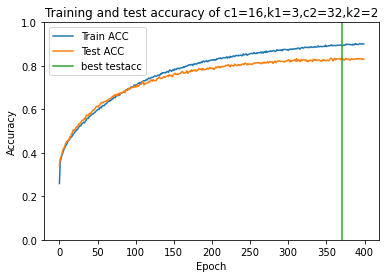

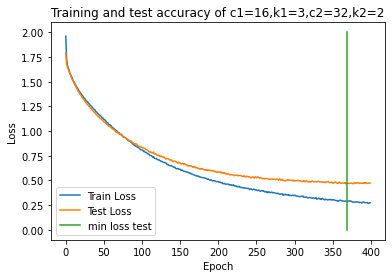

In [348]:
# best model acc and loss curve
best_epoch=np.argmax(myresult[1].history['val_accuracy'])
min_loss=np.argmin(myresult[1].history['val_loss'])
train_acc=myresult[1].history['accuracy']
test_acc=myresult[1].history['val_accuracy']
train_loss=myresult[1].history['loss']
test_loss=myresult[1].history['val_loss']
plt.plot(train_acc)
plt.plot(test_acc)
plt.plot([best_epoch,best_epoch],[0,1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train ACC', 'Test ACC','best testacc'])
plt.title("Training and test accuracy of c1=16,k1=3,c2=32,k2=2")
plt.show()

plt.plot(train_loss)
plt.plot(test_loss)
plt.plot([min_loss,min_loss],[0,2])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss','Test Loss','min loss test'])
plt.title("Training and test accuracy of c1=16,k1=3,c2=32,k2=2")
plt.show()     

# PCA on Zn   99%to get R value

In [350]:
model1.layers

In [351]:
model_f=tf.keras.Model(inputs=model1.input,outputs=model1.layers[5].output)
z=model_f.predict(x)
z.shape

786/786 [==============================] - 1s 1ms/step


(25136, 512)

In [353]:
model_f.summary()

Model: "model_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_133 (InputLayer)      [(None, 20, 20, 1)]       0         
                                                                 
 conv2d_264 (Conv2D)         (None, 18, 18, 16)        160       
                                                                 
 max_pooling2d_264 (MaxPooli  (None, 9, 9, 16)         0         
 ng2D)                                                           
                                                                 
 conv2d_265 (Conv2D)         (None, 8, 8, 32)          2080      
                                                                 
 max_pooling2d_265 (MaxPooli  (None, 4, 4, 32)         0         
 ng2D)                                                           
                                                                 
 flatten_132 (Flatten)       (None, 512)               0 

In [356]:
x.shape

(25136, 20, 20, 1)

In [357]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(z)
cumu_exp_var=np.cumsum(pca.explained_variance_ratio_)
R=np.argmax(cumu_exp_var>=0.99)
R

427

# compare performance for best model with h=R and h=2R, r=427

Epoch 1/400
189/189 [==============================] - 3s 16ms/step - loss: 1.9670 - accuracy: 0.2567 - val_loss: 1.7818 - val_accuracy: 0.3461
Epoch 2/400
189/189 [==============================] - 3s 15ms/step - loss: 1.7212 - accuracy: 0.3564 - val_loss: 1.6812 - val_accuracy: 0.3687
Epoch 3/400
189/189 [==============================] - 3s 15ms/step - loss: 1.6635 - accuracy: 0.3782 - val_loss: 1.6439 - val_accuracy: 0.3775
Epoch 4/400
189/189 [==============================] - 3s 15ms/step - loss: 1.6325 - accuracy: 0.3834 - val_loss: 1.6152 - val_accuracy: 0.3918
Epoch 5/400
189/189 [==============================] - 3s 15ms/step - loss: 1.6040 - accuracy: 0.3982 - val_loss: 1.5897 - val_accuracy: 0.4125
Epoch 6/400
189/189 [==============================] - 3s 15ms/step - loss: 1.5768 - accuracy: 0.4110 - val_loss: 1.5594 - val_accuracy: 0.4193
Epoch 7/400
189/189 [==============================] - 3s 15ms/step - loss: 1.5532 - accuracy: 0.4197 - val_loss: 1.5358 - val_accuracy:

189/189 [==============================] - 3s 15ms/step - loss: 0.5892 - accuracy: 0.7931 - val_loss: 0.6336 - val_accuracy: 0.7788
Epoch 114/400
189/189 [==============================] - 3s 15ms/step - loss: 0.5882 - accuracy: 0.7925 - val_loss: 0.6238 - val_accuracy: 0.7792
Epoch 115/400
189/189 [==============================] - 3s 15ms/step - loss: 0.5811 - accuracy: 0.7969 - val_loss: 0.6259 - val_accuracy: 0.7768
Epoch 116/400
189/189 [==============================] - 3s 15ms/step - loss: 0.5811 - accuracy: 0.7962 - val_loss: 0.6363 - val_accuracy: 0.7677
Epoch 117/400
189/189 [==============================] - 3s 15ms/step - loss: 0.5739 - accuracy: 0.7952 - val_loss: 0.6198 - val_accuracy: 0.7832
Epoch 118/400
189/189 [==============================] - 3s 15ms/step - loss: 0.5655 - accuracy: 0.7994 - val_loss: 0.6193 - val_accuracy: 0.7780
Epoch 119/400
189/189 [==============================] - 3s 15ms/step - loss: 0.5685 - accuracy: 0.7976 - val_loss: 0.6223 - val_accuracy:

189/189 [==============================] - 3s 15ms/step - loss: 0.3063 - accuracy: 0.8931 - val_loss: 0.4474 - val_accuracy: 0.8389
Epoch 226/400
189/189 [==============================] - 3s 15ms/step - loss: 0.3059 - accuracy: 0.8913 - val_loss: 0.4440 - val_accuracy: 0.8477
Epoch 227/400
189/189 [==============================] - 3s 15ms/step - loss: 0.3010 - accuracy: 0.8948 - val_loss: 0.4486 - val_accuracy: 0.8389
Epoch 228/400
189/189 [==============================] - 3s 15ms/step - loss: 0.3054 - accuracy: 0.8924 - val_loss: 0.4446 - val_accuracy: 0.8401
Epoch 229/400
189/189 [==============================] - 3s 15ms/step - loss: 0.3035 - accuracy: 0.8924 - val_loss: 0.4491 - val_accuracy: 0.8417
Epoch 230/400
189/189 [==============================] - 3s 15ms/step - loss: 0.2985 - accuracy: 0.8937 - val_loss: 0.4587 - val_accuracy: 0.8333
Epoch 231/400
189/189 [==============================] - 3s 15ms/step - loss: 0.2978 - accuracy: 0.8915 - val_loss: 0.4473 - val_accuracy:

189/189 [==============================] - 3s 15ms/step - loss: 0.2064 - accuracy: 0.9272 - val_loss: 0.4317 - val_accuracy: 0.8524
Epoch 338/400
189/189 [==============================] - 3s 15ms/step - loss: 0.2061 - accuracy: 0.9268 - val_loss: 0.4242 - val_accuracy: 0.8552
Epoch 339/400
189/189 [==============================] - 3s 15ms/step - loss: 0.2065 - accuracy: 0.9269 - val_loss: 0.4146 - val_accuracy: 0.8600
Epoch 340/400
189/189 [==============================] - 3s 15ms/step - loss: 0.2041 - accuracy: 0.9267 - val_loss: 0.4181 - val_accuracy: 0.8532
Epoch 341/400
189/189 [==============================] - 3s 15ms/step - loss: 0.2051 - accuracy: 0.9272 - val_loss: 0.4238 - val_accuracy: 0.8564
Epoch 342/400
189/189 [==============================] - 3s 15ms/step - loss: 0.2064 - accuracy: 0.9258 - val_loss: 0.4215 - val_accuracy: 0.8572
Epoch 343/400
189/189 [==============================] - 3s 15ms/step - loss: 0.2045 - accuracy: 0.9277 - val_loss: 0.4161 - val_accuracy:

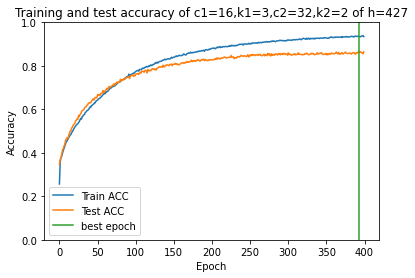

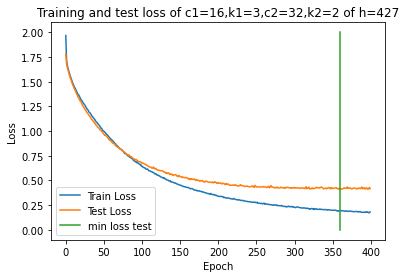

Epoch 1/400
189/189 [==============================] - 4s 17ms/step - loss: 1.8974 - accuracy: 0.2960 - val_loss: 1.6990 - val_accuracy: 0.3771
Epoch 2/400
189/189 [==============================] - 3s 17ms/step - loss: 1.6608 - accuracy: 0.3823 - val_loss: 1.6200 - val_accuracy: 0.3946
Epoch 3/400
189/189 [==============================] - 3s 17ms/step - loss: 1.6040 - accuracy: 0.4055 - val_loss: 1.5747 - val_accuracy: 0.4193
Epoch 4/400
189/189 [==============================] - 3s 17ms/step - loss: 1.5686 - accuracy: 0.4184 - val_loss: 1.5465 - val_accuracy: 0.4204
Epoch 5/400
189/189 [==============================] - 3s 17ms/step - loss: 1.5370 - accuracy: 0.4354 - val_loss: 1.5148 - val_accuracy: 0.4431
Epoch 6/400
189/189 [==============================] - 3s 17ms/step - loss: 1.5078 - accuracy: 0.4489 - val_loss: 1.4827 - val_accuracy: 0.4562
Epoch 7/400
189/189 [==============================] - 3s 17ms/step - loss: 1.4829 - accuracy: 0.4565 - val_loss: 1.4551 - val_accuracy:

189/189 [==============================] - 3s 17ms/step - loss: 0.4306 - accuracy: 0.8495 - val_loss: 0.5376 - val_accuracy: 0.8099
Epoch 114/400
189/189 [==============================] - 3s 17ms/step - loss: 0.4271 - accuracy: 0.8501 - val_loss: 0.5285 - val_accuracy: 0.8103
Epoch 115/400
189/189 [==============================] - 3s 17ms/step - loss: 0.4279 - accuracy: 0.8491 - val_loss: 0.5330 - val_accuracy: 0.8194
Epoch 116/400
189/189 [==============================] - 3s 17ms/step - loss: 0.4183 - accuracy: 0.8516 - val_loss: 0.5294 - val_accuracy: 0.8182
Epoch 117/400
189/189 [==============================] - 3s 17ms/step - loss: 0.4189 - accuracy: 0.8493 - val_loss: 0.5239 - val_accuracy: 0.8170
Epoch 118/400
189/189 [==============================] - 3s 17ms/step - loss: 0.4153 - accuracy: 0.8538 - val_loss: 0.5234 - val_accuracy: 0.8158
Epoch 119/400
189/189 [==============================] - 3s 17ms/step - loss: 0.4095 - accuracy: 0.8550 - val_loss: 0.5240 - val_accuracy:

189/189 [==============================] - 3s 17ms/step - loss: 0.2076 - accuracy: 0.9266 - val_loss: 0.4229 - val_accuracy: 0.8556
Epoch 226/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2080 - accuracy: 0.9266 - val_loss: 0.4257 - val_accuracy: 0.8532
Epoch 227/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2137 - accuracy: 0.9226 - val_loss: 0.4156 - val_accuracy: 0.8600
Epoch 228/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2120 - accuracy: 0.9241 - val_loss: 0.4158 - val_accuracy: 0.8576
Epoch 229/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2073 - accuracy: 0.9280 - val_loss: 0.4092 - val_accuracy: 0.8572
Epoch 230/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2040 - accuracy: 0.9255 - val_loss: 0.4210 - val_accuracy: 0.8576
Epoch 231/400
189/189 [==============================] - 3s 17ms/step - loss: 0.2041 - accuracy: 0.9277 - val_loss: 0.4177 - val_accuracy:

189/189 [==============================] - 3s 17ms/step - loss: 0.1414 - accuracy: 0.9494 - val_loss: 0.4138 - val_accuracy: 0.8656
Epoch 338/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1353 - accuracy: 0.9500 - val_loss: 0.4203 - val_accuracy: 0.8691
Epoch 339/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1418 - accuracy: 0.9490 - val_loss: 0.4070 - val_accuracy: 0.8727
Epoch 340/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1418 - accuracy: 0.9492 - val_loss: 0.4157 - val_accuracy: 0.8624
Epoch 341/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1380 - accuracy: 0.9512 - val_loss: 0.4078 - val_accuracy: 0.8675
Epoch 342/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1369 - accuracy: 0.9511 - val_loss: 0.4251 - val_accuracy: 0.8616
Epoch 343/400
189/189 [==============================] - 3s 17ms/step - loss: 0.1364 - accuracy: 0.9517 - val_loss: 0.4082 - val_accuracy:

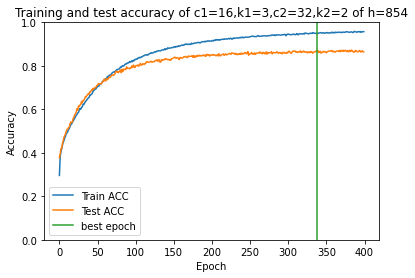

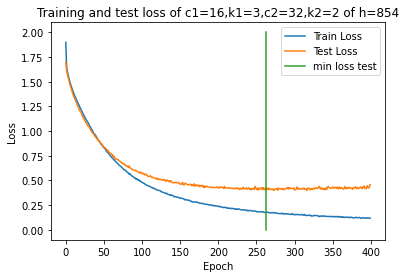

In [380]:
total_params3=[]
parsimony_ratio3=[]
max_train_acc_list3=[]
max_test_acc_list3=[]
cpu_list=[]

R=[427,854]

for r in R:
    myresult3=module(16,3,32,2,r,0.0001,400)
    
    pickle.dump(myresult3, open("E:/Dropbox/Yi/results_54pm_r2r/Training and test accuracy of h={0}.pickle".format(r), "wb" ))
           
    frame=myresult3[0].summary
    cpu=myresult3[2]
    cpu_list.append(cpu)

    total_p3=myresult3[0].count_params()  # model total parameters
    total_params3.append(total_p3)

    pr3=(x_train.shape[0]*8)/total_p3  #parsimoni ratio
    parsimony_ratio3.append(pr3)


    max_train_acc3=max(myresult3[1].history['accuracy']) # best train acc and best acc index
    max_train_acc_list3.append(max_train_acc3)

    max_test_acc3=max(myresult3[1].history['val_accuracy']) # best test acc and best acc index
    max_test_acc_list3.append(max_test_acc3)

    best_epoch=np.argmax(myresult3[1].history['val_accuracy'])
    min_loss=np.argmin(myresult3[1].history['val_loss'])

    
    plt.plot(myresult3[1].history['accuracy'])
    plt.plot(myresult3[1].history['val_accuracy'])
    plt.plot([best_epoch,best_epoch],[0,1])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0,1)
    plt.legend(['Train ACC', 'Test ACC','best epoch'])
    plt.title("Training and test accuracy of c1=16,k1=3,c2=32,k2=2 of h={0}".format(r))
    plt.savefig("results_54pm_r2r/Training and test accuracy of c1=16,k1=3,c2=32,k2=2 of h={0}.jpg".format(r),dpi=400)
    plt.show()
    
    plt.plot(myresult3[1].history['loss'])
    plt.plot(myresult3[1].history['val_loss'])
    plt.plot([min_loss,min_loss],[0,2])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss','Test Loss','min loss test'])
    plt.title("Training and test loss of c1=16,k1=3,c2=32,k2=2 of h={0}".format(r))
    plt.savefig("results_54pm_r2r/Training and test loss of c1=16,k1=3,c2=32,k2=2 of h={0}.jpg".format(r),dpi=400)
    plt.show()              

In [384]:
results_df3=pd.DataFrame({'hidden_layer_size':R,
                        'total_parameters':total_params3,
                        'parsimony_ratio':parsimony_ratio3,
                          'cpu':cpu_list,
                         'best train acc':max_train_acc_list3,
                         'best test acc':max_test_acc_list3})
results_df3.to_csv('results_54pm_r2r/results_54pm_r2r.csv')
results_df3

,hidden_layer_size,total_parameters,parsimony_ratio,cpu,best train acc,best test acc
0,427,224715,0.805358,1143.7692,0.939351,0.867542
1,854,447182,0.404703,1275.2873,0.958713,0.872713


In [387]:
worst_coeff_r2r(427)

79/79 [==============================] - 0s 3ms/step


0.1088

In [388]:
worst_coeff_r2r(854)

79/79 [==============================] - 0s 2ms/step


0.1302

# 2 classes analysis with new CNN classifier

In [ ]:
confusion_for_model(16,3,32,2)

In [22]:
#class2 and class 6 have highest coefficient (Index(['CANDARA', 'CONSTANTIA', 'CORBEL', 'GABRIOLA', 'IMPACT', 'ITALIC','ROCKWELL', 'SYLFAEN'],
class2=dfs[dfs['font']=='CONSTANTIA']
class6=dfs[dfs['font']=='ITALIC']
df2=pd.concat([class2,class6])
df2.shape

(6730, 401)

In [23]:
df2

,font,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,CONSTANTIA,1,1,1,1,47,155,255,255,255,...,255,219,132,1,92,219,255,255,220,136
1,CONSTANTIA,1,1,1,1,47,155,255,255,232,...,255,219,132,1,92,219,255,255,220,136
2,CONSTANTIA,1,1,1,1,1,1,1,46,140,...,1,79,209,231,255,255,255,223,200,105
3,CONSTANTIA,1,1,1,1,1,1,1,21,84,...,1,79,209,231,255,255,255,223,200,105
4,CONSTANTIA,1,1,1,1,1,47,151,231,255,...,226,255,255,238,198,78,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,ITALIC,1,1,1,1,1,1,71,214,255,...,236,222,181,71,1,1,1,1,1,1
3708,ITALIC,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3709,ITALIC,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3710,ITALIC,0,0,0,0,0,0,192,255,32,...,0,32,255,192,0,0,0,0,0,0


In [24]:
x2=df2.iloc[:,df2.columns.str.startswith('r')].values #df.values converts df into numpy,remove axis
x2.shape
x2=x2.reshape(-1,20,20)
x2.shape
x2.min(),x2.max()

(0, 255)

In [25]:
df2y=pd.get_dummies(df2['font'])
df2y
y2=df2y.values
y2.shape

(6730, 2)

In [26]:
x2=x2[...,np.newaxis]/255
x2.min(),x2.max()

(0.0, 1.0)

In [27]:
x_train2,x_test2,y_train2,y_test2=train_test_split(x2,y2,test_size=0.1,random_state=1)
x_train2.shape,x_test2.shape,y_train2.shape,y_test2.shape

((6057, 20, 20, 1), (673, 20, 20, 1), (6057, 2), (673, 2))

In [29]:
# model for only 2 classes 
def module2(c1,k1,c2,k2,hidden,lrate,epochs):
    inputs=keras.layers.Input(shape=(20,20,1))
    conv1=layers.Conv2D(c1,k1,activation='relu')(inputs)
    pool1=layers.MaxPooling2D((2,2))(conv1)
    conv2=layers.Conv2D(c2,k2,activation='relu')(pool1)
    pool2=layers.MaxPooling2D((2,2))(conv2)
    flat=layers.Flatten()(pool2)
    drop=layers.Dropout(0.25)(flat)
    dense1=layers.Dense(hidden,activation='relu')(drop)
    outputs=layers.Dense(2,activation='softmax')(dense1)
    model=keras.Model(inputs=inputs,outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    history=model.fit(x_train2,y_train2,validation_data=(x_test2,y_test2),batch_size=120,epochs=epochs) 
    return(model,history)

In [30]:
myresult_2class=module2(16,3,32,2,hidden(16,3,32,2),0.001,200)

Epoch 1/200
51/51 [==============================] - 4s 43ms/step - loss: 0.4480 - accuracy: 0.8087 - val_loss: 0.3125 - val_accuracy: 0.8811
Epoch 2/200
51/51 [==============================] - 2s 35ms/step - loss: 0.3021 - accuracy: 0.8793 - val_loss: 0.2943 - val_accuracy: 0.8841
Epoch 3/200
51/51 [==============================] - 2s 34ms/step - loss: 0.2671 - accuracy: 0.8905 - val_loss: 0.2720 - val_accuracy: 0.8975
Epoch 4/200
51/51 [==============================] - 2s 39ms/step - loss: 0.2399 - accuracy: 0.9064 - val_loss: 0.2286 - val_accuracy: 0.9079
Epoch 5/200
51/51 [==============================] - 2s 36ms/step - loss: 0.2169 - accuracy: 0.9173 - val_loss: 0.2243 - val_accuracy: 0.9049
Epoch 6/200
51/51 [==============================] - 2s 35ms/step - loss: 0.2092 - accuracy: 0.9211 - val_loss: 0.2018 - val_accuracy: 0.9212
Epoch 7/200
51/51 [==============================] - 2s 37ms/step - loss: 0.1893 - accuracy: 0.9257 - val_loss: 0.1891 - val_accuracy: 0.9272
Epoch 

51/51 [==============================] - 2s 36ms/step - loss: 0.0122 - accuracy: 0.9946 - val_loss: 0.0257 - val_accuracy: 0.9866
Epoch 116/200
51/51 [==============================] - 2s 37ms/step - loss: 0.0132 - accuracy: 0.9944 - val_loss: 0.0348 - val_accuracy: 0.9866
Epoch 117/200
51/51 [==============================] - 2s 37ms/step - loss: 0.0110 - accuracy: 0.9952 - val_loss: 0.0343 - val_accuracy: 0.9851
Epoch 118/200
51/51 [==============================] - 2s 37ms/step - loss: 0.0094 - accuracy: 0.9959 - val_loss: 0.0279 - val_accuracy: 0.9896
Epoch 119/200
51/51 [==============================] - 2s 37ms/step - loss: 0.0085 - accuracy: 0.9954 - val_loss: 0.0424 - val_accuracy: 0.9837
Epoch 120/200
51/51 [==============================] - 2s 36ms/step - loss: 0.0089 - accuracy: 0.9959 - val_loss: 0.0356 - val_accuracy: 0.9866
Epoch 121/200
51/51 [==============================] - 2s 36ms/step - loss: 0.0082 - accuracy: 0.9962 - val_loss: 0.0361 - val_accuracy: 0.9851
Epoch 

Epoch 172/200
51/51 [==============================] - 2s 36ms/step - loss: 0.0082 - accuracy: 0.9960 - val_loss: 0.0349 - val_accuracy: 0.9807
Epoch 173/200
51/51 [==============================] - 2s 37ms/step - loss: 0.0091 - accuracy: 0.9957 - val_loss: 0.0493 - val_accuracy: 0.9881
Epoch 174/200
51/51 [==============================] - 2s 39ms/step - loss: 0.0095 - accuracy: 0.9955 - val_loss: 0.0409 - val_accuracy: 0.9866
Epoch 175/200
51/51 [==============================] - 2s 38ms/step - loss: 0.0104 - accuracy: 0.9952 - val_loss: 0.0428 - val_accuracy: 0.9851
Epoch 176/200
51/51 [==============================] - 2s 39ms/step - loss: 0.0089 - accuracy: 0.9959 - val_loss: 0.0551 - val_accuracy: 0.9807
Epoch 177/200
51/51 [==============================] - 2s 37ms/step - loss: 0.0107 - accuracy: 0.9947 - val_loss: 0.0561 - val_accuracy: 0.9792
Epoch 178/200
51/51 [==============================] - 2s 39ms/step - loss: 0.0101 - accuracy: 0.9957 - val_loss: 0.0488 - val_accuracy:

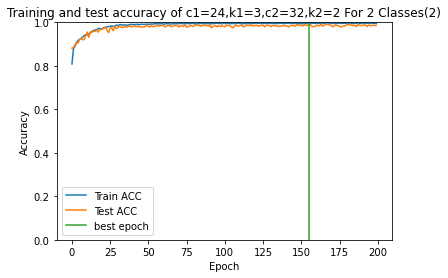

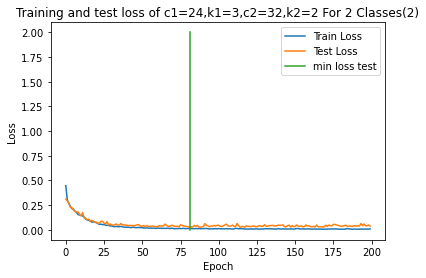

In [31]:
# acc and loss binary classifier
best_epoch=np.argmax(myresult_2class[1].history['val_accuracy'])
min_loss=np.argmin(myresult_2class[1].history['val_loss'])

train_acc2=myresult_2class[1].history['accuracy']
test_acc2=myresult_2class[1].history['val_accuracy']
train_loss2=myresult_2class[1].history['loss']
test_loss2=myresult_2class[1].history['val_loss']

plt.plot(train_acc2)
plt.plot(test_acc2)
plt.plot([best_epoch,best_epoch],[0,1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train ACC', 'Test ACC','best epoch'])
plt.title("Training and test accuracy of c1=24,k1=3,c2=32,k2=2 For 2 Classes(2)")
plt.savefig("Training and test accuracy of c1=24,k1=3,c2=32,k2=2 For 2 Classes(2).jpg",dpi=400)
plt.show()

plt.plot(train_loss2)
plt.plot(test_loss2)
plt.plot([min_loss,min_loss],[0,2])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss','Test Loss','min loss test'])
plt.title("Training and test loss of c1=24,k1=3,c2=32,k2=2 For 2 Classes(2)")
plt.savefig("Training and test loss of c1=24,k1=3,c2=32,k2=2 For 2 Classes(2).jpg",dpi=400)
plt.show()    

In [32]:
myresult_2class[0].evaluate(x_test2,y_test2)

22/22 [==============================] - 0s 7ms/step - loss: 0.0386 - accuracy: 0.9866


[0.0385814867913723, 0.9866270422935486]

In [33]:
pd.DataFrame(myresult_2class[1].history)

,loss,accuracy,val_loss,val_accuracy
0,0.448017,0.808651,0.312516,0.881129
1,0.302057,0.879313,0.294307,0.884101
2,0.267060,0.890540,0.272000,0.897474
3,0.239874,0.906389,0.228608,0.907875
4,0.216875,0.917286,0.224349,0.904903
...,...,...,...,...
195,0.008457,0.996038,0.059848,0.985141
196,0.007431,0.996368,0.042022,0.985141
197,0.007792,0.995873,0.042253,0.986627
198,0.008682,0.995873,0.049614,0.985141


In [36]:
#confusion matirx for 2 classes 
y_test2_pred=myresult_2class[0].predict(x_test2)
y_test2_pred
ind=np.argmax(y_test2_pred,axis=1)
y_test2_pred2=np.eye(2)[ind]
y_test2_pred2
cm1=cm(y_test2_pred2.argmax(axis=1),y_test2.argmax(axis=1))
cm1
value,count=np.unique(y_test2_pred2.argmax(axis=1),return_counts=True)
value,count
cm2=(cm1/count).round(4)
cm2

22/22 [==============================] - 0s 6ms/step


array([[0.9777, 0.0195],
       [0.0064, 0.9944]])

# ROC and AUC 

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [41]:
#probability list a
a_list=[i/50 for i in range (0,51)]

prob_list=[]
for a in a_list:
    y2_pred=myresult_2class[0].predict(x_test2)
    pro_y2_pred=(y2_pred[:,0]>a).astype(int)    # first column of prediction is pro of class1, if >a, true assign 1,false assign 0
    prob_list.append(pro_y2_pred)

22/22 [==============================] - 0s 7ms/step


In [42]:
cm51=[]
for p in prob_list:
    cms=cm(y_test2.argmax(axis=1),p)
    cm51.append(cms)
    

In [43]:
tpr_list=[]
fpr_list=[]
for cms in cm51:
    tn,fp,fn,tp=np.ravel(cms)     # class1 is positive, class2 is negtive. tp + fn= total true positive ; tn+fp=total neg
    tpr=tp/(tp+fn)
    fpr=fp/(fp+tn)
    tpr_list.append(tpr)
    fpr_list.append(fpr)

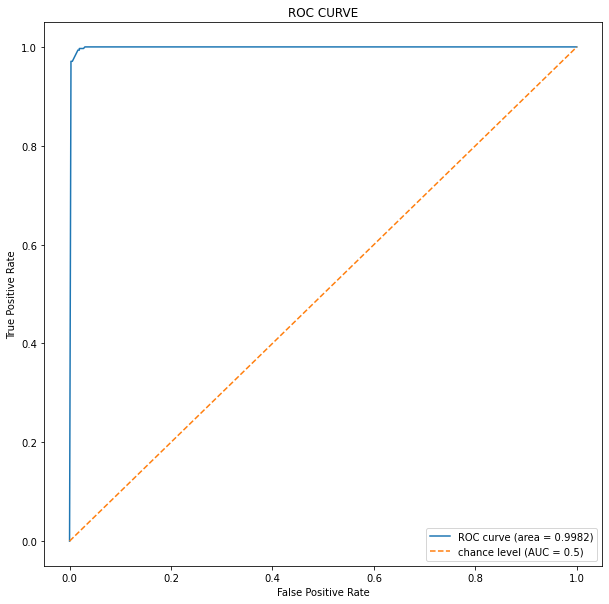

In [46]:
roc_auc = auc(tpr_list,fpr_list)
plt.subplots(1, figsize=(10,10))
plt.plot(tpr_list,fpr_list, label='ROC curve (area = %0.4f)' % roc_auc)
plt.title('ROC CURVE')
plt.plot([0, 1],[0,1], ls="--", label="chance level (AUC = 0.5)")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.savefig('ROC Curve and AUC.jpg',dpi=400)
plt.show()

In [45]:
roc_auc

0.9982396244532168

# 5.1 change random train set and relaunch automatic learning.

In [22]:
# use k -fold cross validation to 
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)

i=1
for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    myresult=module(16,3,32,2,hidden(16,3,32,2),0.0001,400)
    pickle.dump(myresult, open("E:/Dropbox/Yi/results_56_rdtrain/Training and test accuracy of random model{0}.pickle".format(i), "wb" ))

Epoch 1/400
168/168 [==============================] - 2s 8ms/step - loss: 1.9944 - accuracy: 0.2319 - val_loss: 1.8131 - val_accuracy: 0.3347
Epoch 2/400
168/168 [==============================] - 1s 7ms/step - loss: 1.7402 - accuracy: 0.3498 - val_loss: 1.6850 - val_accuracy: 0.3586
Epoch 3/400
168/168 [==============================] - 1s 7ms/step - loss: 1.6755 - accuracy: 0.3678 - val_loss: 1.6546 - val_accuracy: 0.3689
Epoch 4/400
168/168 [==============================] - 1s 7ms/step - loss: 1.6418 - accuracy: 0.3871 - val_loss: 1.6287 - val_accuracy: 0.3910
Epoch 5/400
168/168 [==============================] - 1s 7ms/step - loss: 1.6155 - accuracy: 0.3945 - val_loss: 1.6123 - val_accuracy: 0.3886
Epoch 6/400
168/168 [==============================] - 1s 7ms/step - loss: 1.5928 - accuracy: 0.4074 - val_loss: 1.5894 - val_accuracy: 0.4079
Epoch 7/400
168/168 [==============================] - 1s 7ms/step - loss: 1.5726 - accuracy: 0.4121 - val_loss: 1.5653 - val_accuracy: 0.4189

Epoch 58/400
168/168 [==============================] - 1s 8ms/step - loss: 1.0464 - accuracy: 0.6208 - val_loss: 1.0410 - val_accuracy: 0.6329
Epoch 59/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0362 - accuracy: 0.6247 - val_loss: 1.0293 - val_accuracy: 0.6394
Epoch 60/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0306 - accuracy: 0.6282 - val_loss: 1.0204 - val_accuracy: 0.6414
Epoch 61/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0221 - accuracy: 0.6311 - val_loss: 1.0172 - val_accuracy: 0.6434
Epoch 62/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0169 - accuracy: 0.6344 - val_loss: 1.0087 - val_accuracy: 0.6450
Epoch 63/400
168/168 [==============================] - 1s 8ms/step - loss: 1.0085 - accuracy: 0.6335 - val_loss: 1.0018 - val_accuracy: 0.6494
Epoch 64/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0021 - accuracy: 0.6382 - val_loss: 1.0008 - val_accuracy:

Epoch 115/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7335 - accuracy: 0.7383 - val_loss: 0.7852 - val_accuracy: 0.7237
Epoch 116/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7252 - accuracy: 0.7409 - val_loss: 0.7766 - val_accuracy: 0.7279
Epoch 117/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7243 - accuracy: 0.7428 - val_loss: 0.7757 - val_accuracy: 0.7267
Epoch 118/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7124 - accuracy: 0.7441 - val_loss: 0.7733 - val_accuracy: 0.7295
Epoch 119/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7126 - accuracy: 0.7471 - val_loss: 0.7670 - val_accuracy: 0.7325
Epoch 120/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7094 - accuracy: 0.7460 - val_loss: 0.7696 - val_accuracy: 0.7307
Epoch 121/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7042 - accuracy: 0.7479 - val_loss: 0.7692 - val_ac

168/168 [==============================] - 1s 7ms/step - loss: 0.4424 - accuracy: 0.8418 - val_loss: 0.5975 - val_accuracy: 0.7932
Epoch 228/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4439 - accuracy: 0.8409 - val_loss: 0.5936 - val_accuracy: 0.7918
Epoch 229/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4437 - accuracy: 0.8391 - val_loss: 0.5921 - val_accuracy: 0.7957
Epoch 230/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4355 - accuracy: 0.8421 - val_loss: 0.5862 - val_accuracy: 0.7930
Epoch 231/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4372 - accuracy: 0.8418 - val_loss: 0.5880 - val_accuracy: 0.7896
Epoch 232/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4382 - accuracy: 0.8439 - val_loss: 0.5932 - val_accuracy: 0.7910
Epoch 233/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4309 - accuracy: 0.8454 - val_loss: 0.5914 - val_accuracy: 0.7951

168/168 [==============================] - 1s 7ms/step - loss: 0.3107 - accuracy: 0.8877 - val_loss: 0.5397 - val_accuracy: 0.8202
Epoch 340/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3080 - accuracy: 0.8899 - val_loss: 0.5421 - val_accuracy: 0.8254
Epoch 341/400
168/168 [==============================] - 1s 8ms/step - loss: 0.3084 - accuracy: 0.8903 - val_loss: 0.5394 - val_accuracy: 0.8202
Epoch 342/400
168/168 [==============================] - 1s 8ms/step - loss: 0.3063 - accuracy: 0.8885 - val_loss: 0.5445 - val_accuracy: 0.8202
Epoch 343/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3115 - accuracy: 0.8887 - val_loss: 0.5411 - val_accuracy: 0.8206
Epoch 344/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3041 - accuracy: 0.8921 - val_loss: 0.5351 - val_accuracy: 0.8216
Epoch 345/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3070 - accuracy: 0.8897 - val_loss: 0.5415 - val_accuracy: 0.8228

168/168 [==============================] - 1s 7ms/step - loss: 1.1095 - accuracy: 0.5968 - val_loss: 1.0375 - val_accuracy: 0.6386
Epoch 53/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1025 - accuracy: 0.6034 - val_loss: 1.0333 - val_accuracy: 0.6352
Epoch 54/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0916 - accuracy: 0.6059 - val_loss: 1.0239 - val_accuracy: 0.6378
Epoch 55/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0830 - accuracy: 0.6086 - val_loss: 1.0172 - val_accuracy: 0.6435
Epoch 56/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0831 - accuracy: 0.6065 - val_loss: 1.0080 - val_accuracy: 0.6493
Epoch 57/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0745 - accuracy: 0.6128 - val_loss: 1.0087 - val_accuracy: 0.6409
Epoch 58/400
168/168 [==============================] - 1s 7ms/step - loss: 1.0644 - accuracy: 0.6157 - val_loss: 0.9975 - val_accuracy: 0.6515
Epoch

Epoch 109/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7701 - accuracy: 0.7272 - val_loss: 0.7554 - val_accuracy: 0.7313
Epoch 110/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7677 - accuracy: 0.7242 - val_loss: 0.7532 - val_accuracy: 0.7374
Epoch 111/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7670 - accuracy: 0.7245 - val_loss: 0.7497 - val_accuracy: 0.7368
Epoch 112/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7607 - accuracy: 0.7279 - val_loss: 0.7481 - val_accuracy: 0.7322
Epoch 113/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7561 - accuracy: 0.7328 - val_loss: 0.7466 - val_accuracy: 0.7350
Epoch 114/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7524 - accuracy: 0.7302 - val_loss: 0.7433 - val_accuracy: 0.7416
Epoch 115/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7414 - accuracy: 0.7354 - val_loss: 0.7370 - val_ac

168/168 [==============================] - 1s 7ms/step - loss: 0.4465 - accuracy: 0.8395 - val_loss: 0.5397 - val_accuracy: 0.8102
Epoch 222/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4475 - accuracy: 0.8368 - val_loss: 0.5471 - val_accuracy: 0.8076
Epoch 223/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4475 - accuracy: 0.8394 - val_loss: 0.5403 - val_accuracy: 0.8140
Epoch 224/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4408 - accuracy: 0.8442 - val_loss: 0.5388 - val_accuracy: 0.8114
Epoch 225/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4428 - accuracy: 0.8394 - val_loss: 0.5359 - val_accuracy: 0.8122
Epoch 226/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4353 - accuracy: 0.8448 - val_loss: 0.5380 - val_accuracy: 0.8128
Epoch 227/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4360 - accuracy: 0.8448 - val_loss: 0.5379 - val_accuracy: 0.8134

168/168 [==============================] - 1s 7ms/step - loss: 0.3131 - accuracy: 0.8878 - val_loss: 0.4872 - val_accuracy: 0.8313
Epoch 334/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3091 - accuracy: 0.8903 - val_loss: 0.4891 - val_accuracy: 0.8355
Epoch 335/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3069 - accuracy: 0.8895 - val_loss: 0.4860 - val_accuracy: 0.8309
Epoch 336/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3099 - accuracy: 0.8864 - val_loss: 0.4866 - val_accuracy: 0.8331
Epoch 337/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3100 - accuracy: 0.8883 - val_loss: 0.4887 - val_accuracy: 0.8323
Epoch 338/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3034 - accuracy: 0.8894 - val_loss: 0.4844 - val_accuracy: 0.8333
Epoch 339/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3049 - accuracy: 0.8903 - val_loss: 0.4921 - val_accuracy: 0.8327

Epoch 46/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1491 - accuracy: 0.5870 - val_loss: 1.1135 - val_accuracy: 0.6033
Epoch 47/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1439 - accuracy: 0.5884 - val_loss: 1.1061 - val_accuracy: 0.6061
Epoch 48/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1362 - accuracy: 0.5914 - val_loss: 1.1000 - val_accuracy: 0.6111
Epoch 49/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1259 - accuracy: 0.5928 - val_loss: 1.0913 - val_accuracy: 0.6099
Epoch 50/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1212 - accuracy: 0.5965 - val_loss: 1.0858 - val_accuracy: 0.6151
Epoch 51/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1086 - accuracy: 0.6032 - val_loss: 1.0759 - val_accuracy: 0.6191
Epoch 52/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1026 - accuracy: 0.6023 - val_loss: 1.0697 - val_accuracy:

Epoch 103/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7852 - accuracy: 0.7198 - val_loss: 0.8260 - val_accuracy: 0.7139
Epoch 104/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7809 - accuracy: 0.7182 - val_loss: 0.8245 - val_accuracy: 0.7114
Epoch 105/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7798 - accuracy: 0.7223 - val_loss: 0.8246 - val_accuracy: 0.7114
Epoch 106/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7737 - accuracy: 0.7218 - val_loss: 0.8170 - val_accuracy: 0.7173
Epoch 107/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7678 - accuracy: 0.7229 - val_loss: 0.8145 - val_accuracy: 0.7151
Epoch 108/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7641 - accuracy: 0.7299 - val_loss: 0.8089 - val_accuracy: 0.7239
Epoch 109/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7608 - accuracy: 0.7322 - val_loss: 0.8061 - val_ac

168/168 [==============================] - 1s 7ms/step - loss: 0.4471 - accuracy: 0.8414 - val_loss: 0.6190 - val_accuracy: 0.7897
Epoch 216/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4494 - accuracy: 0.8380 - val_loss: 0.6165 - val_accuracy: 0.7873
Epoch 217/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4523 - accuracy: 0.8351 - val_loss: 0.6184 - val_accuracy: 0.7864
Epoch 218/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4514 - accuracy: 0.8389 - val_loss: 0.6183 - val_accuracy: 0.7856
Epoch 219/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4456 - accuracy: 0.8410 - val_loss: 0.6098 - val_accuracy: 0.7893
Epoch 220/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4405 - accuracy: 0.8430 - val_loss: 0.6115 - val_accuracy: 0.7887
Epoch 221/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4420 - accuracy: 0.8435 - val_loss: 0.6125 - val_accuracy: 0.7887

168/168 [==============================] - 1s 7ms/step - loss: 0.3137 - accuracy: 0.8882 - val_loss: 0.5625 - val_accuracy: 0.8134
Epoch 328/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3131 - accuracy: 0.8876 - val_loss: 0.5655 - val_accuracy: 0.8090
Epoch 329/400
168/168 [==============================] - 1s 6ms/step - loss: 0.3126 - accuracy: 0.8889 - val_loss: 0.5604 - val_accuracy: 0.8130
Epoch 330/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3141 - accuracy: 0.8861 - val_loss: 0.5613 - val_accuracy: 0.8124
Epoch 331/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3103 - accuracy: 0.8858 - val_loss: 0.5623 - val_accuracy: 0.8130
Epoch 332/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3023 - accuracy: 0.8908 - val_loss: 0.5560 - val_accuracy: 0.8156
Epoch 333/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3091 - accuracy: 0.8896 - val_loss: 0.5586 - val_accuracy: 0.8138

Epoch 40/400
168/168 [==============================] - 1s 7ms/step - loss: 1.2029 - accuracy: 0.5622 - val_loss: 1.1596 - val_accuracy: 0.5904
Epoch 41/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1888 - accuracy: 0.5673 - val_loss: 1.1527 - val_accuracy: 0.5900
Epoch 42/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1840 - accuracy: 0.5745 - val_loss: 1.1430 - val_accuracy: 0.5974
Epoch 43/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1772 - accuracy: 0.5762 - val_loss: 1.1369 - val_accuracy: 0.5978
Epoch 44/400
168/168 [==============================] - 1s 6ms/step - loss: 1.1692 - accuracy: 0.5779 - val_loss: 1.1303 - val_accuracy: 0.6021
Epoch 45/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1608 - accuracy: 0.5832 - val_loss: 1.1220 - val_accuracy: 0.6073
Epoch 46/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1536 - accuracy: 0.5849 - val_loss: 1.1126 - val_accuracy:

Epoch 97/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8210 - accuracy: 0.7009 - val_loss: 0.8212 - val_accuracy: 0.7149
Epoch 98/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8164 - accuracy: 0.7082 - val_loss: 0.8205 - val_accuracy: 0.7147
Epoch 99/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8051 - accuracy: 0.7138 - val_loss: 0.8129 - val_accuracy: 0.7153
Epoch 100/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8021 - accuracy: 0.7091 - val_loss: 0.8140 - val_accuracy: 0.7167
Epoch 101/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7970 - accuracy: 0.7163 - val_loss: 0.8124 - val_accuracy: 0.7181
Epoch 102/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7851 - accuracy: 0.7176 - val_loss: 0.8037 - val_accuracy: 0.7169
Epoch 103/400
168/168 [==============================] - 1s 7ms/step - loss: 0.7916 - accuracy: 0.7177 - val_loss: 0.7974 - val_accur

168/168 [==============================] - 1s 7ms/step - loss: 0.4751 - accuracy: 0.8295 - val_loss: 0.5891 - val_accuracy: 0.7989
Epoch 210/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4658 - accuracy: 0.8338 - val_loss: 0.5958 - val_accuracy: 0.7961
Epoch 211/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4675 - accuracy: 0.8317 - val_loss: 0.5898 - val_accuracy: 0.8013
Epoch 212/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4648 - accuracy: 0.8355 - val_loss: 0.5845 - val_accuracy: 0.8011
Epoch 213/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4617 - accuracy: 0.8347 - val_loss: 0.5926 - val_accuracy: 0.7977
Epoch 214/400
168/168 [==============================] - 1s 6ms/step - loss: 0.4600 - accuracy: 0.8367 - val_loss: 0.5856 - val_accuracy: 0.7989
Epoch 215/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4608 - accuracy: 0.8342 - val_loss: 0.5853 - val_accuracy: 0.8009

168/168 [==============================] - 1s 6ms/step - loss: 0.3279 - accuracy: 0.8826 - val_loss: 0.5373 - val_accuracy: 0.8210
Epoch 322/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3268 - accuracy: 0.8794 - val_loss: 0.5362 - val_accuracy: 0.8228
Epoch 323/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3271 - accuracy: 0.8827 - val_loss: 0.5351 - val_accuracy: 0.8214
Epoch 324/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3282 - accuracy: 0.8820 - val_loss: 0.5410 - val_accuracy: 0.8228
Epoch 325/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3287 - accuracy: 0.8819 - val_loss: 0.5296 - val_accuracy: 0.8271
Epoch 326/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3262 - accuracy: 0.8819 - val_loss: 0.5305 - val_accuracy: 0.8226
Epoch 327/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3258 - accuracy: 0.8815 - val_loss: 0.5280 - val_accuracy: 0.8273

Epoch 34/400
168/168 [==============================] - 1s 7ms/step - loss: 1.2465 - accuracy: 0.5471 - val_loss: 1.2337 - val_accuracy: 0.5482
Epoch 35/400
168/168 [==============================] - 1s 7ms/step - loss: 1.2350 - accuracy: 0.5523 - val_loss: 1.2291 - val_accuracy: 0.5504
Epoch 36/400
168/168 [==============================] - 1s 7ms/step - loss: 1.2316 - accuracy: 0.5512 - val_loss: 1.2204 - val_accuracy: 0.5584
Epoch 37/400
168/168 [==============================] - 1s 6ms/step - loss: 1.2252 - accuracy: 0.5544 - val_loss: 1.2071 - val_accuracy: 0.5610
Epoch 38/400
168/168 [==============================] - 1s 7ms/step - loss: 1.2078 - accuracy: 0.5615 - val_loss: 1.2040 - val_accuracy: 0.5570
Epoch 39/400
168/168 [==============================] - 1s 7ms/step - loss: 1.2075 - accuracy: 0.5607 - val_loss: 1.1946 - val_accuracy: 0.5600
Epoch 40/400
168/168 [==============================] - 1s 7ms/step - loss: 1.1939 - accuracy: 0.5694 - val_loss: 1.1869 - val_accuracy:

Epoch 91/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8668 - accuracy: 0.6881 - val_loss: 0.9121 - val_accuracy: 0.6783
Epoch 92/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8584 - accuracy: 0.6931 - val_loss: 0.9048 - val_accuracy: 0.6783
Epoch 93/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8545 - accuracy: 0.6954 - val_loss: 0.9024 - val_accuracy: 0.6797
Epoch 94/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8527 - accuracy: 0.6932 - val_loss: 0.8932 - val_accuracy: 0.6799
Epoch 95/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8412 - accuracy: 0.6973 - val_loss: 0.8911 - val_accuracy: 0.6835
Epoch 96/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8368 - accuracy: 0.7006 - val_loss: 0.8865 - val_accuracy: 0.6813
Epoch 97/400
168/168 [==============================] - 1s 7ms/step - loss: 0.8363 - accuracy: 0.7002 - val_loss: 0.8840 - val_accuracy:

168/168 [==============================] - 1s 7ms/step - loss: 0.4901 - accuracy: 0.8237 - val_loss: 0.6502 - val_accuracy: 0.7788
Epoch 204/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4886 - accuracy: 0.8218 - val_loss: 0.6463 - val_accuracy: 0.7766
Epoch 205/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4906 - accuracy: 0.8226 - val_loss: 0.6484 - val_accuracy: 0.7722
Epoch 206/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4914 - accuracy: 0.8250 - val_loss: 0.6463 - val_accuracy: 0.7732
Epoch 207/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4935 - accuracy: 0.8230 - val_loss: 0.6458 - val_accuracy: 0.7732
Epoch 208/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4832 - accuracy: 0.8278 - val_loss: 0.6450 - val_accuracy: 0.7778
Epoch 209/400
168/168 [==============================] - 1s 7ms/step - loss: 0.4869 - accuracy: 0.8256 - val_loss: 0.6459 - val_accuracy: 0.7752

168/168 [==============================] - 1s 6ms/step - loss: 0.3414 - accuracy: 0.8758 - val_loss: 0.5738 - val_accuracy: 0.8082
Epoch 316/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3368 - accuracy: 0.8819 - val_loss: 0.5809 - val_accuracy: 0.8064
Epoch 317/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3407 - accuracy: 0.8766 - val_loss: 0.5721 - val_accuracy: 0.8082
Epoch 318/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3403 - accuracy: 0.8787 - val_loss: 0.5718 - val_accuracy: 0.8106
Epoch 319/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3397 - accuracy: 0.8772 - val_loss: 0.5741 - val_accuracy: 0.8080
Epoch 320/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3411 - accuracy: 0.8767 - val_loss: 0.5722 - val_accuracy: 0.8104
Epoch 321/400
168/168 [==============================] - 1s 7ms/step - loss: 0.3395 - accuracy: 0.8763 - val_loss: 0.5704 - val_accuracy: 0.8118

In [22]:
# plot acc and loss , mark best epoch to stop
best_testacc_lst=[]
for i in range(1,6):
    myresult=pickle.load(open("E:/Dropbox/Yi/results_56_rdtrain/Training and test accuracy of random model{0}.pickle".format(i),"rb" ))        

    train_acc=myresult[1].history['accuracy']
    test_acc=myresult[1].history['val_accuracy']
    train_loss=myresult[1].history['loss']
    test_loss=myresult[1].history['val_loss']

    best_epoch=np.argmax(myresult[1].history['val_accuracy'])
    min_loss=np.argmin(myresult[1].history['val_loss'])
    best_testacc=max(myresult[1].history['val_accuracy']) # best test acc and best acc index
    best_testacc_lst.append(best_testacc)
    
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.plot([best_epoch,best_epoch],[0,1])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0,1)
    plt.legend(['Train ACC', 'Test ACC','best epoch'])
    plt.title("Training and test accuracy of random model{0}".format(i))
    plt.savefig("results_56_rdtrain/"+str(i)+"Training and test accuracy of random model{0}.jpg".format(i),dpi=300)

    plt.clf()            
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.plot([min_loss,min_loss],[0,2])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss','Test Loss','min loss test'])
    plt.title("Training and test accuracy of random model{0}".format(i))
    plt.savefig("results_56_rdtrain/"+str(i)+"Training and test loss of random model{0}.jpg".format(i),dpi=300)
    i = i + 1
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [22]:
best_testacc_index_lst=[]
for i in range(1,6):
    myresult=pickle.load(open("E:/Dropbox/Yi/results_56_rdtrain/Training and test accuracy of random model{0}.pickle".format(i),"rb" ))        
    test_acc=myresult[1].history['val_accuracy']
    best_epoch=np.argmax(test_acc)
    best_testacc_index_lst.append(best_epoch)

In [23]:
best_testacc_index_lst

[398, 389, 380, 384, 389]

In [20]:
# best test acc list
best_testacc_lst
# compute mean and sd of this 5 best test acc
np.mean(best_testacc_lst),np.std(best_testacc_lst)

(0.8311186790466308, 0.007436226073565999)

In [21]:
np.round(best_testacc_lst,4)

array([0.8317, 0.8423, 0.8251, 0.8353, 0.8212])

In [56]:
# 5 cnn predict total dataset X (8 classes) seperately and create dataframe
df=pd.DataFrame()
for i in range(1,6):
    myresult=pickle.load(open("E:/Dropbox/Yi/results_56_rdtrain/Training and test accuracy of random model{0}.pickle".format(i),"rb"))  
    model_rd=myresult[0]
    m_pred=model_rd.predict(x)
    m_pred_class=np.argmax(m_pred,axis=1)
    df['model{0}'.format(i)] = m_pred_class

786/786 [==============================] - 1s 1ms/step


In [71]:
df.astype(int)

,model1,model2,model3,model4,model5
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,2,0
4,0,7,0,0,0
...,...,...,...,...,...
25131,7,7,7,7,7
25132,7,7,7,7,3
25133,7,6,7,7,7
25134,7,4,7,7,7


In [138]:
new_pred=df.mode(axis=1,dropna=True)[[0]].astype(int).values
new_pred=new_pred.reshape(-1,)
new_pred

array([0, 0, 0, ..., 7, 7, 7])

In [139]:
true_class=dfy.values.argmax(axis=1)
true_class

array([0, 0, 0, ..., 7, 7, 7], dtype=int64)

In [152]:
value,counts=np.unique(new_pred==true_class,return_counts=True)
value,counts

(array([False,  True]), array([  771, 24365], dtype=int64))

In [155]:
#Compute the percentage of correct answers provided over the whole data set  by the classifier NEW 

In [154]:
counts[1]/df.shape[0]

0.9693268618714195

In [156]:
#  Compute the percentage of correct answers provided over the old test set by the classifier NEW

In [174]:
df1=pd.DataFrame()
for i in range(1,6):
    myresult=pickle.load(open("E:/Dropbox/Yi/results_56_rdtrain/Training and test accuracy of random model{0}.pickle".format(i),"rb"))  
    model_rd=myresult[0]
    m_pred=model_rd.predict(x_test)
    m_pred_class=np.argmax(m_pred,axis=1)
    df1['model{0}'.format(i)] = m_pred_class

79/79 [==============================] - 0s 1ms/step


In [175]:
df1

,model1,model2,model3,model4,model5
0,7,6,6,6,6
1,3,3,3,3,3
2,7,7,7,4,7
3,6,6,6,6,6
4,7,3,7,7,7
...,...,...,...,...,...
2509,4,4,4,4,4
2510,3,3,3,3,3
2511,5,5,5,5,5
2512,3,3,3,3,3


In [177]:
new_pred_test=df1.mode(axis=1,dropna=True)[[0]].astype(int).values
new_pred_test=new_pred_test.reshape(-1,)
new_pred_test.shape

(2514,)

In [178]:
true_class_test=y_test.argmax(axis=1)
true_class_test.shape

(2514,)

In [179]:
value2,counts2=np.unique(new_pred_test==true_class_test,return_counts=True)
value2,counts2

(array([False,  True]), array([  83, 2431], dtype=int64))

In [184]:
y_test.shape[0]

2514

In [185]:
# percentage of correct answers provided over the old test set by the classifier NEW
counts2[1]/y_test.shape[0]

0.9669848846459825